In [1]:
import os
from glob import glob
import hashlib
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from copy import deepcopy
import ipynbname
import matplotlib.pyplot as plt
import shap
from datetime import datetime
import re
import platform
import time
import requests
from urllib3.exceptions import NewConnectionError, MaxRetryError

# Constants
EXPERIMENT_NAME = "nursing_home"
DATA_PATH = f"..{os.sep}data{os.sep}"

In [2]:
current_time = datetime.now()
print("Current time is:",current_time)

nb_fname = ipynbname.name()
print("File:",nb_fname)

experiment_number = int(re.findall(r'\d+', nb_fname)[0])
print(f"Experiment Number: {experiment_number}")  # Output: 01

Current time is: 2025-03-04 09:28:00.251670
File: ADAM_experiment17
Experiment Number: 17


In [3]:
# Function to generate a consistent hash number for a given file name
def generate_hash_number(file_name):
    """
    Generates a consistent hash number based on the file name.
    
    Args:
        file_name (str): The file name to hash.
    
    Returns:
        int: A 32-bit hash number.
    """
    # Create an MD5 hash object
    hash_obj = hashlib.md5()
    
    # Update the hash object with the file name, encoded to bytes
    hash_obj.update(file_name.encode())

    # Convert the hash to an integer and ensure the range fits 32-bit
    return int(hash_obj.hexdigest(), 16) % (2**32)

# Generate experiment seed from experiment name
initial_seed = generate_hash_number(EXPERIMENT_NAME)
print(f"Experiment Name: {EXPERIMENT_NAME}, Initial Seed: {initial_seed}")

Experiment Name: nursing_home, Initial Seed: 127573839


In [4]:
# Set the seed for reproducibility
np.random.seed(initial_seed)

# Generate a list of 5 random integers in the range of 32-bit integers
random_integers_list = np.random.randint(low=0, high=2**31 - 1, size=30).tolist()
print("Random Integers List:", random_integers_list)
seed = random_integers_list[experiment_number-1]
# Load clinical microbiome data
df_path = glob(f'{DATA_PATH}*clinical_microbiome_df*')[0]
print(f"Data File Path: {df_path}")

clinical_microbiome_df = pd.read_csv(df_path)
print(f"Clinical Microbiome Data Loaded. Dim: {clinical_microbiome_df.shape}")

# Display value counts for the 'Alzheimers' column
alzheimers_counts = clinical_microbiome_df['Alzheimers'].value_counts()
alzheimers_counts_normalized = clinical_microbiome_df['Alzheimers'].value_counts(normalize=True)

print("Alzheimers Counts:\n", alzheimers_counts)
print("Normalized Alzheimers Counts:\n", alzheimers_counts_normalized)
print(f"Seed in this experiment: {seed}")

Random Integers List: [315491657, 135304577, 1572185508, 1029933563, 1950160822, 563269619, 1573902777, 513873336, 442822283, 1770168448, 2042199113, 441301073, 236793113, 387615796, 1899788307, 788877054, 681076636, 504404028, 1620098870, 847071637, 1967649092, 1010220053, 644534191, 844067037, 59236795, 1814102137, 787036043, 1853222053, 745124550, 2136397237]
Data File Path: ../data/clinical_microbiome_df.csv
Clinical Microbiome Data Loaded. Dim: (335, 1050)
Alzheimers Counts:
 0.0    225
1.0    110
Name: Alzheimers, dtype: int64
Normalized Alzheimers Counts:
 0.0    0.671642
1.0    0.328358
Name: Alzheimers, dtype: float64
Seed in this experiment: 681076636


In [5]:
clinical_microbiome_df["Dementia Other"].value_counts()

0    335
Name: Dementia Other, dtype: int64

In [6]:
clinical_microbiome_df = clinical_microbiome_df[clinical_microbiome_df["Dementia Other"] != 1]
# Display value counts for the 'Alzheimers' column
alzheimers_counts = clinical_microbiome_df['Alzheimers'].value_counts()
alzheimers_counts_normalized = clinical_microbiome_df['Alzheimers'].value_counts(normalize=True)
print("Alzheimers Counts:\n", alzheimers_counts)
print("Normalized Alzheimers Counts:\n", alzheimers_counts_normalized)

Alzheimers Counts:
 0.0    225
1.0    110
Name: Alzheimers, dtype: int64
Normalized Alzheimers Counts:
 0.0    0.671642
1.0    0.328358
Name: Alzheimers, dtype: float64


In [7]:
clinical_summaries_df = pd.read_csv(glob(f"..{os.sep}data{os.sep}clinical_summaries_df*")[0])
clinical_summaries_df

,feature_name,definition,feature_group_characteristics,feature_description,feature_description_down_sized
0,Sample ID,Unique identifier for biological or clinical s...,Study Identification,### Clinical Feature Summary\n\n#### Feature: ...,the Sample ID is crucial for maintaining the i...
1,study_id,Identifier for the specific study or research ...,Study Identification,"### Clinical Feature Definitions, Scope, and R...",study identification ### Clinical Feature Defi...
2,day,Day of data collection or relevant event.,Temporal Information,### Clinical Feature Summary for Alzheimer's D...,this feature provides temporal information tha...
3,Date Sample,Date when the sample was collected.,Temporal Information,### Clinical Feature Summary\n\n#### Feature: ...,"the ""Date Sample"" refers to the specific date ..."
4,age,Age of the participant.,Demographic Information,### Clinical Feature Summary: Age\n\n**Definit...,age is a fundamental demographic characteristi...
...,...,...,...,...,...
98,Severe Liver disease,Advanced liver disease diagnosis.,Hepatic Condition,### Clinical Feature: Severe Liver Disease\n\n...,"cirrhosis, steatohepatitis, and liver failure ..."
99,ostomy,Presence of an ostomy.,Surgical History,### Clinical Feature: Ostomy\n\n**Definition:*...,the presence of an ostomy indicates that a pat...
100,Alzheimers,Diagnosis of Alzheimer’s disease.,Neurological Condition,### Clinical Feature Summary: Alzheimer's Dise...,Alzheimer's disease (AD) is a progressive neur...
101,Dementia Other,Other forms of dementia.,Neurological Condition,### Clinical Feature: Dementia Other\n\n**Defi...,"""Dementia Other"" refers to various forms of de..."


In [8]:
clinical_summaries_df['feature_name'].tolist()[:5]

['Sample ID', 'study_id', 'day', 'Date Sample', 'age']

In [9]:
clinical_summaries_df[['feature_name']][clinical_summaries_df['feature_name'].str.startswith(('c', 'C'))]

,feature_name
10,clinical_frailty_scale
16,cholinesterase inhibitors
17,Calcium-channel blockers
58,Calcium Channel Modulators
59,Carbonic Anhydrase Inhibitor
60,Carboxamides
71,Chemotherapy Medication
81,COPD
86,Congestive heart failure
88,Cerebrovascular disease: CVA with mild or no r...


In [10]:
bacteria_df = pd.read_csv(glob(f"..{os.sep}data{os.sep}bacteria_df*")[0])
bacteria_df.species_name.tolist()[:5]

['Faecalibacterium prausnitzii',
 'Fusicatenibacter saccharivorans',
 'Eubacterium siraeum',
 'Gemmiger formicilis',
 'Eubacterium rectale']

In [11]:
set(bacteria_df.species_name.tolist()[:5])

{'Eubacterium rectale',
 'Eubacterium siraeum',
 'Faecalibacterium prausnitzii',
 'Fusicatenibacter saccharivorans',
 'Gemmiger formicilis'}

In [12]:
clinical_microbiome_df["Dementia Other"].value_counts()

0    335
Name: Dementia Other, dtype: int64

In [13]:
import os
from math import ceil
from pynvml import nvmlInit, nvmlDeviceGetCount

# Function to get the number of GPUs available
def get_num_gpus():
    try:
        nvmlInit()
        return nvmlDeviceGetCount()
    except Exception as e:
        print(f"Error accessing NVML: {e}")
        return 0

# Function to list all .ipynb files in the current directory
def get_notebook_files():
    return [f for f in os.listdir('.') if f.endswith('.ipynb')]

# Function to evenly distribute files across GPUs
def distribute_files_evenly(files, num_gpus):
    """
    Distributes files evenly across all available GPUs.
    
    Args:
        files (list): List of file names to distribute.
        num_gpus (int): Number of GPUs available.
        
    Returns:
        dict: Distribution of files per GPU.
    """
    distribution = {f"cuda:{i}": [] for i in range(num_gpus)}
    for idx, file in enumerate(files):
        # Assign each file to a GPU in round-robin fashion
        gpu_id = idx % num_gpus
        distribution[f"cuda:{gpu_id}"].append(file)
    return distribution

# Function to get GPU ID for a specific notebook file
def get_gpu_for_file(nb_fname, file_distribution):
    """
    Finds the GPU ID for a given notebook file based on the distribution.
    
    Args:
        nb_fname (str): Notebook file name to find the GPU for.
        file_distribution (dict): Distribution of files per GPU.
    
    Returns:
        str: GPU ID (e.g., "cuda:0") or "Unassigned" if the file is not found.
    """
    for gpu, files in file_distribution.items():
        if nb_fname in files:
            return gpu
    return "cpu"

# Main logic for the notebook
def assign_notebooks_to_gpus():
    # Get the number of GPUs
    num_gpus = get_num_gpus()
    if num_gpus == 0:
        print("No GPUs available. Using CPU for all tasks.")
        return {"cpu": get_notebook_files()}
    
    # Get the list of .ipynb files
    notebook_files = get_notebook_files()
    if not notebook_files:
        print("No .ipynb files found in the current directory.")
        return {}
    
    # Evenly distribute files across GPUs
    file_distribution = distribute_files_evenly(notebook_files, num_gpus)
    
    # Display the distribution in the notebook
    for gpu, files in file_distribution.items():
        print(f"{gpu}: {files}")
    
    return file_distribution

# Run the assignment logic
file_distribution = assign_notebooks_to_gpus()

# Get the GPU ID for the specific notebook file
device = get_gpu_for_file(f"{nb_fname}.ipynb", file_distribution)

print(f"Initial seed: {initial_seed}")
print(f"Random Integers List: {random_integers_list}")
# Print the result
print(f"Notebook '{nb_fname}.ipynb' is assigned to device: {device} with seed {seed}.")

cuda:0: ['ADAM_experiment25.ipynb', 'ADAM_experiment13.ipynb', 'ADAM_experiment12.ipynb', 'ADAM_experiment17.ipynb', 'ADAM_experiment02.ipynb', 'ADAM_experiment21.ipynb', 'ADAM_experiment11.ipynb', 'ADAM_experiment29.ipynb']
cuda:1: ['ADAM_experiment04.ipynb', 'local_vector_db.ipynb', 'ADAM_experiment28.ipynb', 'ADAM_experiment01.ipynb', 'ADAM_experiment18.ipynb', 'ADAM_experiment19.ipynb', 'ADAM_experiment24.ipynb', 'ADAM_experiment22.ipynb']
cuda:2: ['ADAM_experiment03.ipynb', 'ADAM_experiment16.ipynb', 'ADAM_experiment14.ipynb', 'ADAM_experiment06.ipynb', 'ADAM_experiment20.ipynb', 'ADAM_experiment27.ipynb', 'ADAM_experiment23.ipynb', 'ADAM_experiment08.ipynb']
cuda:3: ['ADAM_experiment30.ipynb', 'ADAM_experiment10.ipynb', 'ADAM_experiment09.ipynb', 'ADAM_experiment15.ipynb', 'ADAM_experiment07.ipynb', 'ADAM_experiment05.ipynb', 'ADAM_experiment26.ipynb', 'ADAM_summarization.ipynb']
Initial seed: 127573839
Random Integers List: [315491657, 135304577, 1572185508, 1029933563, 19501608

Experiment number: 17 | Seed number: 681076636
No overlap Study ID found.
No overlap Sample ID found.


[I 2025-03-04 09:28:00,932] A new study created in memory with name: no-name-62417af3-df1f-4b22-a1c8-375551aeadaf


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:28:01,903] Trial 0 finished with value: 0.6645940537449971 and parameters: {'threshold': 'mean', 'max_features': 123, 'norm_order': 1, 'learning_rate': 0.1093126720058787, 'max_depth': 24, 'min_child_weight': 10, 'subsample': 0.6277205183684115, 'colsample_bytree': 0.6678739116058985, 'gamma': 3.5150541064010685, 'reg_alpha': 1.560933240105008, 'reg_lambda': 6.007291723075823, 'n_estimators': 108}. Best is trial 0 with value: 0.6645940537449971.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:28:03,006] Trial 1 finished with value: 0.6998634140143573 and parameters: {'threshold': 'mean', 'max_features': 575, 'norm_order': 1, 'learning_rate': 0.0679396062262315, 'max_depth': 15, 'min_child_weight': 10, 'subsample': 0.7584590217803149, 'colsample_bytree': 0.6183715888403251, 'gamma': 4.725262623425078, 'reg_alpha': 3.055578924200686, 'reg_lambda': 6.971067216693872, 'n_estimators': 230}. Best is trial 1 with value: 0.6998634140143573.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:28:03,631] Trial 2 finished with value: 0.5225146198830409 and parameters: {'threshold': 'very_low', 'max_features': 79, 'norm_order': 2, 'learning_rate': 0.452721058126659, 'max_depth': 8, 'min_child_weight': 3, 'subsample': 0.6270596191525346, 'colsample_bytree': 0.9593213072514433, 'gamma': 9.030064695547546, 'reg_alpha': 8.462258667708847, 'reg_lambda': 7.433908592186506, 'n_estimators': 266}. Best is trial 1 with value: 0.6998634140143573.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:28:04,358] Trial 3 finished with value: 0.7030772065597937 and parameters: {'threshold': '0.5*mean', 'max_features': 985, 'norm_order': 2, 'learning_rate': 0.30595122970277994, 'max_depth': 17, 'min_child_weight': 2, 'subsample': 0.9126728667225275, 'colsample_bytree': 0.8688396645841134, 'gamma': 5.3478610250524135, 'reg_alpha': 8.204111513993423, 'reg_lambda': 4.7895882781445875, 'n_estimators': 163}. Best is trial 3 with value: 0.7030772065597937.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:28:05,173] Trial 4 finished with value: 0.5619256474519633 and parameters: {'threshold': 'median', 'max_features': 894, 'norm_order': 2, 'learning_rate': 0.2011920710108847, 'max_depth': 6, 'min_child_weight': 8, 'subsample': 0.6221774598247345, 'colsample_bytree': 0.901698539292692, 'gamma': 3.0582512458296685, 'reg_alpha': 9.98713577989837, 'reg_lambda': 8.000626504886872, 'n_estimators': 259}. Best is trial 3 with value: 0.7030772065597937.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:28:06,013] Trial 5 finished with value: 0.6514963880288958 and parameters: {'threshold': 'very_low', 'max_features': 377, 'norm_order': 1, 'learning_rate': 0.32163095844153516, 'max_depth': 24, 'min_child_weight': 5, 'subsample': 0.5021077681336632, 'colsample_bytree': 0.7891075549786399, 'gamma': 4.233497018482986, 'reg_alpha': 3.037830225337521, 'reg_lambda': 4.0335008431486, 'n_estimators': 277}. Best is trial 3 with value: 0.7030772065597937.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:28:06,837] Trial 6 finished with value: 0.6796582226573942 and parameters: {'threshold': '1.5*mean', 'max_features': 465, 'norm_order': 1, 'learning_rate': 0.43627132764131826, 'max_depth': 19, 'min_child_weight': 3, 'subsample': 0.8751796571592432, 'colsample_bytree': 0.7691465469432393, 'gamma': 9.216339651793962, 'reg_alpha': 1.9817249835068051, 'reg_lambda': 6.258500740656048, 'n_estimators': 138}. Best is trial 3 with value: 0.7030772065597937.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:28:07,598] Trial 7 finished with value: 0.6534798534798535 and parameters: {'threshold': 'mean', 'max_features': 746, 'norm_order': 2, 'learning_rate': 0.1549635236712511, 'max_depth': 3, 'min_child_weight': 3, 'subsample': 0.5258255271906438, 'colsample_bytree': 0.9352993342067064, 'gamma': 5.428422168371175, 'reg_alpha': 4.11068903853077, 'reg_lambda': 5.272223770736913, 'n_estimators': 103}. Best is trial 3 with value: 0.7030772065597937.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:28:08,242] Trial 8 finished with value: 0.45045045045045046 and parameters: {'threshold': 'very_low', 'max_features': 4, 'norm_order': 1, 'learning_rate': 0.1748903092024624, 'max_depth': 28, 'min_child_weight': 6, 'subsample': 0.6657952040345467, 'colsample_bytree': 0.5190737379033843, 'gamma': 2.1206396705367094, 'reg_alpha': 5.1116752559168175, 'reg_lambda': 4.4647315088037764, 'n_estimators': 97}. Best is trial 3 with value: 0.7030772065597937.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:28:08,986] Trial 9 finished with value: 0.7038727098714793 and parameters: {'threshold': '1.5*mean', 'max_features': 219, 'norm_order': 1, 'learning_rate': 0.23082988364434273, 'max_depth': 17, 'min_child_weight': 7, 'subsample': 0.9475245657310674, 'colsample_bytree': 0.7452764577905936, 'gamma': 8.390279059270167, 'reg_alpha': 2.5346095137649662, 'reg_lambda': 4.061166542016895, 'n_estimators': 280}. Best is trial 9 with value: 0.7038727098714793.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:28:10,211] Trial 10 finished with value: 0.7463447763297838 and parameters: {'threshold': '1.5*mean', 'max_features': 264, 'norm_order': 1, 'learning_rate': 0.020771465730320404, 'max_depth': 11, 'min_child_weight': 7, 'subsample': 0.9865772640394231, 'colsample_bytree': 0.6729932165754828, 'gamma': 7.57891252092724, 'reg_alpha': 0.1498299035460553, 'reg_lambda': 1.2740511526879974, 'n_estimators': 210}. Best is trial 10 with value: 0.7463447763297838.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:28:11,346] Trial 11 finished with value: 0.7406044248149511 and parameters: {'threshold': '1.5*mean', 'max_features': 311, 'norm_order': 1, 'learning_rate': 0.011945063802505138, 'max_depth': 12, 'min_child_weight': 7, 'subsample': 0.9997519317384947, 'colsample_bytree': 0.6946480909662067, 'gamma': 7.397166334216578, 'reg_alpha': 0.07081703395993243, 'reg_lambda': 0.8727665406462259, 'n_estimators': 203}. Best is trial 10 with value: 0.7463447763297838.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:28:12,569] Trial 12 finished with value: 0.7343900523172232 and parameters: {'threshold': '1.5*mean', 'max_features': 297, 'norm_order': 1, 'learning_rate': 0.015536742446521534, 'max_depth': 12, 'min_child_weight': 8, 'subsample': 0.9987551800876568, 'colsample_bytree': 0.6635141062747864, 'gamma': 7.0474207707661485, 'reg_alpha': 0.08513547710259317, 'reg_lambda': 0.5672195024650799, 'n_estimators': 201}. Best is trial 10 with value: 0.7463447763297838.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:28:13,943] Trial 13 finished with value: 0.7984150326797387 and parameters: {'threshold': '1.5*mean', 'max_features': 636, 'norm_order': 1, 'learning_rate': 0.012612022576256182, 'max_depth': 11, 'min_child_weight': 5, 'subsample': 0.8361260354225423, 'colsample_bytree': 0.556400902176055, 'gamma': 0.08886303178099109, 'reg_alpha': 0.0016892901802896404, 'reg_lambda': 0.0018162815588018688, 'n_estimators': 202}. Best is trial 13 with value: 0.7984150326797387.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:28:14,889] Trial 14 finished with value: 0.7266483516483516 and parameters: {'threshold': '1.5*mean', 'max_features': 630, 'norm_order': 1, 'learning_rate': 0.08995999934712555, 'max_depth': 10, 'min_child_weight': 5, 'subsample': 0.8306561328634863, 'colsample_bytree': 0.5390546378451659, 'gamma': 0.7512848098059882, 'reg_alpha': 5.716763636075092, 'reg_lambda': 2.033438544263435, 'n_estimators': 175}. Best is trial 13 with value: 0.7984150326797387.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:28:15,570] Trial 15 finished with value: 0.7113784907902554 and parameters: {'threshold': 'median', 'max_features': 741, 'norm_order': 1, 'learning_rate': 0.0647850369089068, 'max_depth': 5, 'min_child_weight': 5, 'subsample': 0.7976770210585973, 'colsample_bytree': 0.6002982402610086, 'gamma': 6.447735922792601, 'reg_alpha': 1.0829423699041625, 'reg_lambda': 2.13576618988779, 'n_estimators': 56}. Best is trial 13 with value: 0.7984150326797387.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:28:16,390] Trial 16 finished with value: 0.8396918170952151 and parameters: {'threshold': '0.5*mean', 'max_features': 492, 'norm_order': 1, 'learning_rate': 0.29122689792226136, 'max_depth': 13, 'min_child_weight': 1, 'subsample': 0.8559651582595647, 'colsample_bytree': 0.5764153450822677, 'gamma': 0.2541446493302068, 'reg_alpha': 0.811319627275414, 'reg_lambda': 2.36301444512688, 'n_estimators': 231}. Best is trial 16 with value: 0.8396918170952151.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:28:17,235] Trial 17 finished with value: 0.8301142466556 and parameters: {'threshold': '0.5*mean', 'max_features': 446, 'norm_order': 2, 'learning_rate': 0.3593952218727674, 'max_depth': 21, 'min_child_weight': 1, 'subsample': 0.8513796138160912, 'colsample_bytree': 0.5700115866081733, 'gamma': 0.23956473436598272, 'reg_alpha': 4.31324239068836, 'reg_lambda': 2.89623815867472, 'n_estimators': 242}. Best is trial 16 with value: 0.8396918170952151.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:28:18,091] Trial 18 finished with value: 0.7478617177865298 and parameters: {'threshold': '0.5*mean', 'max_features': 439, 'norm_order': 2, 'learning_rate': 0.3864738904341112, 'max_depth': 21, 'min_child_weight': 1, 'subsample': 0.7081291845414716, 'colsample_bytree': 0.5903514603092304, 'gamma': 1.6816086036179643, 'reg_alpha': 6.035664020629368, 'reg_lambda': 9.233800161251304, 'n_estimators': 240}. Best is trial 16 with value: 0.8396918170952151.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:28:18,826] Trial 19 finished with value: 0.7732793522267206 and parameters: {'threshold': '0.5*mean', 'max_features': 511, 'norm_order': 2, 'learning_rate': 0.29614014145647255, 'max_depth': 30, 'min_child_weight': 1, 'subsample': 0.9006384776401932, 'colsample_bytree': 0.5140307974440169, 'gamma': 1.424425136899539, 'reg_alpha': 6.938084838926588, 'reg_lambda': 2.6977240792154937, 'n_estimators': 239}. Best is trial 16 with value: 0.8396918170952151.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:28:19,968] Trial 20 finished with value: 0.793515704154002 and parameters: {'threshold': '0.5*mean', 'max_features': 742, 'norm_order': 2, 'learning_rate': 0.34983821608471466, 'max_depth': 23, 'min_child_weight': 2, 'subsample': 0.7659763600539148, 'colsample_bytree': 0.8397374751168445, 'gamma': 0.03281913578892612, 'reg_alpha': 3.7462438599945176, 'reg_lambda': 3.1734588251476934, 'n_estimators': 295}. Best is trial 16 with value: 0.8396918170952151.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:28:21,006] Trial 21 finished with value: 0.8352620545073376 and parameters: {'threshold': '0.5*mean', 'max_features': 638, 'norm_order': 2, 'learning_rate': 0.26031107390606156, 'max_depth': 14, 'min_child_weight': 4, 'subsample': 0.8399511664276815, 'colsample_bytree': 0.5700166064758022, 'gamma': 0.18478487910020897, 'reg_alpha': 1.0938973913075545, 'reg_lambda': 1.5721231572620047, 'n_estimators': 219}. Best is trial 16 with value: 0.8396918170952151.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:28:21,827] Trial 22 finished with value: 0.7963264536148357 and parameters: {'threshold': '0.5*mean', 'max_features': 397, 'norm_order': 2, 'learning_rate': 0.2608325678160013, 'max_depth': 15, 'min_child_weight': 2, 'subsample': 0.8565660197333786, 'colsample_bytree': 0.5714661430333635, 'gamma': 2.388915637496546, 'reg_alpha': 1.2683215865413777, 'reg_lambda': 3.208217719349299, 'n_estimators': 226}. Best is trial 16 with value: 0.8396918170952151.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:28:22,716] Trial 23 finished with value: 0.7082453671123622 and parameters: {'threshold': '0.5*mean', 'max_features': 565, 'norm_order': 2, 'learning_rate': 0.392139926950276, 'max_depth': 14, 'min_child_weight': 4, 'subsample': 0.8018327600197811, 'colsample_bytree': 0.626492028434742, 'gamma': 0.9677497641495724, 'reg_alpha': 4.122467726130315, 'reg_lambda': 1.9564834134147446, 'n_estimators': 252}. Best is trial 16 with value: 0.8396918170952151.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:28:23,536] Trial 24 finished with value: 0.8435205097570689 and parameters: {'threshold': '0.5*mean', 'max_features': 827, 'norm_order': 2, 'learning_rate': 0.2603682264243475, 'max_depth': 20, 'min_child_weight': 1, 'subsample': 0.9311049496602025, 'colsample_bytree': 0.6314611532726045, 'gamma': 0.7017595060813873, 'reg_alpha': 2.163312843387888, 'reg_lambda': 1.4295130818517827, 'n_estimators': 183}. Best is trial 24 with value: 0.8435205097570689.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:28:24,337] Trial 25 finished with value: 0.7518487394957982 and parameters: {'threshold': '0.5*mean', 'max_features': 850, 'norm_order': 2, 'learning_rate': 0.2694121114518467, 'max_depth': 19, 'min_child_weight': 4, 'subsample': 0.9334816665677126, 'colsample_bytree': 0.7162951675586734, 'gamma': 2.486639268733845, 'reg_alpha': 2.2303704415218597, 'reg_lambda': 1.394695089129343, 'n_estimators': 151}. Best is trial 24 with value: 0.8435205097570689.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:28:25,210] Trial 26 finished with value: 0.8282051282051283 and parameters: {'threshold': '0.5*mean', 'max_features': 1030, 'norm_order': 2, 'learning_rate': 0.22471036248656084, 'max_depth': 14, 'min_child_weight': 2, 'subsample': 0.8886209380404734, 'colsample_bytree': 0.6351250349805236, 'gamma': 1.1573990488640313, 'reg_alpha': 1.165640467369006, 'reg_lambda': 0.1278958121967042, 'n_estimators': 183}. Best is trial 24 with value: 0.8435205097570689.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:28:26,165] Trial 27 finished with value: 0.8356678891785604 and parameters: {'threshold': '0.5*mean', 'max_features': 807, 'norm_order': 2, 'learning_rate': 0.13910405285335914, 'max_depth': 8, 'min_child_weight': 1, 'subsample': 0.9518150765119653, 'colsample_bytree': 0.5033927926935724, 'gamma': 3.277929724444615, 'reg_alpha': 0.8789737522332421, 'reg_lambda': 1.5017204757108886, 'n_estimators': 183}. Best is trial 24 with value: 0.8435205097570689.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:28:27,055] Trial 28 finished with value: 0.8029871363204698 and parameters: {'threshold': '0.5*mean', 'max_features': 891, 'norm_order': 2, 'learning_rate': 0.15282278885510853, 'max_depth': 8, 'min_child_weight': 1, 'subsample': 0.9569952625000252, 'colsample_bytree': 0.5096735435835638, 'gamma': 3.5025647150353114, 'reg_alpha': 3.143270511040816, 'reg_lambda': 3.5600447556630708, 'n_estimators': 186}. Best is trial 24 with value: 0.8435205097570689.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:28:27,866] Trial 29 finished with value: 0.8340327190901903 and parameters: {'threshold': 'mean', 'max_features': 815, 'norm_order': 2, 'learning_rate': 0.13687004342857034, 'max_depth': 26, 'min_child_weight': 1, 'subsample': 0.9254178799013841, 'colsample_bytree': 0.6499159582236387, 'gamma': 3.053502862194092, 'reg_alpha': 1.8450075791653233, 'reg_lambda': 2.4255866709319096, 'n_estimators': 137}. Best is trial 24 with value: 0.8435205097570689.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:28:28,672] Trial 30 finished with value: 0.7228302929795468 and parameters: {'threshold': 'median', 'max_features': 935, 'norm_order': 2, 'learning_rate': 0.22131609951033665, 'max_depth': 8, 'min_child_weight': 2, 'subsample': 0.963872112626073, 'colsample_bytree': 0.5047197047726908, 'gamma': 4.336868472227492, 'reg_alpha': 1.69042585428478, 'reg_lambda': 0.8211186277919518, 'n_estimators': 123}. Best is trial 24 with value: 0.8435205097570689.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:28:29,595] Trial 31 finished with value: 0.8006172839506173 and parameters: {'threshold': '0.5*mean', 'max_features': 654, 'norm_order': 2, 'learning_rate': 0.286815562641695, 'max_depth': 19, 'min_child_weight': 3, 'subsample': 0.8004330076397353, 'colsample_bytree': 0.5488620910505214, 'gamma': 0.7284528294024877, 'reg_alpha': 0.8534706067259841, 'reg_lambda': 1.7381267043972615, 'n_estimators': 218}. Best is trial 24 with value: 0.8435205097570689.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:28:30,451] Trial 32 finished with value: 0.807166876839008 and parameters: {'threshold': '0.5*mean', 'max_features': 791, 'norm_order': 2, 'learning_rate': 0.19432520893185146, 'max_depth': 13, 'min_child_weight': 4, 'subsample': 0.8776164856297675, 'colsample_bytree': 0.5999554619209503, 'gamma': 1.5627002619357155, 'reg_alpha': 0.6392147491090492, 'reg_lambda': 1.316711585041513, 'n_estimators': 192}. Best is trial 24 with value: 0.8435205097570689.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:28:31,452] Trial 33 finished with value: 0.8283923820669665 and parameters: {'threshold': '0.5*mean', 'max_features': 667, 'norm_order': 2, 'learning_rate': 0.24651523078533194, 'max_depth': 16, 'min_child_weight': 1, 'subsample': 0.7360693475927598, 'colsample_bytree': 0.5448623724252193, 'gamma': 0.5917150829666982, 'reg_alpha': 2.782455313019491, 'reg_lambda': 0.6360014571237294, 'n_estimators': 157}. Best is trial 24 with value: 0.8435205097570689.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:28:32,361] Trial 34 finished with value: 0.7395833333333334 and parameters: {'threshold': '0.5*mean', 'max_features': 550, 'norm_order': 2, 'learning_rate': 0.33378523438441104, 'max_depth': 9, 'min_child_weight': 10, 'subsample': 0.9101589056148509, 'colsample_bytree': 0.5871813049673738, 'gamma': 1.9124272371253301, 'reg_alpha': 0.6944211924564949, 'reg_lambda': 2.4837946794509316, 'n_estimators': 171}. Best is trial 24 with value: 0.8435205097570689.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:28:33,333] Trial 35 finished with value: 0.8346560846560847 and parameters: {'threshold': 'mean', 'max_features': 698, 'norm_order': 2, 'learning_rate': 0.12053701907575484, 'max_depth': 5, 'min_child_weight': 2, 'subsample': 0.9566015175249902, 'colsample_bytree': 0.6205451796194272, 'gamma': 2.885619225375315, 'reg_alpha': 1.6454872355532397, 'reg_lambda': 1.570687374744535, 'n_estimators': 222}. Best is trial 24 with value: 0.8435205097570689.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:28:34,208] Trial 36 finished with value: 0.6877492877492878 and parameters: {'threshold': 'very_low', 'max_features': 982, 'norm_order': 2, 'learning_rate': 0.2799810642669745, 'max_depth': 17, 'min_child_weight': 3, 'subsample': 0.8172246177361331, 'colsample_bytree': 0.5305532938225501, 'gamma': 3.7018329832226753, 'reg_alpha': 3.3116319062426767, 'reg_lambda': 3.6881107799057284, 'n_estimators': 193}. Best is trial 24 with value: 0.8435205097570689.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:28:35,266] Trial 37 finished with value: 0.7119284625337894 and parameters: {'threshold': '0.5*mean', 'max_features': 598, 'norm_order': 2, 'learning_rate': 0.19509065533931774, 'max_depth': 7, 'min_child_weight': 3, 'subsample': 0.7754283554844503, 'colsample_bytree': 0.5671093012204654, 'gamma': 9.809308415922576, 'reg_alpha': 2.3469529649101757, 'reg_lambda': 1.005727619542003, 'n_estimators': 215}. Best is trial 24 with value: 0.8435205097570689.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:28:36,200] Trial 38 finished with value: 0.7517397763703183 and parameters: {'threshold': '0.5*mean', 'max_features': 518, 'norm_order': 1, 'learning_rate': 0.32223164411030103, 'max_depth': 21, 'min_child_weight': 1, 'subsample': 0.8690681178743418, 'colsample_bytree': 0.8134312090228208, 'gamma': 5.658342382862525, 'reg_alpha': 0.6634358908322042, 'reg_lambda': 5.615040530381599, 'n_estimators': 167}. Best is trial 24 with value: 0.8435205097570689.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:28:37,084] Trial 39 finished with value: 0.7718643012760659 and parameters: {'threshold': 'median', 'max_features': 799, 'norm_order': 2, 'learning_rate': 0.24210622074907076, 'max_depth': 15, 'min_child_weight': 2, 'subsample': 0.9034329717087876, 'colsample_bytree': 0.6957680553088562, 'gamma': 1.2882253183977248, 'reg_alpha': 1.4590424133613613, 'reg_lambda': 0.3546818073543725, 'n_estimators': 267}. Best is trial 24 with value: 0.8435205097570689.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:28:38,119] Trial 40 finished with value: 0.7544944523032805 and parameters: {'threshold': 'very_low', 'max_features': 710, 'norm_order': 2, 'learning_rate': 0.16998060899248874, 'max_depth': 3, 'min_child_weight': 4, 'subsample': 0.7246762030760279, 'colsample_bytree': 0.97852014617627, 'gamma': 0.3658312166407811, 'reg_alpha': 2.241998495340116, 'reg_lambda': 6.473389057327963, 'n_estimators': 144}. Best is trial 24 with value: 0.8435205097570689.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:28:39,144] Trial 41 finished with value: 0.8347839506172839 and parameters: {'threshold': 'mean', 'max_features': 704, 'norm_order': 2, 'learning_rate': 0.12002179563253697, 'max_depth': 5, 'min_child_weight': 2, 'subsample': 0.9708830081583208, 'colsample_bytree': 0.6112962376462205, 'gamma': 2.9218315818349945, 'reg_alpha': 1.7309809927678241, 'reg_lambda': 1.7844807599917836, 'n_estimators': 226}. Best is trial 24 with value: 0.8435205097570689.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:28:39,909] Trial 42 finished with value: 0.710564289511658 and parameters: {'threshold': 'mean', 'max_features': 859, 'norm_order': 2, 'learning_rate': 0.09693118330562986, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.9726453762153044, 'colsample_bytree': 0.6423943656544269, 'gamma': 3.7622962241550413, 'reg_alpha': 9.347872766800622, 'reg_lambda': 2.31202970776632, 'n_estimators': 232}. Best is trial 24 with value: 0.8435205097570689.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:28:40,819] Trial 43 finished with value: 0.8168444079846869 and parameters: {'threshold': 'mean', 'max_features': 779, 'norm_order': 2, 'learning_rate': 0.21361025525984276, 'max_depth': 7, 'min_child_weight': 2, 'subsample': 0.9342469138615884, 'colsample_bytree': 0.5920946555975858, 'gamma': 2.5406083483294175, 'reg_alpha': 0.5826516677503915, 'reg_lambda': 1.7069079289324882, 'n_estimators': 211}. Best is trial 24 with value: 0.8435205097570689.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:28:41,940] Trial 44 finished with value: 0.7655187074829932 and parameters: {'threshold': 'mean', 'max_features': 595, 'norm_order': 2, 'learning_rate': 0.05757732439810828, 'max_depth': 10, 'min_child_weight': 3, 'subsample': 0.9277822495395519, 'colsample_bytree': 0.6824626138895569, 'gamma': 4.921700533378943, 'reg_alpha': 1.853870806213647, 'reg_lambda': 4.508151241658141, 'n_estimators': 249}. Best is trial 24 with value: 0.8435205097570689.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:28:42,853] Trial 45 finished with value: 0.6252455036963478 and parameters: {'threshold': 'mean', 'max_features': 912, 'norm_order': 1, 'learning_rate': 0.4678535174088168, 'max_depth': 13, 'min_child_weight': 9, 'subsample': 0.5559078906884152, 'colsample_bytree': 0.6107443171132535, 'gamma': 2.044928200607049, 'reg_alpha': 2.7852749459619184, 'reg_lambda': 1.1467685417027864, 'n_estimators': 266}. Best is trial 24 with value: 0.8435205097570689.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:28:43,606] Trial 46 finished with value: 0.7462716901543476 and parameters: {'threshold': '0.5*mean', 'max_features': 695, 'norm_order': 2, 'learning_rate': 0.3059304697064805, 'max_depth': 17, 'min_child_weight': 6, 'subsample': 0.9718255905259203, 'colsample_bytree': 0.7461940652935414, 'gamma': 0.9744586361273868, 'reg_alpha': 3.552938750547184, 'reg_lambda': 7.94506797920565, 'n_estimators': 229}. Best is trial 24 with value: 0.8435205097570689.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:28:44,403] Trial 47 finished with value: 0.8295415312451636 and parameters: {'threshold': '0.5*mean', 'max_features': 481, 'norm_order': 1, 'learning_rate': 0.18139264652246248, 'max_depth': 3, 'min_child_weight': 2, 'subsample': 0.8874078548925113, 'colsample_bytree': 0.5259372044374808, 'gamma': 4.192666750588569, 'reg_alpha': 0.4055260984322222, 'reg_lambda': 2.7673488598410847, 'n_estimators': 181}. Best is trial 24 with value: 0.8435205097570689.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:28:45,514] Trial 48 finished with value: 0.7562051668836093 and parameters: {'threshold': 'very_low', 'max_features': 838, 'norm_order': 2, 'learning_rate': 0.042409456858774355, 'max_depth': 10, 'min_child_weight': 1, 'subsample': 0.8501817522335101, 'colsample_bytree': 0.7245442895269754, 'gamma': 6.014102115141745, 'reg_alpha': 1.1534307666273882, 'reg_lambda': 2.048071394976097, 'n_estimators': 199}. Best is trial 24 with value: 0.8435205097570689.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:28:46,441] Trial 49 finished with value: 0.7467898322851153 and parameters: {'threshold': 'median', 'max_features': 194, 'norm_order': 1, 'learning_rate': 0.11423360647284603, 'max_depth': 6, 'min_child_weight': 3, 'subsample': 0.9821453559205381, 'colsample_bytree': 0.6550897643948508, 'gamma': 0.4933334473465649, 'reg_alpha': 2.639888621333503, 'reg_lambda': 4.010355272643017, 'n_estimators': 208}. Best is trial 24 with value: 0.8435205097570689.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:28:47,199] Trial 50 finished with value: 0.7711079943899017 and parameters: {'threshold': 'mean', 'max_features': 381, 'norm_order': 2, 'learning_rate': 0.14821193096084137, 'max_depth': 18, 'min_child_weight': 2, 'subsample': 0.9433275709874094, 'colsample_bytree': 0.5785117954076956, 'gamma': 3.300012284877825, 'reg_alpha': 4.689347637926559, 'reg_lambda': 4.992442701433962, 'n_estimators': 83}. Best is trial 24 with value: 0.8435205097570689.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:28:48,190] Trial 51 finished with value: 0.8361355490387749 and parameters: {'threshold': 'mean', 'max_features': 699, 'norm_order': 2, 'learning_rate': 0.11937894694952114, 'max_depth': 5, 'min_child_weight': 2, 'subsample': 0.9547374097906028, 'colsample_bytree': 0.6222306633896191, 'gamma': 3.0090085486904874, 'reg_alpha': 1.5656267756142337, 'reg_lambda': 1.357406633655959, 'n_estimators': 223}. Best is trial 24 with value: 0.8435205097570689.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:28:49,133] Trial 52 finished with value: 0.806515616999488 and parameters: {'threshold': 'mean', 'max_features': 770, 'norm_order': 2, 'learning_rate': 0.07487643388158194, 'max_depth': 4, 'min_child_weight': 1, 'subsample': 0.9164903363513998, 'colsample_bytree': 0.6200635823512582, 'gamma': 2.6347853281044618, 'reg_alpha': 1.4520294014648734, 'reg_lambda': 0.38281870736051093, 'n_estimators': 254}. Best is trial 24 with value: 0.8435205097570689.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:28:50,135] Trial 53 finished with value: 0.7938201388630741 and parameters: {'threshold': 'mean', 'max_features': 605, 'norm_order': 2, 'learning_rate': 0.12934665821855806, 'max_depth': 7, 'min_child_weight': 2, 'subsample': 0.9524690405565512, 'colsample_bytree': 0.5542545072534483, 'gamma': 4.589599119814322, 'reg_alpha': 1.9674982762813567, 'reg_lambda': 0.8791640587527505, 'n_estimators': 232}. Best is trial 24 with value: 0.8435205097570689.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:28:51,188] Trial 54 finished with value: 0.8634478881158199 and parameters: {'threshold': 'mean', 'max_features': 725, 'norm_order': 2, 'learning_rate': 0.09350980122714977, 'max_depth': 12, 'min_child_weight': 1, 'subsample': 0.9971114397057871, 'colsample_bytree': 0.5016866017222518, 'gamma': 1.7021256875540043, 'reg_alpha': 0.33322713416937844, 'reg_lambda': 1.6360106302625557, 'n_estimators': 243}. Best is trial 54 with value: 0.8634478881158199.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:28:52,534] Trial 55 finished with value: 0.8355449121406568 and parameters: {'threshold': '0.5*mean', 'max_features': 741, 'norm_order': 2, 'learning_rate': 0.04313358213917782, 'max_depth': 12, 'min_child_weight': 1, 'subsample': 0.9867446485213096, 'colsample_bytree': 0.5001669383304338, 'gamma': 1.7040854162040013, 'reg_alpha': 0.18139948798661515, 'reg_lambda': 3.0966253813784617, 'n_estimators': 280}. Best is trial 54 with value: 0.8634478881158199.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:28:53,449] Trial 56 finished with value: 0.8615804744837003 and parameters: {'threshold': '0.5*mean', 'max_features': 753, 'norm_order': 2, 'learning_rate': 0.09696280674656135, 'max_depth': 12, 'min_child_weight': 1, 'subsample': 0.9908970666071742, 'colsample_bytree': 0.524185310894016, 'gamma': 1.7740108804363868, 'reg_alpha': 0.22290300483957726, 'reg_lambda': 3.0030704469640215, 'n_estimators': 300}. Best is trial 54 with value: 0.8634478881158199.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:28:54,599] Trial 57 finished with value: 0.7938095238095239 and parameters: {'threshold': '1.5*mean', 'max_features': 956, 'norm_order': 1, 'learning_rate': 0.09852536812431996, 'max_depth': 11, 'min_child_weight': 1, 'subsample': 0.9970074995375445, 'colsample_bytree': 0.5290711021160391, 'gamma': 2.0533709400901072, 'reg_alpha': 0.2509075890680794, 'reg_lambda': 9.686209307113483, 'n_estimators': 242}. Best is trial 54 with value: 0.8634478881158199.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:28:55,718] Trial 58 finished with value: 0.8519856954639563 and parameters: {'threshold': '0.5*mean', 'max_features': 888, 'norm_order': 2, 'learning_rate': 0.08730414823596193, 'max_depth': 12, 'min_child_weight': 1, 'subsample': 0.9981444050616725, 'colsample_bytree': 0.5397834522957019, 'gamma': 0.9969215745588693, 'reg_alpha': 0.9837176979809372, 'reg_lambda': 3.5618254857906226, 'n_estimators': 299}. Best is trial 54 with value: 0.8634478881158199.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:28:56,931] Trial 59 finished with value: 0.8607070108475167 and parameters: {'threshold': 'mean', 'max_features': 868, 'norm_order': 2, 'learning_rate': 0.0710695550234455, 'max_depth': 23, 'min_child_weight': 1, 'subsample': 0.9977427756183372, 'colsample_bytree': 0.5421844224030374, 'gamma': 1.2359468945281842, 'reg_alpha': 0.4348257342038559, 'reg_lambda': 3.5362092880259666, 'n_estimators': 298}. Best is trial 54 with value: 0.8634478881158199.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:28:57,981] Trial 60 finished with value: 0.855811620601357 and parameters: {'threshold': '0.5*mean', 'max_features': 1027, 'norm_order': 2, 'learning_rate': 0.09763568599588161, 'max_depth': 23, 'min_child_weight': 1, 'subsample': 0.9979264943039405, 'colsample_bytree': 0.8960805797869046, 'gamma': 0.9720091998012717, 'reg_alpha': 0.00146660919247954, 'reg_lambda': 3.558445320410505, 'n_estimators': 299}. Best is trial 54 with value: 0.8634478881158199.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:28:59,568] Trial 61 finished with value: 0.8512285076099944 and parameters: {'threshold': '0.5*mean', 'max_features': 1020, 'norm_order': 2, 'learning_rate': 0.03293256304939919, 'max_depth': 23, 'min_child_weight': 1, 'subsample': 0.9965997039174967, 'colsample_bytree': 0.9022949535834055, 'gamma': 1.0681530274287998, 'reg_alpha': 0.1238399619614447, 'reg_lambda': 3.3638873025795535, 'n_estimators': 300}. Best is trial 54 with value: 0.8634478881158199.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:29:00,713] Trial 62 finished with value: 0.8398027700734838 and parameters: {'threshold': '0.5*mean', 'max_features': 985, 'norm_order': 2, 'learning_rate': 0.07979062954657855, 'max_depth': 24, 'min_child_weight': 1, 'subsample': 0.9991750719241855, 'colsample_bytree': 0.9237609938483197, 'gamma': 1.197580493029637, 'reg_alpha': 0.04467249083435909, 'reg_lambda': 3.7650508320992335, 'n_estimators': 299}. Best is trial 54 with value: 0.8634478881158199.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:29:02,197] Trial 63 finished with value: 0.8365339578454333 and parameters: {'threshold': '0.5*mean', 'max_features': 1015, 'norm_order': 2, 'learning_rate': 0.03386117819952541, 'max_depth': 22, 'min_child_weight': 1, 'subsample': 0.9826599439247299, 'colsample_bytree': 0.874975294553614, 'gamma': 0.8931419239059805, 'reg_alpha': 0.40901390893214634, 'reg_lambda': 4.543695940674396, 'n_estimators': 289}. Best is trial 54 with value: 0.8634478881158199.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:29:03,332] Trial 64 finished with value: 0.8182600331885298 and parameters: {'threshold': '0.5*mean', 'max_features': 920, 'norm_order': 2, 'learning_rate': 0.06289415492129084, 'max_depth': 26, 'min_child_weight': 1, 'subsample': 0.984021956406729, 'colsample_bytree': 0.901125034577529, 'gamma': 1.5255010298969884, 'reg_alpha': 0.38297540736971614, 'reg_lambda': 3.2141159654560587, 'n_estimators': 288}. Best is trial 54 with value: 0.8634478881158199.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:29:04,731] Trial 65 finished with value: 0.8184453227931489 and parameters: {'threshold': '0.5*mean', 'max_features': 860, 'norm_order': 2, 'learning_rate': 0.025511067220494954, 'max_depth': 25, 'min_child_weight': 1, 'subsample': 0.6576921177799235, 'colsample_bytree': 0.7873023476149911, 'gamma': 2.2696830759786915, 'reg_alpha': 0.004747374099071902, 'reg_lambda': 4.203015654444087, 'n_estimators': 275}. Best is trial 54 with value: 0.8634478881158199.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:29:05,846] Trial 66 finished with value: 0.822246660149886 and parameters: {'threshold': '0.5*mean', 'max_features': 893, 'norm_order': 2, 'learning_rate': 0.08673322862049647, 'max_depth': 23, 'min_child_weight': 2, 'subsample': 0.9975371070085469, 'colsample_bytree': 0.8456623054868783, 'gamma': 1.2558175145018922, 'reg_alpha': 0.9923830165462126, 'reg_lambda': 3.4663133289744223, 'n_estimators': 291}. Best is trial 54 with value: 0.8634478881158199.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:29:07,199] Trial 67 finished with value: 0.8002645502645502 and parameters: {'threshold': '1.5*mean', 'max_features': 1037, 'norm_order': 2, 'learning_rate': 0.053900982251431764, 'max_depth': 20, 'min_child_weight': 1, 'subsample': 0.9383200052831987, 'colsample_bytree': 0.946301888567298, 'gamma': 0.012463973034834486, 'reg_alpha': 7.567541988617418, 'reg_lambda': 5.22006779807137, 'n_estimators': 272}. Best is trial 54 with value: 0.8634478881158199.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:29:08,286] Trial 68 finished with value: 0.7892550462808074 and parameters: {'threshold': '0.5*mean', 'max_features': 954, 'norm_order': 2, 'learning_rate': 0.09647044528070803, 'max_depth': 28, 'min_child_weight': 2, 'subsample': 0.9686361046050402, 'colsample_bytree': 0.904335661580941, 'gamma': 1.7556883436649877, 'reg_alpha': 1.2411439454067854, 'reg_lambda': 2.9033322074805197, 'n_estimators': 282}. Best is trial 54 with value: 0.8634478881158199.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:29:09,648] Trial 69 finished with value: 0.8047881628526788 and parameters: {'threshold': 'median', 'max_features': 1002, 'norm_order': 2, 'learning_rate': 0.07589822040972866, 'max_depth': 22, 'min_child_weight': 1, 'subsample': 0.980393230724151, 'colsample_bytree': 0.5381959071350821, 'gamma': 0.6870517297178653, 'reg_alpha': 0.550951727993185, 'reg_lambda': 4.214735855260909, 'n_estimators': 298}. Best is trial 54 with value: 0.8634478881158199.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:29:10,814] Trial 70 finished with value: 0.7855379188712521 and parameters: {'threshold': 'very_low', 'max_features': 884, 'norm_order': 2, 'learning_rate': 0.10655862439112379, 'max_depth': 23, 'min_child_weight': 1, 'subsample': 0.9636492319218438, 'colsample_bytree': 0.9912774372969417, 'gamma': 0.9877800086831806, 'reg_alpha': 0.8452366192105651, 'reg_lambda': 3.4512745182297913, 'n_estimators': 261}. Best is trial 54 with value: 0.8634478881158199.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:29:11,974] Trial 71 finished with value: 0.8488235004056895 and parameters: {'threshold': '0.5*mean', 'max_features': 973, 'norm_order': 2, 'learning_rate': 0.08393220243433741, 'max_depth': 24, 'min_child_weight': 1, 'subsample': 0.9986944596542672, 'colsample_bytree': 0.917866199929392, 'gamma': 1.301349844217241, 'reg_alpha': 0.09226575447225072, 'reg_lambda': 3.6945763618986818, 'n_estimators': 299}. Best is trial 54 with value: 0.8634478881158199.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:29:13,517] Trial 72 finished with value: 0.855811620601357 and parameters: {'threshold': '0.5*mean', 'max_features': 957, 'norm_order': 2, 'learning_rate': 0.045321220167214224, 'max_depth': 25, 'min_child_weight': 1, 'subsample': 0.9886124854193334, 'colsample_bytree': 0.8886577010146648, 'gamma': 0.4236426755241176, 'reg_alpha': 0.28678697004422005, 'reg_lambda': 4.75679548709274, 'n_estimators': 285}. Best is trial 54 with value: 0.8634478881158199.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:29:14,845] Trial 73 finished with value: 0.7893784041075582 and parameters: {'threshold': '0.5*mean', 'max_features': 947, 'norm_order': 2, 'learning_rate': 0.04737369912836391, 'max_depth': 28, 'min_child_weight': 8, 'subsample': 0.997450627313122, 'colsample_bytree': 0.8826816015540125, 'gamma': 1.374895056817512, 'reg_alpha': 0.28062831540377087, 'reg_lambda': 4.673840214791584, 'n_estimators': 284}. Best is trial 54 with value: 0.8634478881158199.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:29:16,499] Trial 74 finished with value: 0.8198379931593127 and parameters: {'threshold': '0.5*mean', 'max_features': 977, 'norm_order': 2, 'learning_rate': 0.024706839131478343, 'max_depth': 26, 'min_child_weight': 2, 'subsample': 0.9825982982499664, 'colsample_bytree': 0.857059549325203, 'gamma': 0.4058476717687684, 'reg_alpha': 0.9388532820830566, 'reg_lambda': 4.047693499480953, 'n_estimators': 293}. Best is trial 54 with value: 0.8634478881158199.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:29:18,112] Trial 75 finished with value: 0.8269383135257499 and parameters: {'threshold': '0.5*mean', 'max_features': 1042, 'norm_order': 2, 'learning_rate': 0.010861566588834335, 'max_depth': 27, 'min_child_weight': 1, 'subsample': 0.9416827794954813, 'colsample_bytree': 0.9149175323637173, 'gamma': 1.8072180728505973, 'reg_alpha': 0.4799764226048862, 'reg_lambda': 5.63257967977817, 'n_estimators': 273}. Best is trial 54 with value: 0.8634478881158199.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:29:19,016] Trial 76 finished with value: 0.8409869121111622 and parameters: {'threshold': '0.5*mean', 'max_features': 921, 'norm_order': 2, 'learning_rate': 0.08252331915305496, 'max_depth': 25, 'min_child_weight': 1, 'subsample': 0.9615893153582735, 'colsample_bytree': 0.9468262887715873, 'gamma': 2.190251176425802, 'reg_alpha': 0.007007001068763674, 'reg_lambda': 3.793858578121468, 'n_estimators': 300}. Best is trial 54 with value: 0.8634478881158199.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:29:19,921] Trial 77 finished with value: 0.7707219662058371 and parameters: {'threshold': '0.5*mean', 'max_features': 969, 'norm_order': 2, 'learning_rate': 0.06587015192753509, 'max_depth': 24, 'min_child_weight': 2, 'subsample': 0.9897150805388101, 'colsample_bytree': 0.8881550917742151, 'gamma': 1.0950526963304719, 'reg_alpha': 5.743566670122065, 'reg_lambda': 2.5463125584200714, 'n_estimators': 286}. Best is trial 54 with value: 0.8634478881158199.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:29:21,149] Trial 78 finished with value: 0.866163587475063 and parameters: {'threshold': 'mean', 'max_features': 1005, 'norm_order': 2, 'learning_rate': 0.10466339275543984, 'max_depth': 29, 'min_child_weight': 1, 'subsample': 0.9737261862842697, 'colsample_bytree': 0.9310630305731807, 'gamma': 0.6746696440134754, 'reg_alpha': 0.8302208047474922, 'reg_lambda': 4.832658534997759, 'n_estimators': 293}. Best is trial 78 with value: 0.866163587475063.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:29:22,656] Trial 79 finished with value: 0.849952847860068 and parameters: {'threshold': 'mean', 'max_features': 1011, 'norm_order': 2, 'learning_rate': 0.03674761565361098, 'max_depth': 29, 'min_child_weight': 1, 'subsample': 0.9174718080599177, 'colsample_bytree': 0.9641680324222013, 'gamma': 0.30926849047284755, 'reg_alpha': 1.307658315063391, 'reg_lambda': 4.8411676557559895, 'n_estimators': 280}. Best is trial 78 with value: 0.866163587475063.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:29:23,665] Trial 80 finished with value: 0.8234611815651097 and parameters: {'threshold': 'mean', 'max_features': 890, 'norm_order': 2, 'learning_rate': 0.16056084156993886, 'max_depth': 22, 'min_child_weight': 2, 'subsample': 0.9744372985052278, 'colsample_bytree': 0.8217880748349675, 'gamma': 0.7582813652687391, 'reg_alpha': 0.734305169085897, 'reg_lambda': 5.816610104671808, 'n_estimators': 262}. Best is trial 78 with value: 0.866163587475063.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:29:25,117] Trial 81 finished with value: 0.849952847860068 and parameters: {'threshold': 'mean', 'max_features': 1010, 'norm_order': 2, 'learning_rate': 0.0336386723753975, 'max_depth': 30, 'min_child_weight': 1, 'subsample': 0.9196562927021676, 'colsample_bytree': 0.9581781629679623, 'gamma': 0.2082837813091953, 'reg_alpha': 1.360004291495784, 'reg_lambda': 4.98757516266685, 'n_estimators': 278}. Best is trial 78 with value: 0.866163587475063.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:29:26,272] Trial 82 finished with value: 0.8497293093037773 and parameters: {'threshold': 'mean', 'max_features': 1006, 'norm_order': 2, 'learning_rate': 0.10600463311129525, 'max_depth': 29, 'min_child_weight': 1, 'subsample': 0.9504701967229542, 'colsample_bytree': 0.9651013017167371, 'gamma': 0.4297675851094154, 'reg_alpha': 1.0444543601671188, 'reg_lambda': 5.3528375053757395, 'n_estimators': 292}. Best is trial 78 with value: 0.866163587475063.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:29:27,672] Trial 83 finished with value: 0.8398027700734838 and parameters: {'threshold': 'mean', 'max_features': 941, 'norm_order': 2, 'learning_rate': 0.05298692092988079, 'max_depth': 29, 'min_child_weight': 1, 'subsample': 0.9725009704519028, 'colsample_bytree': 0.92947418991773, 'gamma': 0.6358283503799311, 'reg_alpha': 0.6673572427702882, 'reg_lambda': 6.195439091450806, 'n_estimators': 282}. Best is trial 78 with value: 0.866163587475063.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:29:29,006] Trial 84 finished with value: 0.8528002395926925 and parameters: {'threshold': 'mean', 'max_features': 866, 'norm_order': 2, 'learning_rate': 0.028971067817793083, 'max_depth': 27, 'min_child_weight': 1, 'subsample': 0.9644582244865296, 'colsample_bytree': 0.5172934559195407, 'gamma': 1.5781089181686023, 'reg_alpha': 0.32875167838993163, 'reg_lambda': 4.312342097418911, 'n_estimators': 270}. Best is trial 78 with value: 0.866163587475063.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:29:30,283] Trial 85 finished with value: 0.835480037567324 and parameters: {'threshold': 'mean', 'max_features': 828, 'norm_order': 2, 'learning_rate': 0.06365306197236648, 'max_depth': 27, 'min_child_weight': 2, 'subsample': 0.9647696528240799, 'colsample_bytree': 0.5155498889691561, 'gamma': 1.6379156022624115, 'reg_alpha': 0.3107750088676755, 'reg_lambda': 4.390514403147808, 'n_estimators': 268}. Best is trial 78 with value: 0.866163587475063.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:29:31,237] Trial 86 finished with value: 0.8082215342277261 and parameters: {'threshold': 'mean', 'max_features': 874, 'norm_order': 2, 'learning_rate': 0.12888986733861804, 'max_depth': 25, 'min_child_weight': 6, 'subsample': 0.9880847499732265, 'colsample_bytree': 0.5584176120103632, 'gamma': 1.4903585925688616, 'reg_alpha': 0.4635216324319057, 'reg_lambda': 3.2098961062873532, 'n_estimators': 293}. Best is trial 78 with value: 0.866163587475063.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:29:32,214] Trial 87 finished with value: 0.8058051924473494 and parameters: {'threshold': 'mean', 'max_features': 909, 'norm_order': 2, 'learning_rate': 0.07208706665432049, 'max_depth': 12, 'min_child_weight': 1, 'subsample': 0.94290798908756, 'colsample_bytree': 0.5240586999852426, 'gamma': 8.369833441935462, 'reg_alpha': 0.7985330727903771, 'reg_lambda': 3.8911716062113997, 'n_estimators': 288}. Best is trial 78 with value: 0.866163587475063.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:29:33,690] Trial 88 finished with value: 0.8381618381618381 and parameters: {'threshold': 'mean', 'max_features': 754, 'norm_order': 2, 'learning_rate': 0.021489655206543556, 'max_depth': 27, 'min_child_weight': 2, 'subsample': 0.9599691686981339, 'colsample_bytree': 0.5450797512560532, 'gamma': 0.9149889876822291, 'reg_alpha': 1.0645293990093376, 'reg_lambda': 4.337092367636816, 'n_estimators': 257}. Best is trial 78 with value: 0.866163587475063.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:29:34,672] Trial 89 finished with value: 0.8422182290106818 and parameters: {'threshold': '1.5*mean', 'max_features': 839, 'norm_order': 2, 'learning_rate': 0.09809081114248669, 'max_depth': 9, 'min_child_weight': 1, 'subsample': 0.9773810027129174, 'colsample_bytree': 0.8638163455249618, 'gamma': 1.9601544870846603, 'reg_alpha': 0.3029759958179066, 'reg_lambda': 3.4099875524026393, 'n_estimators': 272}. Best is trial 78 with value: 0.866163587475063.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:29:35,694] Trial 90 finished with value: 0.8139105271996797 and parameters: {'threshold': 'mean', 'max_features': 1044, 'norm_order': 2, 'learning_rate': 0.14104216595705774, 'max_depth': 23, 'min_child_weight': 2, 'subsample': 0.8948318165101666, 'colsample_bytree': 0.5137404699985587, 'gamma': 2.6435694153272387, 'reg_alpha': 0.5485503389273537, 'reg_lambda': 2.9731012787584357, 'n_estimators': 295}. Best is trial 78 with value: 0.866163587475063.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:29:37,265] Trial 91 finished with value: 0.8504244152141515 and parameters: {'threshold': 'mean', 'max_features': 1010, 'norm_order': 2, 'learning_rate': 0.033912711593286786, 'max_depth': 29, 'min_child_weight': 1, 'subsample': 0.9905882252013517, 'colsample_bytree': 0.9453274917195701, 'gamma': 0.27621078238379526, 'reg_alpha': 1.3078950743236657, 'reg_lambda': 4.8040111062582955, 'n_estimators': 279}. Best is trial 78 with value: 0.866163587475063.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:29:38,957] Trial 92 finished with value: 0.8536162005785921 and parameters: {'threshold': 'mean', 'max_features': 934, 'norm_order': 2, 'learning_rate': 0.050315098776909074, 'max_depth': 30, 'min_child_weight': 1, 'subsample': 0.989496362864896, 'colsample_bytree': 0.8950047074029552, 'gamma': 0.025161810857587952, 'reg_alpha': 0.8233522860958653, 'reg_lambda': 5.198447579521415, 'n_estimators': 286}. Best is trial 78 with value: 0.866163587475063.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:29:40,299] Trial 93 finished with value: 0.7396073575316667 and parameters: {'threshold': 'mean', 'max_features': 10, 'norm_order': 2, 'learning_rate': 0.05004263332943344, 'max_depth': 13, 'min_child_weight': 1, 'subsample': 0.9995960684981939, 'colsample_bytree': 0.8955241004922421, 'gamma': 0.5753041188902627, 'reg_alpha': 0.8319276748576613, 'reg_lambda': 5.286016069000769, 'n_estimators': 300}. Best is trial 78 with value: 0.866163587475063.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:29:41,691] Trial 94 finished with value: 0.8296645702306079 and parameters: {'threshold': 'mean', 'max_features': 935, 'norm_order': 2, 'learning_rate': 0.09210192871052421, 'max_depth': 30, 'min_child_weight': 1, 'subsample': 0.562249966220284, 'colsample_bytree': 0.9079698618568578, 'gamma': 0.8762441469814601, 'reg_alpha': 0.2236637806539159, 'reg_lambda': 4.061026119527771, 'n_estimators': 288}. Best is trial 78 with value: 0.866163587475063.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:29:43,074] Trial 95 finished with value: 0.8245585643902613 and parameters: {'threshold': 'median', 'max_features': 811, 'norm_order': 2, 'learning_rate': 0.06903618311412074, 'max_depth': 11, 'min_child_weight': 1, 'subsample': 0.9757255424942642, 'colsample_bytree': 0.5394633437732055, 'gamma': 1.1244912790207366, 'reg_alpha': 0.662457748723928, 'reg_lambda': 6.626539102592334, 'n_estimators': 250}. Best is trial 78 with value: 0.866163587475063.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:29:44,614] Trial 96 finished with value: 0.8097904105656043 and parameters: {'threshold': 'very_low', 'max_features': 867, 'norm_order': 2, 'learning_rate': 0.10893444778468535, 'max_depth': 26, 'min_child_weight': 1, 'subsample': 0.9522649169459666, 'colsample_bytree': 0.8752691005274367, 'gamma': 0.006335172246741405, 'reg_alpha': 0.21330257334244526, 'reg_lambda': 2.2436130690102027, 'n_estimators': 285}. Best is trial 78 with value: 0.866163587475063.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:29:45,571] Trial 97 finished with value: 0.8220239111176131 and parameters: {'threshold': 'mean', 'max_features': 910, 'norm_order': 2, 'learning_rate': 0.05859445772590867, 'max_depth': 16, 'min_child_weight': 2, 'subsample': 0.9883308153332284, 'colsample_bytree': 0.766131171207576, 'gamma': 1.414529296719493, 'reg_alpha': 1.6453621774772087, 'reg_lambda': 2.6630551473680963, 'n_estimators': 269}. Best is trial 78 with value: 0.866163587475063.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:29:47,024] Trial 98 finished with value: 0.8481233515926152 and parameters: {'threshold': 'mean', 'max_features': 989, 'norm_order': 2, 'learning_rate': 0.04452947571150813, 'max_depth': 14, 'min_child_weight': 1, 'subsample': 0.9678444514253596, 'colsample_bytree': 0.9365708478106133, 'gamma': 0.533183458251245, 'reg_alpha': 1.051301469967596, 'reg_lambda': 4.736379341767263, 'n_estimators': 295}. Best is trial 78 with value: 0.866163587475063.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:29:48,644] Trial 99 finished with value: 0.8234227716846018 and parameters: {'threshold': '0.5*mean', 'max_features': 960, 'norm_order': 2, 'learning_rate': 0.021127311834771248, 'max_depth': 28, 'min_child_weight': 2, 'subsample': 0.9462138075479625, 'colsample_bytree': 0.5618421080779745, 'gamma': 0.7603932966281115, 'reg_alpha': 0.5179169140170619, 'reg_lambda': 4.590778695974103, 'n_estimators': 276}. Best is trial 78 with value: 0.866163587475063.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:29:49,681] Trial 100 finished with value: 0.8336366807242287 and parameters: {'threshold': '0.5*mean', 'max_features': 928, 'norm_order': 2, 'learning_rate': 0.08782720798685542, 'max_depth': 25, 'min_child_weight': 1, 'subsample': 0.9301012571532679, 'colsample_bytree': 0.8348442674315896, 'gamma': 1.1235427557667166, 'reg_alpha': 0.0013400908493266805, 'reg_lambda': 5.085227892484775, 'n_estimators': 292}. Best is trial 78 with value: 0.866163587475063.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:29:51,234] Trial 101 finished with value: 0.8414036848819458 and parameters: {'threshold': 'mean', 'max_features': 1021, 'norm_order': 2, 'learning_rate': 0.028049620997213316, 'max_depth': 29, 'min_child_weight': 1, 'subsample': 0.9913305366806592, 'colsample_bytree': 0.9351680847090968, 'gamma': 0.2899426156216549, 'reg_alpha': 1.446757357021338, 'reg_lambda': 5.476836933484435, 'n_estimators': 279}. Best is trial 78 with value: 0.866163587475063.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:29:52,841] Trial 102 finished with value: 0.8512285076099944 and parameters: {'threshold': 'mean', 'max_features': 958, 'norm_order': 2, 'learning_rate': 0.03414943629391193, 'max_depth': 28, 'min_child_weight': 1, 'subsample': 0.9868974510318876, 'colsample_bytree': 0.8921933783346145, 'gamma': 0.20092960382067626, 'reg_alpha': 1.2242233027803109, 'reg_lambda': 4.22794192016444, 'n_estimators': 285}. Best is trial 78 with value: 0.866163587475063.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:29:54,023] Trial 103 finished with value: 0.8289731879658229 and parameters: {'threshold': 'mean', 'max_features': 991, 'norm_order': 2, 'learning_rate': 0.05755264465673116, 'max_depth': 27, 'min_child_weight': 1, 'subsample': 0.9823604390126456, 'colsample_bytree': 0.8845233281606572, 'gamma': 1.5800229740943206, 'reg_alpha': 0.8007548489490783, 'reg_lambda': 4.2559655491168975, 'n_estimators': 286}. Best is trial 78 with value: 0.866163587475063.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:29:55,116] Trial 104 finished with value: 0.8575083375211293 and parameters: {'threshold': 'mean', 'max_features': 781, 'norm_order': 2, 'learning_rate': 0.07354947446674094, 'max_depth': 30, 'min_child_weight': 1, 'subsample': 0.9621005071446481, 'colsample_bytree': 0.5328368931217368, 'gamma': 0.9185556195215809, 'reg_alpha': 2.046025901212757, 'reg_lambda': 3.5575198550742124, 'n_estimators': 295}. Best is trial 78 with value: 0.866163587475063.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:29:55,942] Trial 105 finished with value: 0.7597165686717925 and parameters: {'threshold': 'mean', 'max_features': 787, 'norm_order': 2, 'learning_rate': 0.07808962029852137, 'max_depth': 30, 'min_child_weight': 2, 'subsample': 0.9601220385487812, 'colsample_bytree': 0.5338132226840259, 'gamma': 1.8947970560137712, 'reg_alpha': 6.5114830010523725, 'reg_lambda': 3.660690909820265, 'n_estimators': 295}. Best is trial 78 with value: 0.866163587475063.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:29:56,817] Trial 106 finished with value: 0.8386514719848054 and parameters: {'threshold': '0.5*mean', 'max_features': 764, 'norm_order': 2, 'learning_rate': 0.10401657137976067, 'max_depth': 30, 'min_child_weight': 1, 'subsample': 0.9728658949612333, 'colsample_bytree': 0.5096309970525024, 'gamma': 0.9760472214168161, 'reg_alpha': 2.0237847156987874, 'reg_lambda': 3.362305310239753, 'n_estimators': 265}. Best is trial 78 with value: 0.866163587475063.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:29:57,839] Trial 107 finished with value: 0.8778471840713685 and parameters: {'threshold': 'mean', 'max_features': 676, 'norm_order': 2, 'learning_rate': 0.1297350723497462, 'max_depth': 21, 'min_child_weight': 1, 'subsample': 0.9643062458156978, 'colsample_bytree': 0.5226820541753417, 'gamma': 1.2203935780289532, 'reg_alpha': 0.3910724326176735, 'reg_lambda': 3.939464378923434, 'n_estimators': 299}. Best is trial 107 with value: 0.8778471840713685.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:29:58,914] Trial 108 finished with value: 0.7748295559240833 and parameters: {'threshold': 'mean', 'max_features': 660, 'norm_order': 2, 'learning_rate': 0.11773101640557178, 'max_depth': 20, 'min_child_weight': 1, 'subsample': 0.9551692817151273, 'colsample_bytree': 0.5188352155029927, 'gamma': 6.713424248722138, 'reg_alpha': 0.40344894912136886, 'reg_lambda': 3.912104585720351, 'n_estimators': 290}. Best is trial 107 with value: 0.8778471840713685.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:30:00,024] Trial 109 finished with value: 0.8041526374859709 and parameters: {'threshold': 'mean', 'max_features': 726, 'norm_order': 2, 'learning_rate': 0.07044740097254955, 'max_depth': 12, 'min_child_weight': 2, 'subsample': 0.925522626329056, 'colsample_bytree': 0.5476718996571432, 'gamma': 2.3860283354756144, 'reg_alpha': 0.9500916440021892, 'reg_lambda': 3.567214132702216, 'n_estimators': 275}. Best is trial 107 with value: 0.8778471840713685.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:30:01,211] Trial 110 finished with value: 0.7373444165896995 and parameters: {'threshold': 'mean', 'max_features': 817, 'norm_order': 2, 'learning_rate': 0.08388192621810832, 'max_depth': 21, 'min_child_weight': 9, 'subsample': 0.9361735205188254, 'colsample_bytree': 0.5024256008402954, 'gamma': 1.4372053089450596, 'reg_alpha': 0.5545997382070854, 'reg_lambda': 3.0643603233133425, 'n_estimators': 296}. Best is trial 107 with value: 0.8778471840713685.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:30:02,359] Trial 111 finished with value: 0.8493100944081337 and parameters: {'threshold': 'mean', 'max_features': 722, 'norm_order': 2, 'learning_rate': 0.12303269779426945, 'max_depth': 23, 'min_child_weight': 1, 'subsample': 0.9772123050312708, 'colsample_bytree': 0.5257960434515668, 'gamma': 1.1421277558237761, 'reg_alpha': 0.17439855003111282, 'reg_lambda': 2.8164677036751646, 'n_estimators': 298}. Best is trial 107 with value: 0.8778471840713685.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:30:03,389] Trial 112 finished with value: 0.8597702894150981 and parameters: {'threshold': '0.5*mean', 'max_features': 851, 'norm_order': 2, 'learning_rate': 0.1338400606092682, 'max_depth': 24, 'min_child_weight': 1, 'subsample': 0.9661141076102101, 'colsample_bytree': 0.5355938146347105, 'gamma': 0.7878283482210344, 'reg_alpha': 0.27472853170852735, 'reg_lambda': 4.4321338603842175, 'n_estimators': 283}. Best is trial 107 with value: 0.8778471840713685.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:30:04,470] Trial 113 finished with value: 0.8765811965811966 and parameters: {'threshold': 'mean', 'max_features': 676, 'norm_order': 2, 'learning_rate': 0.13312628450477895, 'max_depth': 24, 'min_child_weight': 1, 'subsample': 0.9656184505944443, 'colsample_bytree': 0.5344250404328253, 'gamma': 0.5287726685264413, 'reg_alpha': 0.3693859642432403, 'reg_lambda': 4.4405300019030545, 'n_estimators': 284}. Best is trial 107 with value: 0.8778471840713685.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:30:05,665] Trial 114 finished with value: 0.8349837191667783 and parameters: {'threshold': 'mean', 'max_features': 786, 'norm_order': 2, 'learning_rate': 0.16207103906148324, 'max_depth': 24, 'min_child_weight': 1, 'subsample': 0.9664562102958321, 'colsample_bytree': 0.5528296238612037, 'gamma': 0.515914771299796, 'reg_alpha': 0.3118572856290809, 'reg_lambda': 4.463361294737189, 'n_estimators': 284}. Best is trial 107 with value: 0.8778471840713685.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:30:06,776] Trial 115 finished with value: 0.8731233515926151 and parameters: {'threshold': 'mean', 'max_features': 680, 'norm_order': 2, 'learning_rate': 0.14629380989734153, 'max_depth': 26, 'min_child_weight': 1, 'subsample': 0.9518410715723188, 'colsample_bytree': 0.5749250459037965, 'gamma': 0.7862063826728296, 'reg_alpha': 0.6449903687477299, 'reg_lambda': 4.932644206658994, 'n_estimators': 271}. Best is trial 107 with value: 0.8778471840713685.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:30:07,974] Trial 116 finished with value: 0.7773092510600416 and parameters: {'threshold': 'mean', 'max_features': 682, 'norm_order': 2, 'learning_rate': 0.14437528290973806, 'max_depth': 22, 'min_child_weight': 5, 'subsample': 0.6912834481922527, 'colsample_bytree': 0.5725892633715362, 'gamma': 0.7667670948265082, 'reg_alpha': 0.6866481894135018, 'reg_lambda': 5.048133407114463, 'n_estimators': 258}. Best is trial 107 with value: 0.8778471840713685.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:30:08,803] Trial 117 finished with value: 0.791752035723667 and parameters: {'threshold': 'mean', 'max_features': 550, 'norm_order': 2, 'learning_rate': 0.13426227087280612, 'max_depth': 25, 'min_child_weight': 1, 'subsample': 0.9476395302411792, 'colsample_bytree': 0.5624029075634326, 'gamma': 0.4702896348723844, 'reg_alpha': 9.925630486827352, 'reg_lambda': 5.86944086691364, 'n_estimators': 290}. Best is trial 107 with value: 0.8778471840713685.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:30:09,891] Trial 118 finished with value: 0.8653665073156599 and parameters: {'threshold': '1.5*mean', 'max_features': 651, 'norm_order': 2, 'learning_rate': 0.1790233208905137, 'max_depth': 24, 'min_child_weight': 2, 'subsample': 0.9377237813797814, 'colsample_bytree': 0.5806241350054134, 'gamma': 0.09521911555641498, 'reg_alpha': 0.5115057240380987, 'reg_lambda': 4.818039308933014, 'n_estimators': 246}. Best is trial 107 with value: 0.8778471840713685.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:30:10,780] Trial 119 finished with value: 0.7710153156300955 and parameters: {'threshold': '1.5*mean', 'max_features': 624, 'norm_order': 2, 'learning_rate': 0.18036637919438095, 'max_depth': 25, 'min_child_weight': 2, 'subsample': 0.9047465442127569, 'colsample_bytree': 0.5849536693596488, 'gamma': 1.2736495802923644, 'reg_alpha': 4.976555081032348, 'reg_lambda': 4.930819749819481, 'n_estimators': 240}. Best is trial 107 with value: 0.8778471840713685.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:30:11,609] Trial 120 finished with value: 0.8443929218633408 and parameters: {'threshold': '1.5*mean', 'max_features': 642, 'norm_order': 2, 'learning_rate': 0.1549024718985362, 'max_depth': 24, 'min_child_weight': 3, 'subsample': 0.9383352909796281, 'colsample_bytree': 0.5800919394820707, 'gamma': 0.7930650551717396, 'reg_alpha': 0.4894922457345562, 'reg_lambda': 4.682741962289725, 'n_estimators': 117}. Best is trial 107 with value: 0.8778471840713685.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:30:12,830] Trial 121 finished with value: 0.8089816194734228 and parameters: {'threshold': 'median', 'max_features': 735, 'norm_order': 2, 'learning_rate': 0.12896100644592545, 'max_depth': 26, 'min_child_weight': 1, 'subsample': 0.9773572061379885, 'colsample_bytree': 0.5319639153281497, 'gamma': 0.22919445544200032, 'reg_alpha': 0.7233620048233274, 'reg_lambda': 5.184144686868091, 'n_estimators': 245}. Best is trial 107 with value: 0.8778471840713685.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:30:14,335] Trial 122 finished with value: 0.8973346162286254 and parameters: {'threshold': '1.5*mean', 'max_features': 579, 'norm_order': 2, 'learning_rate': 0.11161345532838612, 'max_depth': 22, 'min_child_weight': 1, 'subsample': 0.9549616642071211, 'colsample_bytree': 0.5511671617169606, 'gamma': 0.013884037954422626, 'reg_alpha': 0.0053502967436225846, 'reg_lambda': 5.620180753179034, 'n_estimators': 281}. Best is trial 122 with value: 0.8973346162286254.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:30:15,504] Trial 123 finished with value: 0.8477818477818477 and parameters: {'threshold': '1.5*mean', 'max_features': 587, 'norm_order': 2, 'learning_rate': 0.11075492251684625, 'max_depth': 22, 'min_child_weight': 1, 'subsample': 0.9555894638029119, 'colsample_bytree': 0.593749199551757, 'gamma': 0.5956743384519934, 'reg_alpha': 0.04790643007324885, 'reg_lambda': 5.471443877874383, 'n_estimators': 263}. Best is trial 122 with value: 0.8973346162286254.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:30:16,538] Trial 124 finished with value: 0.8526949241234956 and parameters: {'threshold': '1.5*mean', 'max_features': 679, 'norm_order': 2, 'learning_rate': 0.1458012544778695, 'max_depth': 23, 'min_child_weight': 1, 'subsample': 0.9111700346478315, 'colsample_bytree': 0.5512973260836967, 'gamma': 0.38438001116663906, 'reg_alpha': 0.21260408395174657, 'reg_lambda': 3.953885930171899, 'n_estimators': 276}. Best is trial 122 with value: 0.8973346162286254.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:30:17,796] Trial 125 finished with value: 0.852219465122691 and parameters: {'threshold': '1.5*mean', 'max_features': 623, 'norm_order': 2, 'learning_rate': 0.11639952069027591, 'max_depth': 24, 'min_child_weight': 1, 'subsample': 0.9252359637445485, 'colsample_bytree': 0.5693664941765819, 'gamma': 0.8270004250154669, 'reg_alpha': 0.5244745323365283, 'reg_lambda': 4.496191774617525, 'n_estimators': 282}. Best is trial 122 with value: 0.8973346162286254.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:30:19,060] Trial 126 finished with value: 0.8666631637943114 and parameters: {'threshold': '1.5*mean', 'max_features': 663, 'norm_order': 2, 'learning_rate': 0.16703648967072354, 'max_depth': 21, 'min_child_weight': 2, 'subsample': 0.9483284341337593, 'colsample_bytree': 0.5384729865008276, 'gamma': 0.1492230221574371, 'reg_alpha': 0.022445165312603987, 'reg_lambda': 5.762170114929195, 'n_estimators': 293}. Best is trial 122 with value: 0.8973346162286254.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:30:19,828] Trial 127 finished with value: 0.8525581452981922 and parameters: {'threshold': '1.5*mean', 'max_features': 675, 'norm_order': 2, 'learning_rate': 0.16700975950629285, 'max_depth': 21, 'min_child_weight': 2, 'subsample': 0.9444285352755565, 'colsample_bytree': 0.5262400796215926, 'gamma': 0.6304696094658191, 'reg_alpha': 0.014041243582051555, 'reg_lambda': 6.021333488833774, 'n_estimators': 51}. Best is trial 122 with value: 0.8973346162286254.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:30:21,169] Trial 128 finished with value: 0.8533340372736392 and parameters: {'threshold': '1.5*mean', 'max_features': 571, 'norm_order': 2, 'learning_rate': 0.17614879396264463, 'max_depth': 20, 'min_child_weight': 2, 'subsample': 0.9332778337314452, 'colsample_bytree': 0.5398446420242183, 'gamma': 0.057340290328005694, 'reg_alpha': 0.44125373226786047, 'reg_lambda': 6.92537980655489, 'n_estimators': 293}. Best is trial 122 with value: 0.8973346162286254.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:30:22,060] Trial 129 finished with value: 0.8144404512329041 and parameters: {'threshold': '1.5*mean', 'max_features': 704, 'norm_order': 2, 'learning_rate': 0.19712506963329973, 'max_depth': 18, 'min_child_weight': 3, 'subsample': 0.959552860893392, 'colsample_bytree': 0.509496559569362, 'gamma': 1.2676638422100064, 'reg_alpha': 0.9447146822125927, 'reg_lambda': 5.475793065628866, 'n_estimators': 291}. Best is trial 122 with value: 0.8973346162286254.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:30:23,087] Trial 130 finished with value: 0.880269139843608 and parameters: {'threshold': '1.5*mean', 'max_features': 614, 'norm_order': 2, 'learning_rate': 0.20986065621105165, 'max_depth': 21, 'min_child_weight': 2, 'subsample': 0.9682951312251942, 'colsample_bytree': 0.5598665976309729, 'gamma': 0.18460821992196536, 'reg_alpha': 0.6168381478849149, 'reg_lambda': 5.693819039088206, 'n_estimators': 279}. Best is trial 122 with value: 0.8973346162286254.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:30:24,198] Trial 131 finished with value: 0.8660847426804873 and parameters: {'threshold': '1.5*mean', 'max_features': 651, 'norm_order': 2, 'learning_rate': 0.2043463401992583, 'max_depth': 21, 'min_child_weight': 2, 'subsample': 0.9686209299716826, 'colsample_bytree': 0.560159204100063, 'gamma': 0.1879144117369712, 'reg_alpha': 0.6395079965351682, 'reg_lambda': 5.613274916824743, 'n_estimators': 273}. Best is trial 122 with value: 0.8973346162286254.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:30:25,214] Trial 132 finished with value: 0.8481317653828174 and parameters: {'threshold': '1.5*mean', 'max_features': 651, 'norm_order': 2, 'learning_rate': 0.18909520328416385, 'max_depth': 21, 'min_child_weight': 2, 'subsample': 0.9679710267893877, 'colsample_bytree': 0.5436213409419157, 'gamma': 0.17638354115205312, 'reg_alpha': 1.1407516881709383, 'reg_lambda': 5.719424568805684, 'n_estimators': 274}. Best is trial 122 with value: 0.8973346162286254.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:30:26,302] Trial 133 finished with value: 0.8518610421836228 and parameters: {'threshold': '1.5*mean', 'max_features': 547, 'norm_order': 2, 'learning_rate': 0.20938068088957984, 'max_depth': 22, 'min_child_weight': 3, 'subsample': 0.9508058490177239, 'colsample_bytree': 0.602431912795301, 'gamma': 0.1596926722051974, 'reg_alpha': 0.6429198562002318, 'reg_lambda': 6.002449428304857, 'n_estimators': 267}. Best is trial 122 with value: 0.8973346162286254.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:30:27,355] Trial 134 finished with value: 0.8673108587697373 and parameters: {'threshold': '1.5*mean', 'max_features': 620, 'norm_order': 2, 'learning_rate': 0.22367553234492793, 'max_depth': 19, 'min_child_weight': 2, 'subsample': 0.9433898339940155, 'colsample_bytree': 0.5608485337586511, 'gamma': 0.39079460521158627, 'reg_alpha': 0.38511559739176016, 'reg_lambda': 6.292097945634772, 'n_estimators': 254}. Best is trial 122 with value: 0.8973346162286254.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:30:28,332] Trial 135 finished with value: 0.8419380258776278 and parameters: {'threshold': '1.5*mean', 'max_features': 615, 'norm_order': 2, 'learning_rate': 0.2203350583752727, 'max_depth': 19, 'min_child_weight': 3, 'subsample': 0.919880728232249, 'colsample_bytree': 0.5600558858959944, 'gamma': 0.4509538983965988, 'reg_alpha': 0.3431839085172308, 'reg_lambda': 5.903296076386808, 'n_estimators': 247}. Best is trial 122 with value: 0.8973346162286254.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:30:29,562] Trial 136 finished with value: 0.8805520526832002 and parameters: {'threshold': '1.5*mean', 'max_features': 599, 'norm_order': 2, 'learning_rate': 0.24267913781400374, 'max_depth': 18, 'min_child_weight': 2, 'subsample': 0.9422909120853372, 'colsample_bytree': 0.5790302329342374, 'gamma': 0.0026837313740850077, 'reg_alpha': 0.6780555985304736, 'reg_lambda': 6.30358459786903, 'n_estimators': 260}. Best is trial 122 with value: 0.8973346162286254.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:30:30,793] Trial 137 finished with value: 0.844391699931672 and parameters: {'threshold': '1.5*mean', 'max_features': 595, 'norm_order': 2, 'learning_rate': 0.234801418726177, 'max_depth': 18, 'min_child_weight': 2, 'subsample': 0.9433246805588467, 'colsample_bytree': 0.5769246076756189, 'gamma': 0.04360099393967887, 'reg_alpha': 0.6805151206263165, 'reg_lambda': 6.4192251818327755, 'n_estimators': 256}. Best is trial 122 with value: 0.8973346162286254.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:30:31,642] Trial 138 finished with value: 0.7802197802197802 and parameters: {'threshold': '1.5*mean', 'max_features': 643, 'norm_order': 2, 'learning_rate': 0.24200539583962158, 'max_depth': 20, 'min_child_weight': 2, 'subsample': 0.9320437110143848, 'colsample_bytree': 0.5998629041770707, 'gamma': 0.31743068024604126, 'reg_alpha': 8.11299643169427, 'reg_lambda': 6.163013422890582, 'n_estimators': 253}. Best is trial 122 with value: 0.8973346162286254.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:30:32,689] Trial 139 finished with value: 0.808270202020202 and parameters: {'threshold': '1.5*mean', 'max_features': 525, 'norm_order': 2, 'learning_rate': 0.20321944986784002, 'max_depth': 19, 'min_child_weight': 3, 'subsample': 0.8193489731823371, 'colsample_bytree': 0.5647346356354629, 'gamma': 0.3259874814863788, 'reg_alpha': 0.9310110705213241, 'reg_lambda': 7.117550857109983, 'n_estimators': 233}. Best is trial 122 with value: 0.8973346162286254.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:30:34,039] Trial 140 finished with value: 0.8747465374437228 and parameters: {'threshold': '1.5*mean', 'max_features': 573, 'norm_order': 2, 'learning_rate': 0.18872363905558776, 'max_depth': 20, 'min_child_weight': 2, 'subsample': 0.9508745716727398, 'colsample_bytree': 0.5844285642212483, 'gamma': 0.006522174667955865, 'reg_alpha': 0.551036083586459, 'reg_lambda': 6.613219564809597, 'n_estimators': 262}. Best is trial 122 with value: 0.8973346162286254.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:30:35,249] Trial 141 finished with value: 0.8560982619868804 and parameters: {'threshold': '1.5*mean', 'max_features': 568, 'norm_order': 2, 'learning_rate': 0.18671404849843756, 'max_depth': 20, 'min_child_weight': 2, 'subsample': 0.9503779008020362, 'colsample_bytree': 0.5549372099440015, 'gamma': 0.03160685764499546, 'reg_alpha': 0.5336451474502816, 'reg_lambda': 6.328748047731443, 'n_estimators': 263}. Best is trial 122 with value: 0.8973346162286254.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:30:36,118] Trial 142 finished with value: 0.8335258631754588 and parameters: {'threshold': '1.5*mean', 'max_features': 663, 'norm_order': 2, 'learning_rate': 0.22569316558200622, 'max_depth': 21, 'min_child_weight': 2, 'subsample': 0.9765112423470012, 'colsample_bytree': 0.5721725066487906, 'gamma': 0.6010876765657948, 'reg_alpha': 0.17342029675904225, 'reg_lambda': 6.951197575269191, 'n_estimators': 259}. Best is trial 122 with value: 0.8973346162286254.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:30:37,433] Trial 143 finished with value: 0.8818867924528302 and parameters: {'threshold': '1.5*mean', 'max_features': 611, 'norm_order': 2, 'learning_rate': 0.21122146551450555, 'max_depth': 18, 'min_child_weight': 2, 'subsample': 0.9362589222479651, 'colsample_bytree': 0.5846241354617756, 'gamma': 0.007804929334700533, 'reg_alpha': 0.7959157889287329, 'reg_lambda': 6.634808724839999, 'n_estimators': 270}. Best is trial 122 with value: 0.8973346162286254.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:30:38,681] Trial 144 finished with value: 0.8499286868062 and parameters: {'threshold': '1.5*mean', 'max_features': 606, 'norm_order': 2, 'learning_rate': 0.21241385354827283, 'max_depth': 18, 'min_child_weight': 2, 'subsample': 0.8848186654375847, 'colsample_bytree': 0.6089197494895167, 'gamma': 0.19124463529529645, 'reg_alpha': 1.185731173632354, 'reg_lambda': 6.678065019438886, 'n_estimators': 252}. Best is trial 122 with value: 0.8973346162286254.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:30:39,627] Trial 145 finished with value: 0.8590248003362757 and parameters: {'threshold': '1.5*mean', 'max_features': 630, 'norm_order': 2, 'learning_rate': 0.20367324277736715, 'max_depth': 19, 'min_child_weight': 2, 'subsample': 0.8973663527482487, 'colsample_bytree': 0.5896871608088665, 'gamma': 0.38354654464319765, 'reg_alpha': 0.80425121001397, 'reg_lambda': 6.674531814373377, 'n_estimators': 236}. Best is trial 122 with value: 0.8973346162286254.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:30:40,563] Trial 146 finished with value: 0.8376071688477222 and parameters: {'threshold': '1.5*mean', 'max_features': 581, 'norm_order': 2, 'learning_rate': 0.2618105658541244, 'max_depth': 17, 'min_child_weight': 3, 'subsample': 0.910922551910858, 'colsample_bytree': 0.5815079315560354, 'gamma': 0.1873499046338418, 'reg_alpha': 1.5252011193568111, 'reg_lambda': 6.134114199161275, 'n_estimators': 270}. Best is trial 122 with value: 0.8973346162286254.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:30:41,772] Trial 147 finished with value: 0.843553459119497 and parameters: {'threshold': '1.5*mean', 'max_features': 504, 'norm_order': 2, 'learning_rate': 0.2194892830840897, 'max_depth': 19, 'min_child_weight': 2, 'subsample': 0.9391428530252762, 'colsample_bytree': 0.550650316068002, 'gamma': 0.031856429595004315, 'reg_alpha': 0.6170348410101045, 'reg_lambda': 7.571037681780311, 'n_estimators': 244}. Best is trial 122 with value: 0.8973346162286254.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:30:42,856] Trial 148 finished with value: 0.8325458760241369 and parameters: {'threshold': '1.5*mean', 'max_features': 688, 'norm_order': 2, 'learning_rate': 0.17256577747970156, 'max_depth': 20, 'min_child_weight': 2, 'subsample': 0.9528789145265153, 'colsample_bytree': 0.6328141034133303, 'gamma': 0.5840725263056861, 'reg_alpha': 1.0966194165504697, 'reg_lambda': 5.654309208822641, 'n_estimators': 265}. Best is trial 122 with value: 0.8973346162286254.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:30:44,026] Trial 149 finished with value: 0.83511712873415 and parameters: {'threshold': '1.5*mean', 'max_features': 654, 'norm_order': 2, 'learning_rate': 0.15567226228006692, 'max_depth': 16, 'min_child_weight': 2, 'subsample': 0.9277019571442306, 'colsample_bytree': 0.5960893277438123, 'gamma': 0.40414211396959304, 'reg_alpha': 0.41904896947090464, 'reg_lambda': 7.227335409380644, 'n_estimators': 259}. Best is trial 122 with value: 0.8973346162286254.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:30:44,867] Trial 150 finished with value: 0.8478947134409319 and parameters: {'threshold': '1.5*mean', 'max_features': 534, 'norm_order': 2, 'learning_rate': 0.24958421575212802, 'max_depth': 21, 'min_child_weight': 2, 'subsample': 0.9192093979394249, 'colsample_bytree': 0.720296921284559, 'gamma': 0.6389362051851004, 'reg_alpha': 0.8183481618274628, 'reg_lambda': 6.590338298724238, 'n_estimators': 87}. Best is trial 122 with value: 0.8973346162286254.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:30:45,961] Trial 151 finished with value: 0.8736214972637163 and parameters: {'threshold': '1.5*mean', 'max_features': 611, 'norm_order': 2, 'learning_rate': 0.23359435739396953, 'max_depth': 22, 'min_child_weight': 3, 'subsample': 0.9785737477416819, 'colsample_bytree': 0.5215801860586792, 'gamma': 0.2188003923776668, 'reg_alpha': 0.19592530746560852, 'reg_lambda': 6.3628166639055275, 'n_estimators': 277}. Best is trial 122 with value: 0.8973346162286254.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:30:47,048] Trial 152 finished with value: 0.8498667401893208 and parameters: {'threshold': '1.5*mean', 'max_features': 611, 'norm_order': 2, 'learning_rate': 0.2307142974840759, 'max_depth': 22, 'min_child_weight': 2, 'subsample': 0.9590538393915882, 'colsample_bytree': 0.5242596216428649, 'gamma': 0.24726383862305165, 'reg_alpha': 0.18018951775053438, 'reg_lambda': 6.3725964469910155, 'n_estimators': 274}. Best is trial 122 with value: 0.8973346162286254.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:30:48,198] Trial 153 finished with value: 0.8303778660649602 and parameters: {'threshold': '1.5*mean', 'max_features': 631, 'norm_order': 2, 'learning_rate': 0.23810249921171045, 'max_depth': 19, 'min_child_weight': 3, 'subsample': 0.9712258376053255, 'colsample_bytree': 0.5648051745277308, 'gamma': 0.002308101706565896, 'reg_alpha': 0.007873738203089536, 'reg_lambda': 6.229050571384542, 'n_estimators': 270}. Best is trial 122 with value: 0.8973346162286254.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:30:49,308] Trial 154 finished with value: 0.8142070275403609 and parameters: {'threshold': '1.5*mean', 'max_features': 589, 'norm_order': 2, 'learning_rate': 0.19302122872932428, 'max_depth': 18, 'min_child_weight': 4, 'subsample': 0.6024435448361627, 'colsample_bytree': 0.5091699487691683, 'gamma': 0.4742695378535433, 'reg_alpha': 0.43816368396324495, 'reg_lambda': 6.7886190114320755, 'n_estimators': 253}. Best is trial 122 with value: 0.8973346162286254.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:30:50,634] Trial 155 finished with value: 0.8530789383153828 and parameters: {'threshold': '1.5*mean', 'max_features': 717, 'norm_order': 2, 'learning_rate': 0.2081643166251183, 'max_depth': 21, 'min_child_weight': 2, 'subsample': 0.9383272899650015, 'colsample_bytree': 0.586725121795955, 'gamma': 0.007459569883153175, 'reg_alpha': 0.670852584939181, 'reg_lambda': 5.760465999777742, 'n_estimators': 277}. Best is trial 122 with value: 0.8973346162286254.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:30:51,696] Trial 156 finished with value: 0.8638175756950889 and parameters: {'threshold': '1.5*mean', 'max_features': 678, 'norm_order': 2, 'learning_rate': 0.2712082648306923, 'max_depth': 20, 'min_child_weight': 2, 'subsample': 0.9819929018543698, 'colsample_bytree': 0.5013583689972443, 'gamma': 0.3996498487811426, 'reg_alpha': 0.2193273980314454, 'reg_lambda': 5.390513201322078, 'n_estimators': 279}. Best is trial 122 with value: 0.8973346162286254.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:30:52,868] Trial 157 finished with value: 0.8298871063576946 and parameters: {'threshold': '1.5*mean', 'max_features': 555, 'norm_order': 2, 'learning_rate': 0.2692276924545018, 'max_depth': 20, 'min_child_weight': 3, 'subsample': 0.9460738153571034, 'colsample_bytree': 0.517491510756153, 'gamma': 0.295287906164897, 'reg_alpha': 0.30294611810906413, 'reg_lambda': 5.3559709887667895, 'n_estimators': 280}. Best is trial 122 with value: 0.8973346162286254.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:30:53,681] Trial 158 finished with value: 0.8841090146750524 and parameters: {'threshold': '1.5*mean', 'max_features': 444, 'norm_order': 2, 'learning_rate': 0.28638173849491205, 'max_depth': 17, 'min_child_weight': 2, 'subsample': 0.9803784896926184, 'colsample_bytree': 0.5031510753359362, 'gamma': 0.6308123444665275, 'reg_alpha': 0.9395719498061511, 'reg_lambda': 5.552469305824874, 'n_estimators': 266}. Best is trial 122 with value: 0.8973346162286254.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:30:54,608] Trial 159 finished with value: 0.844338190649666 and parameters: {'threshold': '1.5*mean', 'max_features': 422, 'norm_order': 2, 'learning_rate': 0.27728613293816257, 'max_depth': 18, 'min_child_weight': 2, 'subsample': 0.9617320612986253, 'colsample_bytree': 0.5740053464543005, 'gamma': 0.6857548628159182, 'reg_alpha': 1.0118027221783266, 'reg_lambda': 6.047890398958049, 'n_estimators': 267}. Best is trial 122 with value: 0.8973346162286254.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:30:55,408] Trial 160 finished with value: 0.8480958385876418 and parameters: {'threshold': '1.5*mean', 'max_features': 304, 'norm_order': 2, 'learning_rate': 0.27755480176497543, 'max_depth': 17, 'min_child_weight': 2, 'subsample': 0.9783292040268085, 'colsample_bytree': 0.5001431996274055, 'gamma': 0.4419493065727317, 'reg_alpha': 0.7446828246792482, 'reg_lambda': 5.47623678892331, 'n_estimators': 262}. Best is trial 122 with value: 0.8973346162286254.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:30:56,494] Trial 161 finished with value: 0.8710910005027652 and parameters: {'threshold': '1.5*mean', 'max_features': 670, 'norm_order': 2, 'learning_rate': 0.3033214657850907, 'max_depth': 21, 'min_child_weight': 2, 'subsample': 0.9838340256207674, 'colsample_bytree': 0.5006497346823495, 'gamma': 0.20264182376241047, 'reg_alpha': 0.4930906963031941, 'reg_lambda': 6.447386195912552, 'n_estimators': 271}. Best is trial 122 with value: 0.8973346162286254.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:30:57,500] Trial 162 finished with value: 0.8837291740517547 and parameters: {'threshold': '1.5*mean', 'max_features': 452, 'norm_order': 2, 'learning_rate': 0.28715448345453576, 'max_depth': 21, 'min_child_weight': 2, 'subsample': 0.9696865664685156, 'colsample_bytree': 0.5130536823831182, 'gamma': 0.23372552080691045, 'reg_alpha': 0.5322728451805047, 'reg_lambda': 5.873204173196186, 'n_estimators': 272}. Best is trial 122 with value: 0.8973346162286254.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:30:58,419] Trial 163 finished with value: 0.8508711402449544 and parameters: {'threshold': '1.5*mean', 'max_features': 441, 'norm_order': 2, 'learning_rate': 0.2970810275225695, 'max_depth': 21, 'min_child_weight': 2, 'subsample': 0.9690537930586955, 'colsample_bytree': 0.5456921204989468, 'gamma': 0.23851044276115393, 'reg_alpha': 0.5618221915977288, 'reg_lambda': 6.388762382018855, 'n_estimators': 272}. Best is trial 122 with value: 0.8973346162286254.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:30:59,291] Trial 164 finished with value: 0.859156996131786 and parameters: {'threshold': '1.5*mean', 'max_features': 351, 'norm_order': 2, 'learning_rate': 0.3161454091471939, 'max_depth': 22, 'min_child_weight': 2, 'subsample': 0.9537728916480784, 'colsample_bytree': 0.5165231742093896, 'gamma': 0.19335826082143198, 'reg_alpha': 1.3373627352888762, 'reg_lambda': 5.765031094664492, 'n_estimators': 269}. Best is trial 122 with value: 0.8973346162286254.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:31:00,335] Trial 165 finished with value: 0.8380612851201086 and parameters: {'threshold': '1.5*mean', 'max_features': 414, 'norm_order': 2, 'learning_rate': 0.32994162195871946, 'max_depth': 22, 'min_child_weight': 2, 'subsample': 0.7564130122308214, 'colsample_bytree': 0.556640439761463, 'gamma': 0.6200749699316115, 'reg_alpha': 0.920644228108021, 'reg_lambda': 6.524991603996759, 'n_estimators': 261}. Best is trial 122 with value: 0.8973346162286254.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:31:01,573] Trial 166 finished with value: 0.8886354263326116 and parameters: {'threshold': '1.5*mean', 'max_features': 468, 'norm_order': 2, 'learning_rate': 0.3024543156987744, 'max_depth': 21, 'min_child_weight': 2, 'subsample': 0.9448538367980464, 'colsample_bytree': 0.5342601162915366, 'gamma': 0.006982586498432489, 'reg_alpha': 0.4819849421692354, 'reg_lambda': 5.9603094734891044, 'n_estimators': 273}. Best is trial 122 with value: 0.8973346162286254.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:31:02,433] Trial 167 finished with value: 0.7364046125379794 and parameters: {'threshold': '1.5*mean', 'max_features': 493, 'norm_order': 2, 'learning_rate': 0.3023412472311171, 'max_depth': 21, 'min_child_weight': 7, 'subsample': 0.9589296335196347, 'colsample_bytree': 0.5313884032359503, 'gamma': 0.7813174037096068, 'reg_alpha': 4.031530661503348, 'reg_lambda': 5.990256467042383, 'n_estimators': 275}. Best is trial 122 with value: 0.8973346162286254.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:31:03,512] Trial 168 finished with value: 0.7873015873015873 and parameters: {'threshold': 'very_low', 'max_features': 478, 'norm_order': 2, 'learning_rate': 0.32089120343711075, 'max_depth': 20, 'min_child_weight': 3, 'subsample': 0.96914219587981, 'colsample_bytree': 0.5217720278217272, 'gamma': 0.49323097899429846, 'reg_alpha': 0.8543532725991176, 'reg_lambda': 5.612476750063705, 'n_estimators': 280}. Best is trial 122 with value: 0.8973346162286254.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:31:04,574] Trial 169 finished with value: 0.8278334965201514 and parameters: {'threshold': '1.5*mean', 'max_features': 531, 'norm_order': 2, 'learning_rate': 0.2549000958074892, 'max_depth': 21, 'min_child_weight': 2, 'subsample': 0.9470047599976308, 'colsample_bytree': 0.5338012660540563, 'gamma': 0.24806725801189428, 'reg_alpha': 0.3894789314419294, 'reg_lambda': 6.240636590436603, 'n_estimators': 271}. Best is trial 122 with value: 0.8973346162286254.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:31:05,460] Trial 170 finished with value: 0.8484571634454539 and parameters: {'threshold': '1.5*mean', 'max_features': 445, 'norm_order': 2, 'learning_rate': 0.28523506111329117, 'max_depth': 19, 'min_child_weight': 3, 'subsample': 0.9809274067457162, 'colsample_bytree': 0.5445978436204425, 'gamma': 0.8116585263941181, 'reg_alpha': 1.1288458481274732, 'reg_lambda': 5.841876705913923, 'n_estimators': 265}. Best is trial 122 with value: 0.8973346162286254.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:31:06,641] Trial 171 finished with value: 0.8608576485548339 and parameters: {'threshold': '1.5*mean', 'max_features': 644, 'norm_order': 2, 'learning_rate': 0.28983904025754464, 'max_depth': 22, 'min_child_weight': 2, 'subsample': 0.9340645657492951, 'colsample_bytree': 0.558346683702445, 'gamma': 0.03076938101245641, 'reg_alpha': 0.5724748387404902, 'reg_lambda': 5.042752894168171, 'n_estimators': 256}. Best is trial 122 with value: 0.8973346162286254.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:31:07,759] Trial 172 finished with value: 0.8533340372736392 and parameters: {'threshold': '1.5*mean', 'max_features': 476, 'norm_order': 2, 'learning_rate': 0.18354517781607035, 'max_depth': 20, 'min_child_weight': 2, 'subsample': 0.9435855595707899, 'colsample_bytree': 0.5170007769330314, 'gamma': 0.2596748090698061, 'reg_alpha': 0.6596162061876694, 'reg_lambda': 5.6055999708500455, 'n_estimators': 276}. Best is trial 122 with value: 0.8973346162286254.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:31:09,067] Trial 173 finished with value: 0.8550845979417409 and parameters: {'threshold': '1.5*mean', 'max_features': 577, 'norm_order': 2, 'learning_rate': 0.31278103969739457, 'max_depth': 17, 'min_child_weight': 2, 'subsample': 0.9556938836590911, 'colsample_bytree': 0.5691493093240744, 'gamma': 0.0004821000136832655, 'reg_alpha': 0.4285308324910455, 'reg_lambda': 6.021140188007162, 'n_estimators': 266}. Best is trial 122 with value: 0.8973346162286254.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:31:09,977] Trial 174 finished with value: 0.7898092031425366 and parameters: {'threshold': '1.5*mean', 'max_features': 605, 'norm_order': 2, 'learning_rate': 0.21732665816854235, 'max_depth': 23, 'min_child_weight': 2, 'subsample': 0.9693716592624656, 'colsample_bytree': 0.5819844937930703, 'gamma': 5.321027219493299, 'reg_alpha': 0.18039746814825308, 'reg_lambda': 6.816273403573007, 'n_estimators': 287}. Best is trial 122 with value: 0.8973346162286254.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:31:10,946] Trial 175 finished with value: 0.8224206349206349 and parameters: {'threshold': '1.5*mean', 'max_features': 466, 'norm_order': 2, 'learning_rate': 0.23144833954766805, 'max_depth': 22, 'min_child_weight': 2, 'subsample': 0.9257445389826973, 'colsample_bytree': 0.6115825009051887, 'gamma': 0.47729035740484416, 'reg_alpha': 0.8197371641216296, 'reg_lambda': 6.405713839794851, 'n_estimators': 249}. Best is trial 122 with value: 0.8973346162286254.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:31:12,019] Trial 176 finished with value: 0.8442403874143269 and parameters: {'threshold': '1.5*mean', 'max_features': 661, 'norm_order': 2, 'learning_rate': 0.20110317742089623, 'max_depth': 21, 'min_child_weight': 2, 'subsample': 0.9383977729158688, 'colsample_bytree': 0.6750349854173202, 'gamma': 0.24121828497094328, 'reg_alpha': 0.47727406165670905, 'reg_lambda': 6.174205496067298, 'n_estimators': 261}. Best is trial 122 with value: 0.8973346162286254.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:31:13,050] Trial 177 finished with value: 0.8614512244078684 and parameters: {'threshold': '1.5*mean', 'max_features': 356, 'norm_order': 2, 'learning_rate': 0.348089558313226, 'max_depth': 21, 'min_child_weight': 2, 'subsample': 0.9595557592032391, 'colsample_bytree': 0.537665730559663, 'gamma': 0.6074604407780332, 'reg_alpha': 0.15379002945162745, 'reg_lambda': 7.168203879170397, 'n_estimators': 282}. Best is trial 122 with value: 0.8973346162286254.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:31:14,453] Trial 178 finished with value: 0.8205251039809863 and parameters: {'threshold': '1.5*mean', 'max_features': 620, 'norm_order': 2, 'learning_rate': 0.16624403393120005, 'max_depth': 20, 'min_child_weight': 4, 'subsample': 0.7872969625225827, 'colsample_bytree': 0.7054000887920904, 'gamma': 0.003353400501548809, 'reg_alpha': 0.9719971790389899, 'reg_lambda': 6.517286216587678, 'n_estimators': 272}. Best is trial 122 with value: 0.8973346162286254.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:31:15,550] Trial 179 finished with value: 0.8241978609625669 and parameters: {'threshold': '1.5*mean', 'max_features': 391, 'norm_order': 2, 'learning_rate': 0.2515641322920791, 'max_depth': 19, 'min_child_weight': 2, 'subsample': 0.5054364420179798, 'colsample_bytree': 0.5102605339053923, 'gamma': 0.3650556429057256, 'reg_alpha': 0.0029059179702030456, 'reg_lambda': 4.895683187929943, 'n_estimators': 278}. Best is trial 122 with value: 0.8973346162286254.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:31:16,796] Trial 180 finished with value: 0.8425813491015962 and parameters: {'threshold': '1.5*mean', 'max_features': 691, 'norm_order': 1, 'learning_rate': 0.151097528235232, 'max_depth': 16, 'min_child_weight': 3, 'subsample': 0.9765532818835098, 'colsample_bytree': 0.5491971874274857, 'gamma': 0.23201253706595915, 'reg_alpha': 0.6253953057627435, 'reg_lambda': 5.156838372634918, 'n_estimators': 268}. Best is trial 122 with value: 0.8973346162286254.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:31:17,837] Trial 181 finished with value: 0.8607659491436731 and parameters: {'threshold': '1.5*mean', 'max_features': 669, 'norm_order': 2, 'learning_rate': 0.2673955094753546, 'max_depth': 18, 'min_child_weight': 2, 'subsample': 0.9896363835897946, 'colsample_bytree': 0.524858822641384, 'gamma': 0.4294345583604352, 'reg_alpha': 0.33187282515665006, 'reg_lambda': 5.432223812036377, 'n_estimators': 284}. Best is trial 122 with value: 0.8973346162286254.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:31:18,796] Trial 182 finished with value: 0.879020041717227 and parameters: {'threshold': '1.5*mean', 'max_features': 633, 'norm_order': 2, 'learning_rate': 0.3014994772037857, 'max_depth': 20, 'min_child_weight': 2, 'subsample': 0.9771952307246726, 'colsample_bytree': 0.5006635916655854, 'gamma': 0.9680293192480532, 'reg_alpha': 0.20096747097165713, 'reg_lambda': 5.27165777968257, 'n_estimators': 280}. Best is trial 122 with value: 0.8973346162286254.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:31:19,601] Trial 183 finished with value: 0.755252849002849 and parameters: {'threshold': '1.5*mean', 'max_features': 637, 'norm_order': 2, 'learning_rate': 0.3078373274637533, 'max_depth': 21, 'min_child_weight': 2, 'subsample': 0.950333672780726, 'colsample_bytree': 0.5070868599254424, 'gamma': 7.648735807484077, 'reg_alpha': 0.47270172346518813, 'reg_lambda': 5.80820872374524, 'n_estimators': 289}. Best is trial 122 with value: 0.8973346162286254.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:31:20,552] Trial 184 finished with value: 0.8390666302069092 and parameters: {'threshold': '1.5*mean', 'max_features': 190, 'norm_order': 2, 'learning_rate': 0.29250725283897006, 'max_depth': 22, 'min_child_weight': 2, 'subsample': 0.9628753833541227, 'colsample_bytree': 0.5296856749744404, 'gamma': 0.9215546037252589, 'reg_alpha': 0.709022575970391, 'reg_lambda': 5.26856744174775, 'n_estimators': 273}. Best is trial 122 with value: 0.8973346162286254.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:31:21,431] Trial 185 finished with value: 0.865799842395587 and parameters: {'threshold': '1.5*mean', 'max_features': 599, 'norm_order': 2, 'learning_rate': 0.33371229441674005, 'max_depth': 19, 'min_child_weight': 2, 'subsample': 0.9715729577662635, 'colsample_bytree': 0.7347432192907275, 'gamma': 0.6824601792269599, 'reg_alpha': 0.24586022676293912, 'reg_lambda': 5.642933926914079, 'n_estimators': 280}. Best is trial 122 with value: 0.8973346162286254.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:31:22,310] Trial 186 finished with value: 0.7794891410599686 and parameters: {'threshold': 'median', 'max_features': 565, 'norm_order': 2, 'learning_rate': 0.3334564988832824, 'max_depth': 19, 'min_child_weight': 2, 'subsample': 0.9835723369192071, 'colsample_bytree': 0.7371991128716144, 'gamma': 1.0234834722775514, 'reg_alpha': 0.19124362543386472, 'reg_lambda': 5.599112493364149, 'n_estimators': 280}. Best is trial 122 with value: 0.8973346162286254.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:31:23,257] Trial 187 finished with value: 0.825785869903517 and parameters: {'threshold': '1.5*mean', 'max_features': 590, 'norm_order': 2, 'learning_rate': 0.36887466859377305, 'max_depth': 20, 'min_child_weight': 2, 'subsample': 0.972829635003856, 'colsample_bytree': 0.7608772294164294, 'gamma': 0.6826570007460716, 'reg_alpha': 0.3383846357456429, 'reg_lambda': 5.895644151297012, 'n_estimators': 288}. Best is trial 122 with value: 0.8973346162286254.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:31:24,107] Trial 188 finished with value: 0.8594444444444443 and parameters: {'threshold': '1.5*mean', 'max_features': 614, 'norm_order': 2, 'learning_rate': 0.3426284716918305, 'max_depth': 19, 'min_child_weight': 2, 'subsample': 0.9646556019909402, 'colsample_bytree': 0.5160517800244282, 'gamma': 0.5944464838024457, 'reg_alpha': 0.007671992092978197, 'reg_lambda': 6.091780369021607, 'n_estimators': 276}. Best is trial 122 with value: 0.8973346162286254.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:31:24,879] Trial 189 finished with value: 0.8514841137123746 and parameters: {'threshold': '1.5*mean', 'max_features': 503, 'norm_order': 2, 'learning_rate': 0.4273601693022512, 'max_depth': 18, 'min_child_weight': 2, 'subsample': 0.9822370767757368, 'colsample_bytree': 0.5402197873277936, 'gamma': 0.8417700633517262, 'reg_alpha': 0.30230298704434966, 'reg_lambda': 6.759364665407292, 'n_estimators': 282}. Best is trial 122 with value: 0.8973346162286254.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:31:25,862] Trial 190 finished with value: 0.773837963833576 and parameters: {'threshold': 'very_low', 'max_features': 603, 'norm_order': 2, 'learning_rate': 0.29538011785548907, 'max_depth': 21, 'min_child_weight': 3, 'subsample': 0.9732075981635049, 'colsample_bytree': 0.5072303944855759, 'gamma': 0.395479658624672, 'reg_alpha': 0.7570631825955542, 'reg_lambda': 5.642838356963698, 'n_estimators': 269}. Best is trial 122 with value: 0.8973346162286254.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:31:26,894] Trial 191 finished with value: 0.828329340121793 and parameters: {'threshold': '1.5*mean', 'max_features': 638, 'norm_order': 2, 'learning_rate': 0.32461674586687045, 'max_depth': 23, 'min_child_weight': 2, 'subsample': 0.9513875218804981, 'colsample_bytree': 0.8133559035562187, 'gamma': 0.17171968940032653, 'reg_alpha': 0.5456520881597242, 'reg_lambda': 6.270080537570499, 'n_estimators': 258}. Best is trial 122 with value: 0.8973346162286254.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:31:27,795] Trial 192 finished with value: 0.853914447134786 and parameters: {'threshold': '1.5*mean', 'max_features': 659, 'norm_order': 2, 'learning_rate': 0.49553265730233587, 'max_depth': 20, 'min_child_weight': 2, 'subsample': 0.9413122383426225, 'colsample_bytree': 0.5599269041646419, 'gamma': 0.11526166402232152, 'reg_alpha': 0.4884209332733716, 'reg_lambda': 4.867985783478941, 'n_estimators': 264}. Best is trial 122 with value: 0.8973346162286254.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:31:28,922] Trial 193 finished with value: 0.8413589468534813 and parameters: {'threshold': '1.5*mean', 'max_features': 417, 'norm_order': 2, 'learning_rate': 0.30805037706685073, 'max_depth': 22, 'min_child_weight': 2, 'subsample': 0.9584851234424933, 'colsample_bytree': 0.5671800382846347, 'gamma': 0.48605676835084294, 'reg_alpha': 0.22518070350832675, 'reg_lambda': 8.580462467621054, 'n_estimators': 277}. Best is trial 122 with value: 0.8973346162286254.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:31:30,221] Trial 194 finished with value: 0.8306772354331805 and parameters: {'threshold': '1.5*mean', 'max_features': 704, 'norm_order': 2, 'learning_rate': 0.13927977340061165, 'max_depth': 20, 'min_child_weight': 2, 'subsample': 0.9679125382977671, 'colsample_bytree': 0.587800922404994, 'gamma': 0.19475493055113663, 'reg_alpha': 0.700702988375153, 'reg_lambda': 5.090626523631534, 'n_estimators': 291}. Best is trial 122 with value: 0.8973346162286254.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:31:31,189] Trial 195 finished with value: 0.8595609920761823 and parameters: {'threshold': '1.5*mean', 'max_features': 627, 'norm_order': 2, 'learning_rate': 0.19397914911073297, 'max_depth': 17, 'min_child_weight': 2, 'subsample': 0.9308337013827945, 'colsample_bytree': 0.5004688437253377, 'gamma': 0.6864664959555775, 'reg_alpha': 0.9336129641644884, 'reg_lambda': 5.912798249416129, 'n_estimators': 273}. Best is trial 122 with value: 0.8973346162286254.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:31:32,522] Trial 196 finished with value: 0.8713903385521209 and parameters: {'threshold': '1.5*mean', 'max_features': 578, 'norm_order': 2, 'learning_rate': 0.22645188084008885, 'max_depth': 21, 'min_child_weight': 2, 'subsample': 0.9493204472680629, 'colsample_bytree': 0.5228474589092436, 'gamma': 0.016302449078493347, 'reg_alpha': 0.3790710134682853, 'reg_lambda': 5.314953692972913, 'n_estimators': 284}. Best is trial 122 with value: 0.8973346162286254.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:31:34,125] Trial 197 finished with value: 0.8587277204788726 and parameters: {'threshold': '1.5*mean', 'max_features': 556, 'norm_order': 2, 'learning_rate': 0.24097181516437463, 'max_depth': 21, 'min_child_weight': 2, 'subsample': 0.9879428336835306, 'colsample_bytree': 0.785924873450601, 'gamma': 0.34311585852218635, 'reg_alpha': 0.21604535791849094, 'reg_lambda': 5.242252407958226, 'n_estimators': 286}. Best is trial 122 with value: 0.8973346162286254.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:31:35,298] Trial 198 finished with value: 0.8685534591194969 and parameters: {'threshold': '1.5*mean', 'max_features': 577, 'norm_order': 2, 'learning_rate': 0.22640116044797953, 'max_depth': 19, 'min_child_weight': 3, 'subsample': 0.951315006885221, 'colsample_bytree': 0.5250017088146303, 'gamma': 0.017153885644682454, 'reg_alpha': 0.35849995044850824, 'reg_lambda': 5.523634731349219, 'n_estimators': 284}. Best is trial 122 with value: 0.8973346162286254.


Seed in the model 681076636 on Device cuda:0


[I 2025-03-04 09:31:36,952] Trial 199 finished with value: 0.8161968481466214 and parameters: {'threshold': '1.5*mean', 'max_features': 517, 'norm_order': 2, 'learning_rate': 0.22421928811723715, 'max_depth': 21, 'min_child_weight': 4, 'subsample': 0.9464544595604296, 'colsample_bytree': 0.5230539325564679, 'gamma': 0.0024787254484754696, 'reg_alpha': 1.1817017896788395, 'reg_lambda': 6.517480788557326, 'n_estimators': 294}. Best is trial 122 with value: 0.8973346162286254.


Best Parameters: {'threshold': '1.5*mean', 'max_features': 579, 'norm_order': 2, 'learning_rate': 0.11161345532838612, 'max_depth': 22, 'min_child_weight': 1, 'subsample': 0.9549616642071211, 'colsample_bytree': 0.5511671617169606, 'gamma': 0.013884037954422626, 'reg_alpha': 0.0053502967436225846, 'reg_lambda': 5.620180753179034, 'n_estimators': 281}

Test Metrics:
ROC AUC: 0.7333333333333334
Accuracy: 0.7333333333333333
F1 Score: 0.7333333333333333
Confusion Matrix:
[[11  4]
 [ 4 11]]


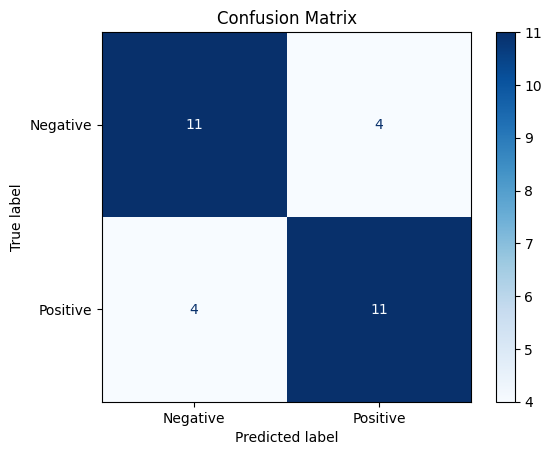


Classification Report:
              precision    recall  f1-score   support

    Negative       0.73      0.73      0.73        15
    Positive       0.73      0.73      0.73        15

    accuracy                           0.73        30
   macro avg       0.73      0.73      0.73        30
weighted avg       0.73      0.73      0.73        30

Number of selected features: 77
Shape of SHAP values: (252, 77)


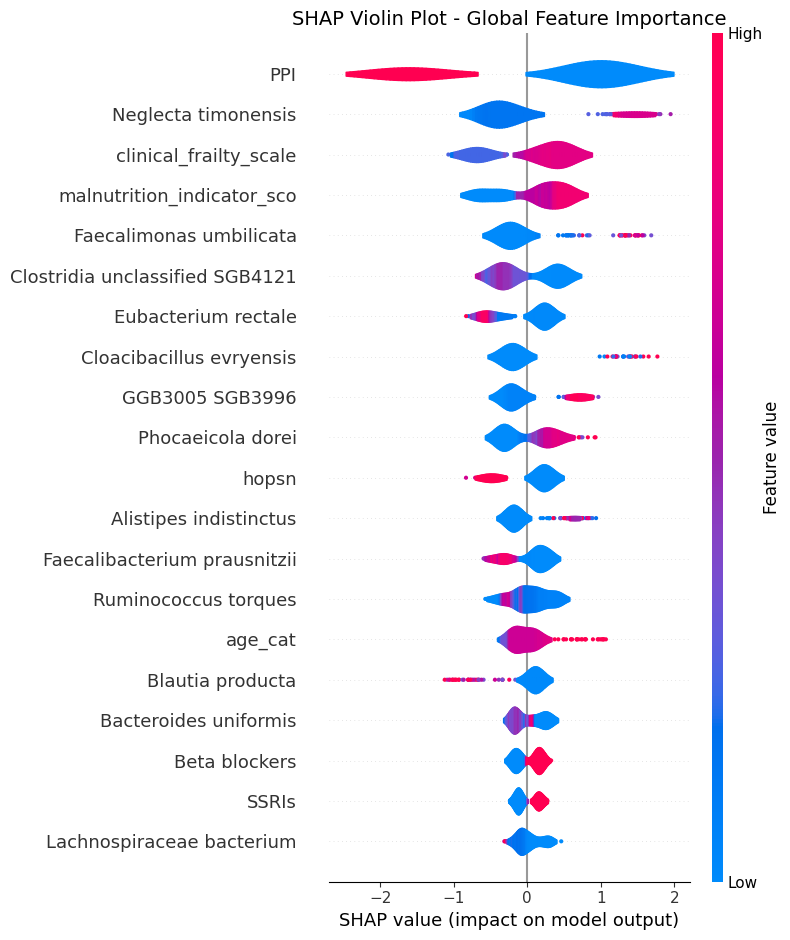

Overlap bacteria found: {'Alistipes_onderdonkii', 'Alistipes_putredinis', 'Evtepia_gabavorous', 'Faecalibacterium_prausnitzii', 'Intestinimonas_massiliensis', 'Lachnospiraceae_bacterium', 'GGB4566_SGB6305', 'Bifidobacterium_dentium', 'Barnesiella_intestinihominis', 'Gemmiger_formicilis', 'Oscillibacter_sp_ER4', 'Limosilactobacillus_reuteri', 'Monoglobus_pectinilyticus', 'Phocaeicola_dorei', 'Alistipes_dispar', 'Firmicutes_bacterium_AF16_15', 'GGB9176_SGB14114', 'Bacteroides_uniformis', 'Lachnospiraceae_unclassified_SGB66069', 'Massilistercora_timonensis', 'Bifidobacterium_longum', 'Ruminococcus_gnavus', 'GGB3433_SGB4573', 'GGB9633_SGB15090', 'Dysosmobacter_welbionis', 'Alistipes_indistinctus', 'Clostridium_innocuum', 'Clostridiales_bacterium', 'Bacteroides_eggerthii', 'GGB1407_SGB1930', 'Ruminococcus_SGB4421', 'Bacteroides_caccae', 'Blautia_producta', 'Roseburia_hominis', 'GGB2982_SGB3964', 'Clostridiaceae_bacterium', 'Lachnospiraceae_bacterium_WCA3_601_WT_6H', 'Catabacter_hongkongensi

In [14]:
import optuna
from optuna.samplers import TPESampler
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import (
    roc_curve, roc_auc_score, f1_score, accuracy_score, confusion_matrix, 
    classification_report, ConfusionMatrixDisplay
)

from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from sklearn.model_selection import train_test_split
from copy import deepcopy
from sklearn.preprocessing import StandardScaler

# Constants and Configuration
print(f"Experiment number: {experiment_number} | Seed number: {seed}")
# seed = experiment_seed  # Replace with your experiment seed
test_size = 0.25
gpu_device = "hist"

# Function to check for overlaps between train and test data
def check_for_overlap(train_data, test_data):
    """
    Checks for overlapping Sample ID and study_id between train and test datasets.
    """
    # Check for overlapping Study IDs
    overlap_study_ids = set(train_data["study_id"]) & set(test_data["study_id"])
    if overlap_study_ids:
        print(f"Overlap Study ID found: {overlap_study_ids}")
    else:
        print("No overlap Study ID found.")

    # Check for overlapping Sample IDs
    overlap_sample_ids = set(train_data["Sample ID"]) & set(test_data["Sample ID"])
    if overlap_sample_ids:
        print(f"Overlap Sample ID found: {overlap_sample_ids}")
    else:
        print("No overlap Sample ID found.")

def check_for_bacteria(list_a, list_b):
    """
    Checks for overlapping bactertia from list_a and list list_b database and predicted bacteria.
    """
    # Check for overlapping Study IDs
    list_a = [item.replace(" ", "_") for item in list_a]
    list_b = [item.replace(" ", "_") for item in list_b]
    
    overlap_bacteria = set(list_a) & set(list_b)
    if overlap_bacteria:
        print(f"Overlap bacteria found: {overlap_bacteria}")
    else:
        print("No overlap bacteria found.")
    return overlap_bacteria

        
def preprocess_data(df, columns_to_drop, test_size, seed):
    # Split study IDs into train/test sets
    study_labels = df.groupby("study_id")["Alzheimers"].max().reset_index()
    train_ids, test_ids = train_test_split(
        study_labels["study_id"],
        test_size=test_size,
        stratify=study_labels["Alzheimers"],
        random_state=seed,
    )
    
    train_data = df[df["study_id"].isin(train_ids)].copy()
    test_data = df[df["study_id"].isin(test_ids)].copy()

    # Check for overlaps
    check_for_overlap(train_data, test_data)
    
    # Select feature columns
    feature_columns = [col for col in df.columns if col not in columns_to_drop]

    # Convert feature columns to float64 to ensure compatibility
    train_data[feature_columns] = train_data[feature_columns].astype(np.float64)
    test_data[feature_columns] = test_data[feature_columns].astype(np.float64)

    # Normalize the feature columns
    # scaler = StandardScaler()
    # train_data.loc[:, feature_columns] = scaler.fit_transform(train_data[feature_columns])
    # test_data.loc[:, feature_columns] = scaler.transform(test_data[feature_columns])

    return train_data, test_data, feature_columns

# Function to compute class weights
def compute_weights(y_train):
    class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
    scale_pos_weight = class_weights[1] / class_weights[0]
    return scale_pos_weight

# Define Optuna Objective Function
def objective(trial, X_train, y_train, scale_pos_weight, seed):
    print(f"Seed in the model {seed} on Device {device}")
    # Feature selection parameters
    threshold = trial.suggest_categorical('threshold', ['median', 'mean', '0.5*mean', '1.5*mean', 'very_low'])
    max_features = trial.suggest_int('max_features', 1, X_train.shape[1])
    norm_order = trial.suggest_int('norm_order', 1, 2)
    threshold_value = -1e10 if threshold == 'very_low' else threshold

    # Feature selection
    selector = SelectFromModel(
        estimator=XGBClassifier(
            objective='binary:logistic',
            eval_metric='logloss',
            scale_pos_weight= scale_pos_weight,
            random_state=seed,
            tree_method=gpu_device, 
            device=device,

        ),
        threshold=threshold_value,
        max_features=max_features,
        norm_order=norm_order
    )
    
    selector.fit(X_train, y_train)
    X_train_selected = selector.transform(X_train)

    # Define XGBoost parameters
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
        'max_depth': trial.suggest_int('max_depth', 3, 30),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'scale_pos_weight': scale_pos_weight,
        'seed': seed,
        'tree_method': gpu_device,
        'device': device,

    }

    # Cross-validation
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)
    f1_scores = []
    for train_idx, val_idx in skf.split(X_train_selected, y_train):
        X_train_fold, X_val_fold = X_train_selected[train_idx], X_train_selected[val_idx]
        y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]
        dtrain = xgb.DMatrix(X_train_fold, label=y_train_fold)
        dval = xgb.DMatrix(X_val_fold, label=y_val_fold)
        model = xgb.train(
            params=params,
            dtrain=dtrain,
            num_boost_round=trial.suggest_int("n_estimators", 50, 300),
            evals=[(dtrain, 'train'), (dval, 'eval')],
            early_stopping_rounds=50,
            verbose_eval=False
        )
        y_val_pred = model.predict(dval)
        y_val_pred_binary = (y_val_pred >= 0.5).astype(int)
        f1_scores.append(f1_score(y_val_fold, y_val_pred_binary))
    return np.mean(f1_scores)

# Main Program
columns_to_drop = ["Sample ID", "study_id", "Alzheimers", "Date Sample", "age", "Dementia Other"] # "malnutrition_indicator_sco", "clinical_frailty_scale", "PPI", 

train_data, test_data, feature_columns = preprocess_data(clinical_microbiome_df, columns_to_drop, test_size, seed)

test_data = test_data.groupby('Alzheimers', group_keys=False).apply(
    lambda x: x.sample(n=15, random_state=seed)
).reset_index(drop=True)

X_train = deepcopy(train_data[feature_columns].values)
y_train = np.array(train_data["Alzheimers"].values)
X_test = deepcopy(test_data[feature_columns].values)
y_test = np.array(test_data["Alzheimers"].values)
scale_pos_weight = compute_weights(y_train)

# Run Optuna Optimization
study = optuna.create_study(direction="maximize", sampler=TPESampler(seed=seed))
study.optimize(lambda trial: objective(trial, X_train, y_train, scale_pos_weight, seed), n_trials=200)

# Best Parameters
best_params = study.best_params
print("Best Parameters:", best_params)

# Apply Final Model
final_selector = SelectFromModel(
    estimator=XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        random_state=seed,
        tree_method=gpu_device,
        device=device,
        scale_pos_weight=scale_pos_weight,

    ),
    
    threshold=-1e10 if best_params['threshold'] == 'very_low' else best_params['threshold'],
    max_features=best_params['max_features'],
    norm_order=best_params['norm_order']
)

final_selector.fit(X_train, y_train)
X_train_selected = final_selector.transform(X_train)
X_test_selected = final_selector.transform(X_test)

# Train Final Model
final_model_params = {
    **{k: v for k, v in best_params.items() if k not in ['threshold', 'norm_order', 'max_features', 'n_estimators']},
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'scale_pos_weight': scale_pos_weight,
    'seed': seed,
    'tree_method': gpu_device,
    'device': device,

}

dtrain_final = xgb.DMatrix(X_train_selected, label=y_train)
dtest_final = xgb.DMatrix(X_test_selected)

final_model = xgb.train(
    params=final_model_params,
    dtrain=dtrain_final,
    num_boost_round=best_params['n_estimators'],
)

# Predictions and Evaluation
y_test_pred = final_model.predict(dtest_final)
y_test_pred_binary = (y_test_pred >= 0.5).astype(int)
auc = roc_auc_score(y_test, y_test_pred_binary)
accuracy = accuracy_score(y_test, y_test_pred_binary)
f1 = f1_score(y_test, y_test_pred_binary)
conf_matrix = confusion_matrix(y_test, y_test_pred_binary)

print("\nTest Metrics:")
print(f"ROC AUC: {auc}\nAccuracy: {accuracy}\nF1 Score: {f1}\nConfusion Matrix:\n{conf_matrix}")
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Negative", "Positive"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

report = classification_report(y_test, y_test_pred_binary, target_names=["Negative", "Positive"])
print("\nClassification Report:")
print(report)

# Extract feature names for selected features
selected_feature_names = [feature_columns[i] for i in final_selector.get_support(indices=True)]
print(f"Number of selected features: {len(selected_feature_names)}")

# Step 1: Initialize SHAP explainer
explainer = shap.Explainer(final_model, X_train_selected)

# Step 2: Compute SHAP values
shap_values = explainer(X_train_selected, check_additivity=False)

# Ensure SHAP values are in the correct shape for processing
print(f"Shape of SHAP values: {shap_values.values.shape}")  # Check the shape

# Truncate each feature name to a maximum of 30 characters
max_len = 1000
selected_feature_names = [
    feature[:max_len] if len(feature) > max_len else feature  # Truncate if longer than 30 characters
    for feature in selected_feature_names
]

# Verify the selected feature names align with the SHAP values
assert len(selected_feature_names) == X_train_selected.shape[1], "Mismatch in feature names and SHAP input dimensions."

# Generate SHAP summary plot with corrected feature names
plt.figure(figsize=(20, 10))  # Increased width for a wider plot
plt.title("SHAP Violin Plot - Global Feature Importance", fontsize=14)

# Create summary plot with corrected feature names
shap.summary_plot(
    shap_values.values,  # SHAP values
    X_train_selected,  # Input data
    feature_names=selected_feature_names,  # Correct feature names
    max_display=20,  # Limit to top 20 features
    plot_type="violin"  # Violin plot with colors
)
plt.show()

bacteria_found = check_for_bacteria(bacteria_df.species_name.tolist(),selected_feature_names)

In [15]:
roc_auc_score(y_test, y_test_pred_binary)

0.7333333333333334

In [16]:
pred_results = pd.DataFrame({
    'Sample ID': test_data['Sample ID'],
    'XGB True Label': y_test.astype(int),
    'XGB Predicted Binary': y_test_pred_binary
})

pred_results

,Sample ID,XGB True Label,XGB Predicted Binary
0,DC074,0,0
1,FB223,0,1
2,DC102,0,1
3,FB344,0,0
4,DC062,0,0
5,FB049,0,1
6,FB003,0,0
7,FB152,0,0
8,DC059,0,0
9,DC060,0,0


In [17]:
auc

0.7333333333333334

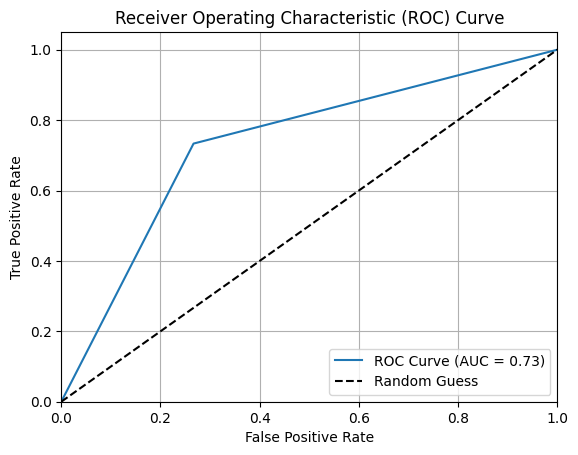

In [18]:
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_binary)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')  # Dashed diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [19]:
accuracy

0.7333333333333333

In [20]:
f1

0.7333333333333333

In [21]:
conf_matrix

array([[11,  4],
       [ 4, 11]])

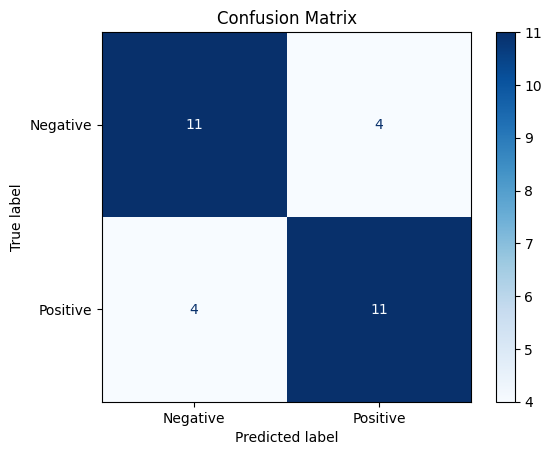

In [22]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Negative", "Positive"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

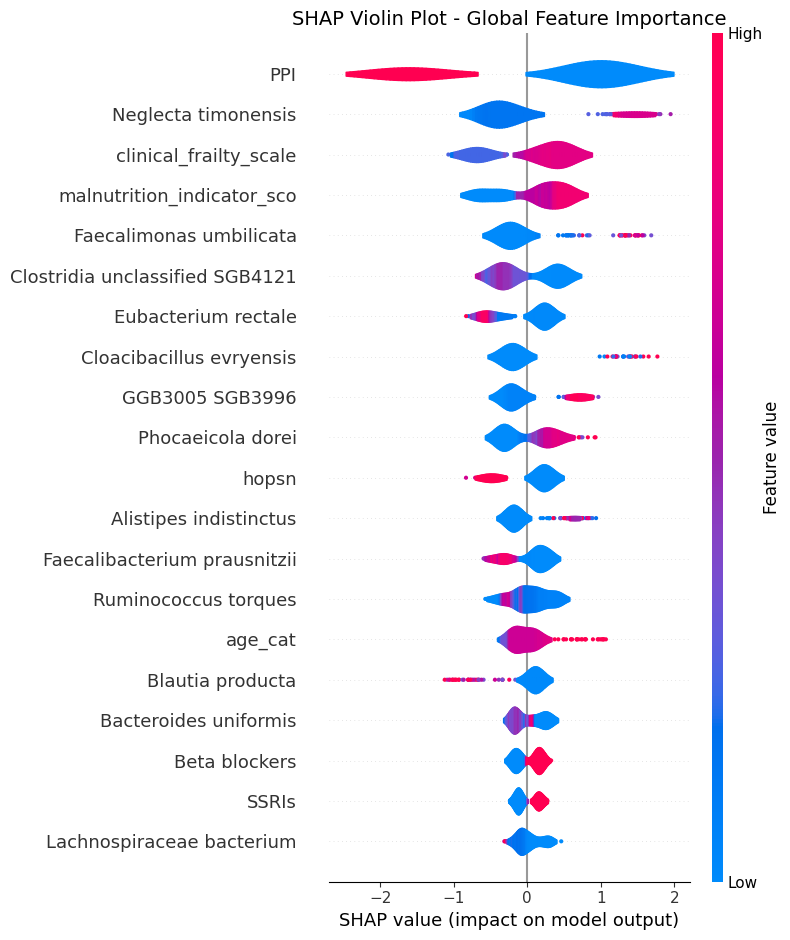

Overlap bacteria found: {'Alistipes_onderdonkii', 'Alistipes_putredinis', 'Evtepia_gabavorous', 'Faecalibacterium_prausnitzii', 'Intestinimonas_massiliensis', 'Lachnospiraceae_bacterium', 'GGB4566_SGB6305', 'Bifidobacterium_dentium', 'Barnesiella_intestinihominis', 'Gemmiger_formicilis', 'Oscillibacter_sp_ER4', 'Limosilactobacillus_reuteri', 'Monoglobus_pectinilyticus', 'Phocaeicola_dorei', 'Alistipes_dispar', 'Firmicutes_bacterium_AF16_15', 'GGB9176_SGB14114', 'Bacteroides_uniformis', 'Lachnospiraceae_unclassified_SGB66069', 'Massilistercora_timonensis', 'Bifidobacterium_longum', 'Ruminococcus_gnavus', 'GGB3433_SGB4573', 'GGB9633_SGB15090', 'Dysosmobacter_welbionis', 'Alistipes_indistinctus', 'Clostridium_innocuum', 'Clostridiales_bacterium', 'Bacteroides_eggerthii', 'GGB1407_SGB1930', 'Ruminococcus_SGB4421', 'Bacteroides_caccae', 'Blautia_producta', 'Roseburia_hominis', 'GGB2982_SGB3964', 'Clostridiaceae_bacterium', 'Lachnospiraceae_bacterium_WCA3_601_WT_6H', 'Catabacter_hongkongensi

In [23]:
# Verify the selected feature names align with the SHAP values
assert len(selected_feature_names) == X_train_selected.shape[1], "Mismatch in feature names and SHAP input dimensions."

# Generate SHAP summary plot with corrected feature names
plt.figure(figsize=(20, 10))  # Increased width for a wider plot
plt.title("SHAP Violin Plot - Global Feature Importance", fontsize=14)

# Create summary plot with corrected feature names
shap.summary_plot(
    shap_values.values,  # SHAP values
    X_train_selected,  # Input data
    feature_names=selected_feature_names,  # Correct feature names
    max_display=20,  # Limit to top 20 features
    plot_type="violin"  # Violin plot with colors
)
plt.show()

bacteria_found = check_for_bacteria(bacteria_df.species_name.tolist(),selected_feature_names)

In [24]:
# Compute directional SHAP statistics
mean_shap = shap_values.values.mean(axis=0)  # Mean SHAP value (directional)
mean_abs_shap = np.abs(shap_values.values).mean(axis=0)  # Mean absolute SHAP value (magnitude)
std_shap = shap_values.values.std(axis=0)  # Standard deviation of SHAP values

# Create a DataFrame summarizing the SHAP values
directional_shap_df = pd.DataFrame({
    "Feature": selected_feature_names,
    "Mean_SHAP": mean_shap,         # Direction
    "Mean_Abs_SHAP": mean_abs_shap, # Magnitude
    "Std_SHAP": std_shap            # Variability
})

# Sort by the magnitude (Mean_Abs_SHAP) in descending order
directional_shap_df = directional_shap_df.sort_values(by="Mean_Abs_SHAP", ascending=False).reset_index(drop=True)

directional_shap_df.to_csv(f"output{os.sep}xgboost_experiment{experiment_number:02d}_shap_values.csv", index=False)

Shape of SHAP values: (252, 77)


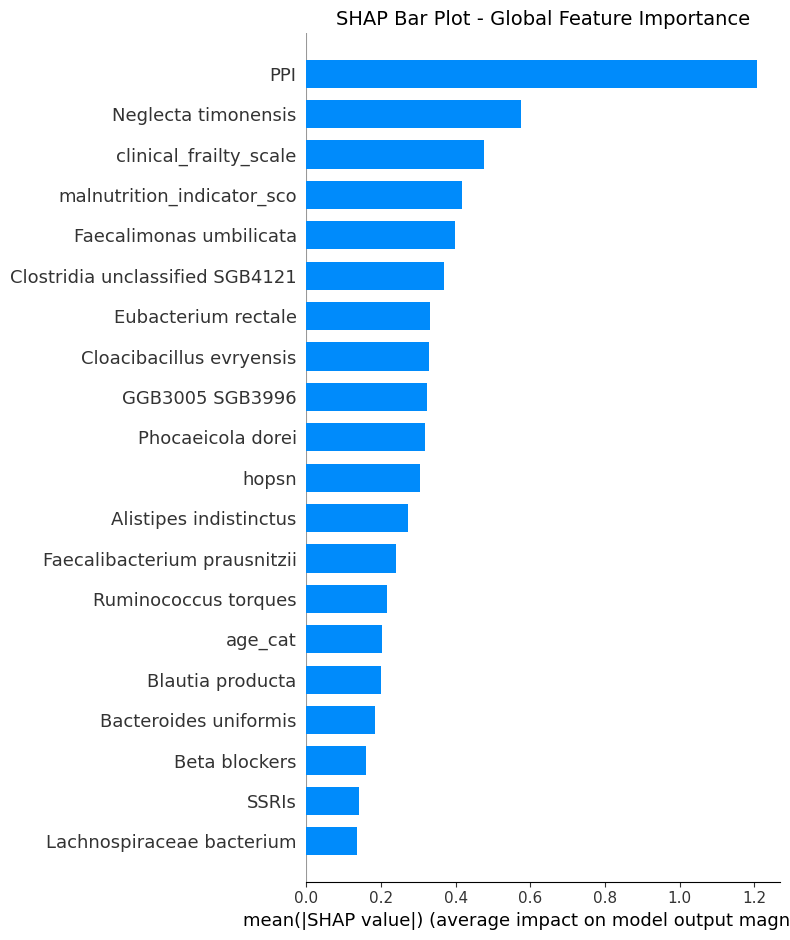

Overlap bacteria found: {'Alistipes_onderdonkii', 'Alistipes_putredinis', 'Evtepia_gabavorous', 'Faecalibacterium_prausnitzii', 'Intestinimonas_massiliensis', 'Lachnospiraceae_bacterium', 'GGB4566_SGB6305', 'Bifidobacterium_dentium', 'Barnesiella_intestinihominis', 'Gemmiger_formicilis', 'Oscillibacter_sp_ER4', 'Limosilactobacillus_reuteri', 'Monoglobus_pectinilyticus', 'Phocaeicola_dorei', 'Alistipes_dispar', 'Firmicutes_bacterium_AF16_15', 'GGB9176_SGB14114', 'Bacteroides_uniformis', 'Lachnospiraceae_unclassified_SGB66069', 'Massilistercora_timonensis', 'Bifidobacterium_longum', 'Ruminococcus_gnavus', 'GGB3433_SGB4573', 'GGB9633_SGB15090', 'Dysosmobacter_welbionis', 'Alistipes_indistinctus', 'Clostridium_innocuum', 'Clostridiales_bacterium', 'Bacteroides_eggerthii', 'GGB1407_SGB1930', 'Ruminococcus_SGB4421', 'Bacteroides_caccae', 'Blautia_producta', 'Roseburia_hominis', 'GGB2982_SGB3964', 'Clostridiaceae_bacterium', 'Lachnospiraceae_bacterium_WCA3_601_WT_6H', 'Catabacter_hongkongensi

In [25]:
# Ensure SHAP values are in the correct shape for processing
print(f"Shape of SHAP values: {shap_values.values.shape}")  # Check the shape

# Truncate each feature name to a maximum of 30 characters
max_len = 1000
selected_feature_names = [
    feature[:max_len] if len(feature) > max_len else feature  # Truncate if longer than 30 characters
    for feature in selected_feature_names
]

# Verify the selected feature names align with the SHAP values
assert len(selected_feature_names) == X_train_selected.shape[1], "Mismatch in feature names and SHAP input dimensions."

# Generate SHAP summary plot with corrected feature names
plt.figure(figsize=(20, 10))  # Increased width for a wider plot
plt.title("SHAP Bar Plot - Global Feature Importance", fontsize=14)

# Create summary plot with corrected feature names
shap.summary_plot(
    shap_values.values,  # SHAP values
    X_train_selected,  # Input data
    feature_names=selected_feature_names,  # Correct feature names
    max_display=20,  # Limit to top 20 features
    plot_type="bar"  # Violin plot with colors
)
plt.show()

bacteria_found = check_for_bacteria(bacteria_df.species_name.tolist(),selected_feature_names)

In [26]:
measures = ["xgboost", seed, experiment_number, accuracy, auc, f1]

# Create a DataFrame with appropriate column names
columns = ["Model", "Seed", "Experiment_Number", "Accuracy", "AUC", "F1_Score"]
measures_df = pd.DataFrame([measures], columns=columns)
measures_df

# 0	xgboost	315491657	1	0.820513	0.9125	0.78125
# 0	xgboost	315491657	1	0.846154	0.886806	0.8125

,Model,Seed,Experiment_Number,Accuracy,AUC,F1_Score
0,xgboost,681076636,17,0.733333,0.733333,0.733333


In [27]:
output_path = "output"
measures_path = f"{output_path}{os.sep}xgboost_experiment{experiment_number:02d}_measures.csv"
if output_path and not os.path.exists(output_path):
    os.makedirs(output_path)
measures_path

'output/xgboost_experiment17_measures.csv'

In [28]:
measures_df.to_csv(measures_path, index=False)

In [29]:
y_test_pred = final_model.predict(dtest_final)
y_test_pred_binary = (y_test_pred >= 0.5).astype(int)

# Initialize an empty list to store DataFrames for each observation
all_records = []

# Loop through all observations in the dataset
for observation_idx in range(X_train_selected.shape[0]):
    # Verify SHAP values are accessible
    if hasattr(shap_values, "values"):  # For SHAP Explanation object
        shap_values = shap_values.values

    # Verify dimensions
    assert shap_values.shape[1] == len(selected_feature_names), \
        "Mismatch between SHAP values and feature names."

    # Create a DataFrame for the current observation
    observation_df = pd.DataFrame({
        "Sample ID": [train_data["Sample ID"].iloc[observation_idx]] * len(selected_feature_names),
        "Study ID": [train_data["study_id"].iloc[observation_idx]] * len(selected_feature_names),
        "Feature Name": selected_feature_names,
        "Feature Value": X_train_selected[observation_idx, :],
        "SHAP Value": shap_values[observation_idx, :],
        "Ground Truth": [y_train[observation_idx]] * len(selected_feature_names)
    })

    # Append the observation DataFrame to the list
    all_records.append(observation_df)

# Combine all observation DataFrames into a single DataFrame
combined_force_plot_train_df = pd.concat(all_records, ignore_index=True)
combined_force_plot_train_df

,Sample ID,Study ID,Feature Name,Feature Value,SHAP Value,Ground Truth
0,DC071,CH1-002,age_cat,3.0,0.083477,0.0
1,DC071,CH1-002,male,0.0,0.009421,0.0
2,DC071,CH1-002,hopsn,0.0,0.195207,0.0
3,DC071,CH1-002,malnutrition_indicator_sco,2.0,0.399594,0.0
4,DC071,CH1-002,clinical_frailty_scale,6.0,0.103374,0.0
...,...,...,...,...,...,...
19399,FB204,CH3-010,Parabacteroides johnsonii,0.0,-0.000719,0.0
19400,FB204,CH3-010,Alistipes dispar,0.0,0.008295,0.0
19401,FB204,CH3-010,GGB3005 SGB3996,0.0,-0.274411,0.0
19402,FB204,CH3-010,Limosilactobacillus reuteri,0.0,0.000000,0.0


In [30]:
combined_force_plot_train_df[combined_force_plot_train_df['Feature Name']=='Escherichia coli']

,Sample ID,Study ID,Feature Name,Feature Value,SHAP Value,Ground Truth


In [31]:
train_data[train_data["Sample ID"]=='DC071'][["Escherichia coli"]]

,Escherichia coli
0,14.56875


In [32]:
# Step 2: Compute SHAP values
shap_values_test = explainer(X_test_selected, check_additivity=False)

# Initialize an empty list to store DataFrames for each observation
all_records = []

# Loop through all observations in the dataset
for observation_idx in range(X_test_selected.shape[0]):
    # Verify SHAP values are accessible
    if hasattr(shap_values_test, "values"):  # For SHAP Explanation object
        shap_values_test = shap_values_test.values

    # Verify dimensions
    assert shap_values_test.shape[1] == len(selected_feature_names), \
        "Mismatch between SHAP values and feature names."

    # Create a DataFrame for the current observation
    observation_df = pd.DataFrame({
        "Sample ID": [test_data["Sample ID"].iloc[observation_idx]] * len(selected_feature_names),
        "Study ID": [test_data["study_id"].iloc[observation_idx]] * len(selected_feature_names),
        "Feature Name": selected_feature_names,
        "Feature Value": X_test_selected[observation_idx, :],
        "SHAP Value": shap_values_test[observation_idx, :],
        "Predicted Percentage": [y_test_pred[observation_idx]] * len(selected_feature_names),
        "Predicted Status": [y_test_pred_binary[observation_idx]] * len(selected_feature_names)
    })

    # Append the observation DataFrame to the list
    all_records.append(observation_df)

# Combine all observation DataFrames into a single DataFrame
combined_force_plot_test_df = pd.concat(all_records, ignore_index=True)
combined_force_plot_test_df

,Sample ID,Study ID,Feature Name,Feature Value,SHAP Value,Predicted Percentage,Predicted Status
0,DC074,CH1-004,age_cat,3.00000,0.080925,0.282536,0
1,DC074,CH1-004,male,0.00000,0.009421,0.282536,0
2,DC074,CH1-004,hopsn,0.00000,0.159347,0.282536,0
3,DC074,CH1-004,malnutrition_indicator_sco,2.00000,0.564061,0.282536,0
4,DC074,CH1-004,clinical_frailty_scale,5.00000,-0.752709,0.282536,0
...,...,...,...,...,...,...,...
2305,FB267,CH1-132,Parabacteroides johnsonii,0.46032,0.039622,0.979824,1
2306,FB267,CH1-132,Alistipes dispar,0.00000,0.017202,0.979824,1
2307,FB267,CH1-132,GGB3005 SGB3996,0.01098,-0.159822,0.979824,1
2308,FB267,CH1-132,Limosilactobacillus reuteri,0.00000,0.000000,0.979824,1


In [33]:
combined_force_plot_test_df[combined_force_plot_test_df['Sample ID']=='FB246']

,Sample ID,Study ID,Feature Name,Feature Value,SHAP Value,Predicted Percentage,Predicted Status


In [34]:
len(selected_feature_names)

77

In [35]:
# Compute directional SHAP statistics
mean_shap = shap_values.mean(axis=0)  # Mean SHAP value (directional)
mean_abs_shap = np.abs(shap_values).mean(axis=0)  # Mean absolute SHAP value (magnitude)
std_shap = shap_values.std(axis=0)  # Standard deviation of SHAP values

# Create a DataFrame summarizing the SHAP values
directional_shap_df = pd.DataFrame({
    "Feature": selected_feature_names,
    "Mean_SHAP": mean_shap,         # Direction
    "Mean_Abs_SHAP": mean_abs_shap, # Magnitude
    "Std_SHAP": std_shap            # Variability
})

# Sort by the magnitude (Mean_Abs_SHAP) in descending order
directional_shap_df = directional_shap_df.sort_values(by="Mean_Abs_SHAP", ascending=False).reset_index(drop=True)

# Ensure the output directory exists
output_dir = "output"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
directional_shap_df.to_csv(f"{output_dir}{os.sep}xgboost_experiment{experiment_number:02d}_shap_values.csv", index=False)
directional_shap_df

,Feature,Mean_SHAP,Mean_Abs_SHAP,Std_SHAP
0,PPI,0.102658,1.208784,1.272018
1,Neglecta timonensis,-0.008418,0.574339,0.731680
2,clinical_frailty_scale,0.039154,0.475688,0.525658
3,malnutrition_indicator_sco,0.066266,0.415770,0.449756
4,Faecalimonas umbilicata,0.026426,0.398788,0.553546
...,...,...,...,...
72,Massilistercora timonensis,0.000301,0.001813,0.003756
73,Bifidobacterium dentium,0.000000,0.000000,0.000000
74,GGB9633 SGB15090,0.000000,0.000000,0.000000
75,Limosilactobacillus reuteri,0.000000,0.000000,0.000000


In [36]:
bacteria_list = [name.replace("_", " ") for name in list(bacteria_found)]
len(bacteria_list), bacteria_list[:10]

(61,
 ['Alistipes onderdonkii',
  'Alistipes putredinis',
  'Evtepia gabavorous',
  'Faecalibacterium prausnitzii',
  'Intestinimonas massiliensis',
  'Lachnospiraceae bacterium',
  'GGB4566 SGB6305',
  'Bifidobacterium dentium',
  'Barnesiella intestinihominis',
  'Gemmiger formicilis'])

In [37]:
# Assign "bacterial variable" or "clinical variable"
directional_shap_df["Variable_Type"] = directional_shap_df["Feature"].apply(
    lambda x: "bacterial" if x in bacteria_list else "clinical"
)

directional_shap_df

,Feature,Mean_SHAP,Mean_Abs_SHAP,Std_SHAP,Variable_Type
0,PPI,0.102658,1.208784,1.272018,clinical
1,Neglecta timonensis,-0.008418,0.574339,0.731680,bacterial
2,clinical_frailty_scale,0.039154,0.475688,0.525658,clinical
3,malnutrition_indicator_sco,0.066266,0.415770,0.449756,clinical
4,Faecalimonas umbilicata,0.026426,0.398788,0.553546,bacterial
...,...,...,...,...,...
72,Massilistercora timonensis,0.000301,0.001813,0.003756,bacterial
73,Bifidobacterium dentium,0.000000,0.000000,0.000000,bacterial
74,GGB9633 SGB15090,0.000000,0.000000,0.000000,bacterial
75,Limosilactobacillus reuteri,0.000000,0.000000,0.000000,bacterial


In [38]:
directional_important_shap_df = directional_shap_df[
    directional_shap_df[['Mean_SHAP', 'Mean_Abs_SHAP', 'Std_SHAP']].sum(axis=1) != 0
]
directional_important_shap_df

,Feature,Mean_SHAP,Mean_Abs_SHAP,Std_SHAP,Variable_Type
0,PPI,0.102658,1.208784,1.272018,clinical
1,Neglecta timonensis,-0.008418,0.574339,0.731680,bacterial
2,clinical_frailty_scale,0.039154,0.475688,0.525658,clinical
3,malnutrition_indicator_sco,0.066266,0.415770,0.449756,clinical
4,Faecalimonas umbilicata,0.026426,0.398788,0.553546,bacterial
...,...,...,...,...,...
68,Lachnospiraceae bacterium WCA3 601 WT 6H,0.000355,0.004278,0.010728,bacterial
69,GGB2982 SGB3964,0.000088,0.003623,0.009465,bacterial
70,Gemmiger SGB15295,0.000697,0.002316,0.009165,bacterial
71,GGB9176 SGB14114,0.000214,0.002291,0.005772,bacterial


In [39]:
directional_important_shap_df_sort = directional_important_shap_df.sort_values(by="Mean_Abs_SHAP", ascending=False)
directional_important_shap_df_sort.head(20)

,Feature,Mean_SHAP,Mean_Abs_SHAP,Std_SHAP,Variable_Type
0,PPI,0.102658,1.208784,1.272018,clinical
1,Neglecta timonensis,-0.008418,0.574339,0.731680,bacterial
2,clinical_frailty_scale,0.039154,0.475688,0.525658,clinical
3,malnutrition_indicator_sco,0.066266,0.415770,0.449756,clinical
4,Faecalimonas umbilicata,0.026426,0.398788,0.553546,bacterial
5,Clostridia unclassified SGB4121,-0.010603,0.369266,0.389271,bacterial
6,Eubacterium rectale,-0.038443,0.332552,0.369097,bacterial
7,Cloacibacillus evryensis,-0.031929,0.327968,0.487683,bacterial
8,GGB3005 SGB3996,0.002173,0.322085,0.392926,bacterial
9,Phocaeicola dorei,0.007818,0.317784,0.344416,bacterial


In [40]:
def preprocess_no_normal_data(df, columns_to_drop, test_size, seed):
    # Split study IDs into train/test sets
    study_labels = df.groupby("study_id")["Alzheimers"].max().reset_index()
    train_ids, test_ids = train_test_split(
        study_labels["study_id"],
        test_size=test_size,
        stratify=study_labels["Alzheimers"],
        random_state=seed,
    )
    
    train_data = df[df["study_id"].isin(train_ids)].copy()
    test_data = df[df["study_id"].isin(test_ids)].copy()

    # Check for overlaps
    check_for_overlap(train_data, test_data)

    return train_data, test_data, feature_columns

train_data_no_normal, test_data_no_normal, feature_columns = preprocess_no_normal_data(clinical_microbiome_df, columns_to_drop, test_size, seed)

No overlap Study ID found.
No overlap Sample ID found.


In [41]:
from glob import glob
import shap
from sklearn.model_selection import train_test_split
import numpy as np
import os
import shutil
import re
from lxml import etree
from bs4 import BeautifulSoup
from langchain.document_loaders import DirectoryLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.schema import Document
from langchain_openai import OpenAIEmbeddings
# from langchain.vectorstores.chroma import Chroma
from langchain_chroma import Chroma
from dataclasses import dataclass
from langchain.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from openai import OpenAI
from datetime import datetime
import time
import torch
import numpy as np
import random
import ipynbname
from tqdm import tqdm
import pandas as pd
import tiktoken

os.environ['OPENAI_API_KEY'] = "sk-proj-tQi6bjiemwTkb4HL9aBVT3BlbkFJ8CXmkRGGXYI60a1VF8An"
from scripts.embeddings_utils import (
    get_embedding,
    distances_from_embeddings
)

In [42]:
print(f"Experiment name: {EXPERIMENT_NAME}", f"| Initial seed: {initial_seed}")
print(f"Seeds for Experiments: {random_integers_list}")

Experiment name: nursing_home | Initial seed: 127573839
Seeds for Experiments: [315491657, 135304577, 1572185508, 1029933563, 1950160822, 563269619, 1573902777, 513873336, 442822283, 1770168448, 2042199113, 441301073, 236793113, 387615796, 1899788307, 788877054, 681076636, 504404028, 1620098870, 847071637, 1967649092, 1010220053, 644534191, 844067037, 59236795, 1814102137, 787036043, 1853222053, 745124550, 2136397237]


In [43]:
clinical_microbiome_df

,Sample ID,study_id,day,Date Sample,age,age_cat,male,abx6mo,hopsn,malnutrition_indicator_sco,...,Aerococcus sp HMSC035B07,Actinomyces oricola,Citrobacter werkmanii,Bifidobacterium angulatum,Fructilactobacillus fructivorans,Schaalia meyeri,Ndongobacter massiliensis,Actinomyces radicidentis,Candida tropicalis,GGB3297 SGB4356
0,DC071,CH1-002,0,2016-07-15,93.0,3.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,DC013,CH1-003,0,2016-07-12,68.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,DC019,CH1-003,18,2016-07-30,68.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,DC014,CH1-003,20,2016-08-01,68.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,DC015,CH1-003,23,2016-08-04,68.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330,FB187,CH3-010,2,2018-01-10,76.0,2.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
331,FB188,CH3-010,4,2018-01-12,76.0,2.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
332,FB185,CH3-010,6,2018-01-14,76.0,2.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
333,FB200,CH3-010,8,2018-01-16,76.0,2.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
glob("global_resources/*")

['global_resources/bc_df.csv',
 'global_resources/alpha_diversity_violin_plot.png',
 'global_resources/top_30_beta_diversity_heatmap.png',
 'global_resources/clinical_microbiome_df.csv',
 'global_resources/alpha_diversity_histogram.png',
 'global_resources/clade_species_df.csv',
 'global_resources/mph_matching_ad.csv',
 'global_resources/beta_diversity_hierarchical_clustering_dendrogram.png',
 'global_resources/ad_df.csv',
 'global_resources/beta_diversity_heatmap.png',
 'global_resources/shap_paper.pdf',
 'global_resources/alpha_beta_diversity.pdf']

In [45]:
clade_species_df = pd.read_csv(f'global_resources{os.sep}clade_species_df.csv')
clade_species_df["species_name"] = clade_species_df["species_name"].str.replace("_", " ")

clade_species_df.head()

,taxonomy_hierarchy,species_name
0,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,Faecalibacterium prausnitzii
1,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,Fusicatenibacter saccharivorans
2,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,Eubacterium siraeum
3,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,Gemmiger formicilis
4,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,Eubacterium rectale


In [46]:
print(f"The {EXPERIMENT_NAME} Experiment{experiment_number:02d} seed: {seed}")

The nursing_home Experiment17 seed: 681076636


In [47]:
# Function to set the seed for reproducibility
def set_seed(seed_value=42):
    """
    Set seed for reproducibility.
    """
    print("Seed set:", seed_value)
    torch.manual_seed(seed_value)  # Sets the seed for PyTorch
    torch.cuda.manual_seed_all(seed_value)
    torch.cuda.manual_seed(seed_value)
    np.random.seed(seed_value)  # Sets the seed for NumPy
    random.seed(seed_value)  # Sets the seed for Python's random module
    os.environ['PYTHONHASHSEED'] = str(seed_value)  # Set Python hash seed
    # Ensure that CuDNN uses deterministic algorithms
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(seed)

Seed set: 681076636


In [48]:
# Function to load documents
def load_documents(data_path, search_keyword):
    documents = []
    for filename in os.listdir(data_path):
        if filename.endswith(".xml"):
            file_path = os.path.join(data_path, filename)
            with open(file_path, 'r', encoding='utf-8') as file:
                content = file.read()
                cleaned_content = clean_text(content)
                documents.append(Document(page_content=cleaned_content, metadata={"source": filename, "keyword": search_keyword}))
    return documents

# Function to clean and normalize text
def clean_text(text):
    # Parse the XML
    parser = etree.XMLParser(recover=True)
    tree = etree.fromstring(text, parser=parser)
    
    # Extract text content
    raw_text = etree.tostring(tree, encoding='unicode', method='text')

    # Clean and normalize text
    soup = BeautifulSoup(raw_text, "html.parser")
    text = soup.get_text(separator=" ")
    text = re.sub(r'\s+', ' ', text).strip()
    text = text.lower()  # Normalize text to lowercase

    return text

def split_text(documents, chunk_size=2000):
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=int(chunk_size),
        chunk_overlap=int(chunk_size * 0.2),
        length_function=len,
        add_start_index=True,
    )
    chunks = text_splitter.split_documents(documents)
    print(f"Split {len(documents)} documents into {len(chunks)} chunks.")
    
    # Add unique ID to each chunk
    for chunk in chunks:
        metadata = chunk.metadata
        unique_id = f"{metadata['source']}.{metadata['start_index']}"
        metadata['id'] = unique_id
    
    return chunks

embeddings = OpenAIEmbeddings(model = 'text-embedding-ada-002',)

In [49]:
publication_path = glob(f"..{os.sep}*data{os.sep}*publications*")[0]
publication_path

'../data/publications'

In [50]:
from glob import glob
# Dictionary to store the count of files in each folder
file_counts = {}

for folder in glob(f"{publication_path}{os.sep}*"):
    # Use glob to get the list of files in each folder
    files = glob(os.path.join(folder, '*'))
    # Store the count of files
    file_counts[folder] = len(files)

# Print the count of files for each folder
for folder, count in file_counts.items():
    print(f'{folder}: {count} files')

../data/publications/gut_microbiome: 11798 files
../data/publications/immunosenescence: 1279 files
../data/publications/bacterial_translocation: 1317 files
../data/publications/gut_brain_axis: 1649 files
../data/publications/oral_microbiome: 1357 files
../data/publications/oral_gut_microbiome: 11 files
../data/publications/alzheimers: 62480 files
../data/publications/oral_gut_axis: 20 files
../data/publications/microbial_translocation: 609 files


In [51]:
publication_list =  glob(f"..{os.sep}*data{os.sep}*publications*{os.sep}*")
publication_df = pd.DataFrame(publication_list, columns=['Publications'])
publication_df = publication_df['Publications'].str.split(os.sep, expand=True)
publication_df = publication_df.iloc[:, 2:]
publication_df.columns = ['SEARCH_TYPE', 'SEARCH_KEYWORD']
publication_df

,SEARCH_TYPE,SEARCH_KEYWORD
0,publications,gut_microbiome
1,publications,immunosenescence
2,publications,bacterial_translocation
3,publications,gut_brain_axis
4,publications,oral_microbiome
5,publications,oral_gut_microbiome
6,publications,alzheimers
7,publications,oral_gut_axis
8,publications,microbial_translocation


In [52]:
knowledge_paths = glob(f"..{os.sep}knowledge*{os.sep}knowledge_base*")
knowledge_paths

['../knowledge_base/knowledge_base_ad', '../knowledge_base/knowledge_base']

In [53]:
# Store them in a dictionary for easy reference
knowledge_db_dict = {f"knowledge_db{i+1}": db for i, db in enumerate(knowledge_paths)}

# Display the loaded databases
for key, value in knowledge_db_dict.items():
    print(f"{key}: {value}")

knowledge_db1: ../knowledge_base/knowledge_base_ad
knowledge_db2: ../knowledge_base/knowledge_base


In [54]:
SEARCH_TYPE = "publications"
CHROMA_PATH = glob(f"..{os.sep}*knowledge_base")[0]
CHROMA_PATH

'../knowledge_base'

In [55]:
import requests
import json
 
def query_vector_db(query_text, top_k=5, similarity_threshold=0.75):
    """
    Query the vector database service.
    """
    try:
        response = requests.post(
            f"{SERVER_URL}/query",
            json={
                "query": query_text,
                "top_k": top_k,
                "similarity_threshold": similarity_threshold
            }
        )
        response.raise_for_status()
        return response.json()
    except Exception as e:
        print(f"Error querying vector DB: {str(e)}")
        return None
 
def rag_model(test_query, top_k, similarity):
    """
    Queries the vector database and extracts Source and Content as a JSON object.

    Args:
        test_query (str): The query string to search in the vector database.
        top_k (int): Number of top results to retrieve.
        similarity_threshold (float): Minimum similarity score threshold for the results.

    Returns:
        str: JSON-formatted string containing Source and Content.
    """

    # Query the vector database
    results = query_vector_db(
        query_text=test_query,
        top_k=top_k,
        similarity_threshold=similarity
    )

    # Regular expression to match Source and Content
    rag_pattern = r"Source: (.+?)\nContent: (.+?)(?:\nRelevance Score:|\n---|$)"

    # Find all matches
    rag_matches = re.findall(rag_pattern, results['context'], re.DOTALL)

    # Convert matches into a list of dictionaries
    rag_data = [{"Source": source.strip(), "Content": content.strip()} for source, content in rag_matches]

    # Convert the list of dictionaries to JSON
    rag_json = json.dumps(rag_data, indent=4)

    return rag_json

In [56]:
# Define URLs
win_url = "http://127.0.0.1:5000"
ubuntu_url = "http://146.189.163.52:5000"

# Check operating system
if platform.system() == "Windows":
    SERVER_URL = win_url
else:
    SERVER_URL = ubuntu_url

print(f"SERVER_URL set to: {SERVER_URL}")

# Define the query
query_text = (
    "taxonomy_hierarchy is 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Lachnospiraceae_unclassified|s__Lachnospiraceae_bacterium_10_1'. "
    "and species_name is 'Lachnospiraceae_bacterium_10_1' found in gut microbiome, "
    "define the description and group of this species in the context of alzheimer's disease at species level. "
)

# Start timing
start_time = time.perf_counter()

# Execute the RAG model
rag_output = rag_model(query_text, top_k=5, similarity=0.8)

# End timing
end_time = time.perf_counter()

# Calculate and print execution time
execution_time = end_time - start_time
print(f"Execution Time: {execution_time:.2f} seconds")

# Display RAG output
print("\nRAG Output:\n")
print(rag_output)

SERVER_URL set to: http://146.189.163.52:5000
Execution Time: 2.70 seconds

RAG Output:

[
    {
        "Source": "PMC9941547.xml",
        "Content": "description of hierarchical clustering at bacterial phylum, family, and genus levels for individual samples is presented in supplementary figure s2. figure 2 effect of resistant starches from dietary pulses on gut microbiome diversity and taxonomic hierarchies. alpha-diversity of microbiome of each group determined using (a) shannon index and (b) chao1 index. (c) pcoa analysis representing \u03b2-diversity of microbiome of each group combined or male and female groups. (d) sex-specific differences in microbiome composition for each group; covariance ellipses are displayed and bounds (dotted lines) of each group with two standard deviations (2\u03c3) in each direction from the group mean. relative abundance of gut microbiome in male and female mice or all combined at (e) phylum level and (f) genus level. ptb, pinto beans; bep, black-eye

In [57]:
clinical_microbiome_df

,Sample ID,study_id,day,Date Sample,age,age_cat,male,abx6mo,hopsn,malnutrition_indicator_sco,...,Aerococcus sp HMSC035B07,Actinomyces oricola,Citrobacter werkmanii,Bifidobacterium angulatum,Fructilactobacillus fructivorans,Schaalia meyeri,Ndongobacter massiliensis,Actinomyces radicidentis,Candida tropicalis,GGB3297 SGB4356
0,DC071,CH1-002,0,2016-07-15,93.0,3.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,DC013,CH1-003,0,2016-07-12,68.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,DC019,CH1-003,18,2016-07-30,68.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,DC014,CH1-003,20,2016-08-01,68.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,DC015,CH1-003,23,2016-08-04,68.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330,FB187,CH3-010,2,2018-01-10,76.0,2.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
331,FB188,CH3-010,4,2018-01-12,76.0,2.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
332,FB185,CH3-010,6,2018-01-14,76.0,2.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
333,FB200,CH3-010,8,2018-01-16,76.0,2.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [58]:
glob("global_resources/*")

['global_resources/bc_df.csv',
 'global_resources/alpha_diversity_violin_plot.png',
 'global_resources/top_30_beta_diversity_heatmap.png',
 'global_resources/clinical_microbiome_df.csv',
 'global_resources/alpha_diversity_histogram.png',
 'global_resources/clade_species_df.csv',
 'global_resources/mph_matching_ad.csv',
 'global_resources/beta_diversity_hierarchical_clustering_dendrogram.png',
 'global_resources/ad_df.csv',
 'global_resources/beta_diversity_heatmap.png',
 'global_resources/shap_paper.pdf',
 'global_resources/alpha_beta_diversity.pdf']

In [59]:
clade_species_df = pd.read_csv(f'global_resources{os.sep}clade_species_df.csv')
clade_species_df["species_name"] = clade_species_df["species_name"].str.replace("_", " ")

clade_species_df.head()

,taxonomy_hierarchy,species_name
0,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,Faecalibacterium prausnitzii
1,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,Fusicatenibacter saccharivorans
2,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,Eubacterium siraeum
3,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,Gemmiger formicilis
4,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,Eubacterium rectale


In [60]:
print(f"The {EXPERIMENT_NAME} Experiment{experiment_number:02d} seed: {seed}")

The nursing_home Experiment17 seed: 681076636


In [61]:
SEARCH_TYPE, CHROMA_PATH

('publications', '../knowledge_base')

In [62]:
# Function to set the seed for reproducibility
def set_seed(seed_value=42):
    """
    Set seed for reproducibility.
    """
    print("Seed set:", seed_value)
    torch.manual_seed(seed_value)  # Sets the seed for PyTorch
    torch.cuda.manual_seed_all(seed_value)
    torch.cuda.manual_seed(seed_value)
    np.random.seed(seed_value)  # Sets the seed for NumPy
    random.seed(seed_value)  # Sets the seed for Python's random module
    os.environ['PYTHONHASHSEED'] = str(seed_value)  # Set Python hash seed
    # Ensure that CuDNN uses deterministic algorithms
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(seed)

Seed set: 681076636


In [63]:
embeddings = OpenAIEmbeddings(model = 'text-embedding-ada-002',)

In [64]:
publication_path

'../data/publications'

In [65]:
publication_df

,SEARCH_TYPE,SEARCH_KEYWORD
0,publications,gut_microbiome
1,publications,immunosenescence
2,publications,bacterial_translocation
3,publications,gut_brain_axis
4,publications,oral_microbiome
5,publications,oral_gut_microbiome
6,publications,alzheimers
7,publications,oral_gut_axis
8,publications,microbial_translocation


In [66]:
knowledge_paths

['../knowledge_base/knowledge_base_ad', '../knowledge_base/knowledge_base']

In [67]:
len(clinical_microbiome_df['study_id'].unique()), len(train_data_no_normal['study_id'].unique()), len(test_data_no_normal['study_id'].unique())

(102, 76, 26)

In [68]:
clinical_microbiome_tr = train_data
print(clinical_microbiome_tr['Alzheimers'].value_counts())
print(clinical_microbiome_tr['Alzheimers'].value_counts(normalize=True))
clinical_microbiome_tr.head()

0.0    170
1.0     82
Name: Alzheimers, dtype: int64
0.0    0.674603
1.0    0.325397
Name: Alzheimers, dtype: float64


,Sample ID,study_id,day,Date Sample,age,age_cat,male,abx6mo,hopsn,malnutrition_indicator_sco,...,Aerococcus sp HMSC035B07,Actinomyces oricola,Citrobacter werkmanii,Bifidobacterium angulatum,Fructilactobacillus fructivorans,Schaalia meyeri,Ndongobacter massiliensis,Actinomyces radicidentis,Candida tropicalis,GGB3297 SGB4356
0,DC071,CH1-002,0.0,2016-07-15,93.0,3.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,DC013,CH1-003,0.0,2016-07-12,68.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,DC019,CH1-003,18.0,2016-07-30,68.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,DC014,CH1-003,20.0,2016-08-01,68.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,DC015,CH1-003,23.0,2016-08-04,68.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [69]:
clinical_microbiome_tt = test_data
print(clinical_microbiome_tt['Alzheimers'].value_counts())
print(clinical_microbiome_tt['Alzheimers'].value_counts(normalize=True))
clinical_microbiome_tt.head()

0.0    15
1.0    15
Name: Alzheimers, dtype: int64
0.0    0.5
1.0    0.5
Name: Alzheimers, dtype: float64


,Sample ID,study_id,day,Date Sample,age,age_cat,male,abx6mo,hopsn,malnutrition_indicator_sco,...,Aerococcus sp HMSC035B07,Actinomyces oricola,Citrobacter werkmanii,Bifidobacterium angulatum,Fructilactobacillus fructivorans,Schaalia meyeri,Ndongobacter massiliensis,Actinomyces radicidentis,Candida tropicalis,GGB3297 SGB4356
0,DC074,CH1-004,71.0,2016-09-22,87.0,3.0,0.0,1.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,FB223,CH1-136,0.0,2018-04-05,89.0,3.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,DC102,CH1-040,0.0,2016-11-11,84.0,2.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,FB344,CH1-165,122.0,2018-09-17,82.0,2.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,DC062,CH1-011,81.0,2016-10-02,89.0,3.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [70]:
len_tr, len_tt = len(clinical_microbiome_tr), len(clinical_microbiome_tt)
len_total = len_tr+len_tt
round(len_tr/len_total, 2), round(len_tt/len_total, 2), len_tr, len_tt

(0.89, 0.11, 252, 30)

In [71]:
# Check for uniqueness of existence
tr_in_tt_unique = clinical_microbiome_tr['Sample ID'].isin(clinical_microbiome_tt['Sample ID']).unique().tolist()
tt_in_tr_unique = clinical_microbiome_tt['Sample ID'].isin(clinical_microbiome_tr['Sample ID']).unique().tolist()

tr_in_tt_unique, tt_in_tr_unique

([False], [False])

In [72]:
# Check for uniqueness of existence
tr_in_tt_unique = clinical_microbiome_tr['study_id'].isin(clinical_microbiome_tt['study_id']).unique().tolist()
tt_in_tr_unique = clinical_microbiome_tt['study_id'].isin(clinical_microbiome_tr['study_id']).unique().tolist()

tr_in_tt_unique, tt_in_tr_unique

([False], [False])

In [73]:
clinical_data_dictionary = pd.read_csv(f"..{os.sep}data{os.sep}clinical_variable_explanations_df.csv")
clinical_data_dictionary

,Feature Name,Feature Notes,Feature Group,Feature Description,Feature Explanation
0,ID Match,Identifier for patient or participant matching...,Study Identification,Identifier for patient or participant matching...,- **Feature Name:** ID Match\n\n - **Definiti...
1,Sample ID,Unique Sample Identifier,Study Identification,Unique identifier for biological or clinical s...,- **Feature Name:** Sample ID\n\n - **Definit...
2,Version 2,If there is a second metaphlan file,Study Identification,Version control for data entry or survey.,- **Feature Name:** Version 2\n\n - **Definit...
3,Version 3,If there is a third metaphlan file,Study Identification,Updated version for data entry or survey.,- **Feature Name:** Version 3\n\n - **Definit...
4,study_id,Unique ID number for each elder,Study Identification,Identifier for the specific study or research ...,- **Feature Name:** study_id\n\n - **Definiti...
...,...,...,...,...,...
112,Severe Liver disease,Each medical problem Y/N,Hepatic Condition,Advanced liver disease diagnosis.,- **Feature Name:** Severe Liver Disease\n\n ...
113,ostomy,Each medical problem Y/N,Surgical History,Presence of an ostomy.,- **Feature Name:** ostomy\n\n - **Definition...
114,Alzheimers,Each medical problem Y/N,Neurological Condition,Diagnosis of Alzheimer's disease.,- **Feature Name:** Alzheimers\n\n - **Defini...
115,Dementia Other,Each medical problem Y/N,Neurological Condition,Other forms of dementia.,- **Feature Name:** Dementia Other\n\n - **De...


In [74]:
train_sample_ids = train_data['Sample ID'].tolist()
test_sample_ids = test_data['Sample ID'].tolist()

In [75]:
train_study_ids = set(train_data['study_id'].tolist())
test_study_ids = set(test_data['study_id'].tolist())

In [76]:
filtered_mph_matching_df = pd.read_csv(f"global_resources{os.sep}mph_matching_ad.csv")
print(filtered_mph_matching_df.shape)
filtered_mph_matching_df

(940, 354)


,species_name,DC001,DC002,DC003,DC004,DC005,DC006,DC007,DC008,DC009,...,FB438,FB439,FB441,FB442,FB443,FB444,FB445,FB446,FB447,FB448
0,Faecalibacterium prausnitzii,0.88312,4.15614,3.26882,0.63443,0.58702,0.00000,1.62361,0.00000,0.00000,...,0.00000,0.00000,0.82179,0.00000,1.33651,0.19949,1.73410,0.00000,0.00000,0.00000
1,Fusicatenibacter saccharivorans,0.00000,1.11662,0.12883,0.00000,1.27934,0.20162,0.71500,0.62379,1.77729,...,0.00000,0.00000,0.21130,0.00000,0.07712,0.00000,0.00000,0.00000,0.01925,0.00000
2,Eubacterium siraeum,0.21021,0.42263,0.36465,0.00000,0.15773,0.00000,0.72401,1.32474,0.03696,...,0.39056,0.00000,1.35903,2.07693,7.43349,8.26477,0.00000,0.04898,0.75876,0.01841
3,Gemmiger formicilis,0.00000,0.83369,0.69436,0.00000,0.53212,0.00000,1.36817,0.33282,0.00000,...,0.00000,0.00000,0.00613,0.00000,0.15577,0.02192,1.08905,0.00000,0.00000,0.00000
4,Eubacterium rectale,3.76495,10.46160,5.29382,15.00962,3.38370,11.91188,0.75707,3.11820,9.77486,...,0.00000,4.35475,1.75420,0.29009,2.36991,0.06056,3.74028,0.04205,0.54103,0.00410
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
935,Schaalia meyeri,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
936,Ndongobacter massiliensis,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
937,Actinomyces radicidentis,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
938,Candida tropicalis,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [77]:
filtered_mph_matching_df_t = filtered_mph_matching_df.set_index("species_name").T.reset_index()
filtered_mph_matching_df_t = filtered_mph_matching_df_t.rename(columns={'index': 'sample_ids'})
filtered_mph_matching_df_t = filtered_mph_matching_df_t.set_index('sample_ids')

filtered_mph_matching_df_t
# filtered_mph_matching_df_t.reset_index()

species_name,Faecalibacterium prausnitzii,Fusicatenibacter saccharivorans,Eubacterium siraeum,Gemmiger formicilis,Eubacterium rectale,Phocaeicola vulgatus,Lachnospiraceae bacterium WCA3 601 WT 6H,Alistipes putredinis,Clostridium sp AF15 49,Blautia wexlerae,...,Aerococcus sp HMSC035B07,Actinomyces oricola,Citrobacter werkmanii,Bifidobacterium angulatum,Fructilactobacillus fructivorans,Schaalia meyeri,Ndongobacter massiliensis,Actinomyces radicidentis,Candida tropicalis,GGB3297 SGB4356
sample_ids,,,,,,,,,,,,,,,,,,,,,
DC001,0.88312,0.00000,0.21021,0.00000,3.76495,0.00000,0.0,3.06212,0.0,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DC002,4.15614,1.11662,0.42263,0.83369,10.46160,0.00000,0.0,0.82635,0.0,2.34879,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DC003,3.26882,0.12883,0.36465,0.69436,5.29382,0.00000,0.0,1.29773,0.0,1.11542,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DC004,0.63443,0.00000,0.00000,0.00000,15.00962,0.00000,0.0,0.00000,0.0,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DC005,0.58702,1.27934,0.15773,0.53212,3.38370,0.00000,0.0,1.24714,0.0,1.26064,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FB444,0.19949,0.00000,8.26477,0.02192,0.06056,4.68323,0.0,2.80867,0.0,0.49110,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FB445,1.73410,0.00000,0.00000,1.08905,3.74028,0.00776,0.0,0.00000,0.0,5.53794,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FB446,0.00000,0.00000,0.04898,0.00000,0.04205,2.15788,0.0,0.17875,0.0,18.88493,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [78]:
matching_index = filtered_mph_matching_df_t.index
# Filter rows in filtered_mph_matching_df_t based on Sample IDs in clinical_microbiome_df
filtered_mph_matching_df_t = filtered_mph_matching_df_t[
    filtered_mph_matching_df_t.index.isin(clinical_microbiome_df["Sample ID"])
]

# Display the new filtered DataFrame
filtered_mph_matching_df_t

species_name,Faecalibacterium prausnitzii,Fusicatenibacter saccharivorans,Eubacterium siraeum,Gemmiger formicilis,Eubacterium rectale,Phocaeicola vulgatus,Lachnospiraceae bacterium WCA3 601 WT 6H,Alistipes putredinis,Clostridium sp AF15 49,Blautia wexlerae,...,Aerococcus sp HMSC035B07,Actinomyces oricola,Citrobacter werkmanii,Bifidobacterium angulatum,Fructilactobacillus fructivorans,Schaalia meyeri,Ndongobacter massiliensis,Actinomyces radicidentis,Candida tropicalis,GGB3297 SGB4356
sample_ids,,,,,,,,,,,,,,,,,,,,,
DC001,0.88312,0.00000,0.21021,0.00000,3.76495,0.00000,0.0,3.06212,0.0,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DC002,4.15614,1.11662,0.42263,0.83369,10.46160,0.00000,0.0,0.82635,0.0,2.34879,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DC003,3.26882,0.12883,0.36465,0.69436,5.29382,0.00000,0.0,1.29773,0.0,1.11542,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DC004,0.63443,0.00000,0.00000,0.00000,15.00962,0.00000,0.0,0.00000,0.0,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DC005,0.58702,1.27934,0.15773,0.53212,3.38370,0.00000,0.0,1.24714,0.0,1.26064,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FB443,1.33651,0.07712,7.43349,0.15577,2.36991,6.07880,0.0,1.74378,0.0,0.43944,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FB444,0.19949,0.00000,8.26477,0.02192,0.06056,4.68323,0.0,2.80867,0.0,0.49110,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FB445,1.73410,0.00000,0.00000,1.08905,3.74028,0.00776,0.0,0.00000,0.0,5.53794,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [79]:
from skbio.diversity import alpha_diversity
from skbio.diversity import beta_diversity # Import beta_diversity directly

def calculate_and_save_alpha_diversity(df, sample_ids, metric='shannon', output_filename=None):
    """
    Calculate alpha diversity for the given DataFrame and sample IDs, and save the results to a file.
    
    Parameters:
        df (pd.DataFrame): Input DataFrame with microbial data.
        sample_ids (list): List of sample IDs to filter.
        metric (str): Diversity metric to use (default is 'shannon').
        output_filename (str): Path to save the results (default is None, which skips saving).
        
    Returns:
        pd.DataFrame: Alpha diversity results with 'Sample ID' and metric value.
    """
    filtered_df = df[df.index.isin(sample_ids)]
    print(f"Filtered DataFrame Shape: {filtered_df.shape}")
    diversity = alpha_diversity(metric, filtered_df.values, ids=filtered_df.index)
    diversity_df = pd.DataFrame(diversity, index=filtered_df.index).reset_index()
    diversity_df.columns = ['Sample ID', f"Alpha Diversity ({metric.capitalize()} Index)"]
    
    # Save to file if a filename is provided
    if output_filename:
        # Create directory path if it doesn't exist
        directory = os.path.dirname(output_filename)
        if directory and not os.path.exists(directory):
            os.makedirs(directory)
            print(f"Created directory: {directory}")
            
        diversity_df.to_csv(output_filename, index=False)
        print(f"Alpha Diversity results saved to {output_filename}")
    
    return diversity_df

# Calculate Alpha Diversity for different datasets and save results
# Full dataset
ad_df = calculate_and_save_alpha_diversity(
    filtered_mph_matching_df_t,
    filtered_mph_matching_df_t.index.tolist(),
    output_filename=f"global_resources{os.sep}ad_df.csv"
)

# Train dataset
ad_df_tr = calculate_and_save_alpha_diversity(
    filtered_mph_matching_df_t,
    train_sample_ids,
    output_filename=f"local_resources{os.sep}experiment{experiment_number:02}{os.sep}biostatistics{os.sep}ad_df_tr.csv"
)
# print("\nAlpha Diversity (Shannon Index) for Train Dataset:")
# print(ad_df_tr)

# Test dataset
ad_df_tt = calculate_and_save_alpha_diversity(
    filtered_mph_matching_df_t,
    test_sample_ids,
    output_filename=f"local_resources{os.sep}experiment{experiment_number:02}{os.sep}biostatistics{os.sep}ad_df_tt.csv"
)
# print("\nAlpha Diversity (Shannon Index) for Test Dataset:")
# print(ad_df_tt)

print("\nAlpha Diversity (Shannon Index) for Full Dataset:")
ad_df

Filtered DataFrame Shape: (335, 940)
Alpha Diversity results saved to global_resources/ad_df.csv
Filtered DataFrame Shape: (252, 940)
Created directory: local_resources/experiment17/biostatistics
Alpha Diversity results saved to local_resources/experiment17/biostatistics/ad_df_tr.csv
Filtered DataFrame Shape: (30, 940)
Alpha Diversity results saved to local_resources/experiment17/biostatistics/ad_df_tt.csv

Alpha Diversity (Shannon Index) for Full Dataset:


,Sample ID,Alpha Diversity (Shannon Index)
0,DC001,2.519907
1,DC002,3.451174
2,DC003,3.385870
3,DC004,2.834624
4,DC005,3.290396
...,...,...
330,FB443,3.560865
331,FB444,3.401113
332,FB445,3.300568
333,FB446,3.303342


In [80]:
# Train dataset
measure_list= ['shannon', 'simpson', 'berger_parker_d']
# Loop through metrics and calculate alpha diversity
all_alpha_div_results = []
for ad_measure in measure_list:
    # Use your calculate_and_save_alpha_diversity function
    ad_temp = calculate_and_save_alpha_diversity(
        filtered_mph_matching_df_t,  # Replace with your DataFrame variable
        filtered_mph_matching_df_t.index.tolist(),  # Replace with your sample IDs
        metric=ad_measure
    )
    
    # Append the results to the list
    all_alpha_div_results.append(ad_temp)
    
    # Print the results for the current metric
    # print(f"\nAlpha Diversity ({ad_measure} Index) for Full Dataset:")
    # print(ad_temp)

# Combine results into a single DataFrame
combined_alpha_div_df = pd.concat(all_alpha_div_results, axis=1)

# Display combined results
print("\nCombined Alpha Diversity Metrics:")
combined_alpha_div_df = combined_alpha_div_df.loc[:, ~combined_alpha_div_df.columns.duplicated()]
combined_alpha_div_df

Filtered DataFrame Shape: (335, 940)
Filtered DataFrame Shape: (335, 940)
Filtered DataFrame Shape: (335, 940)

Combined Alpha Diversity Metrics:


,Sample ID,Alpha Diversity (Shannon Index),Alpha Diversity (Simpson Index),Alpha Diversity (Berger_parker_d Index)
0,DC001,2.519907,0.881144,0.207141
1,DC002,3.451174,0.955258,0.104616
2,DC003,3.385870,0.951319,0.122270
3,DC004,2.834624,0.924893,0.150096
4,DC005,3.290396,0.932922,0.203456
...,...,...,...,...
330,FB443,3.560865,0.948860,0.143986
331,FB444,3.401113,0.946262,0.107723
332,FB445,3.300568,0.933426,0.189150
333,FB446,3.303342,0.930105,0.188849


In [81]:
all_alpha_div_results[1]

,Sample ID,Alpha Diversity (Simpson Index)
0,DC001,0.881144
1,DC002,0.955258
2,DC003,0.951319
3,DC004,0.924893
4,DC005,0.932922
...,...,...
330,FB443,0.948860
331,FB444,0.946262
332,FB445,0.933426
333,FB446,0.930105


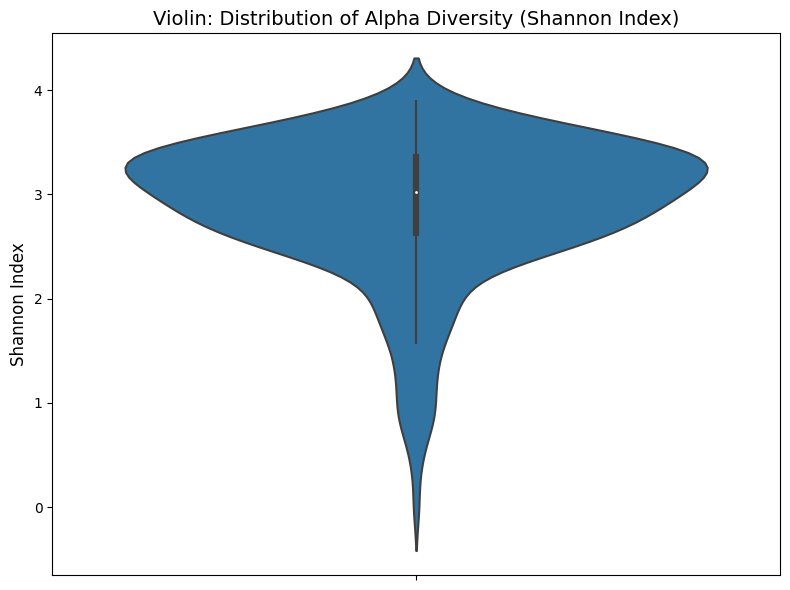

'global_resources/alpha_diversity_violin_plot.png'

In [82]:
import seaborn as sns
import matplotlib.pyplot as plt
# Create a violin plot
plt.figure(figsize=(8, 6))
sns.violinplot(y="Alpha Diversity (Shannon Index)", data=ad_df)
plt.title('Violin: Distribution of Alpha Diversity (Shannon Index)', fontsize=14)
plt.ylabel('Shannon Index', fontsize=12)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
sns.violinplot(y="Alpha Diversity (Shannon Index)", data=ad_df)
plt.title('Violin: Distribution of Alpha Diversity (Shannon Index)', fontsize=14)
plt.ylabel('Shannon Index', fontsize=12)
plt.tight_layout()

# Save the plot to a file
output_path = f'global_resources{os.sep}alpha_diversity_violin_plot.png'
plt.savefig(output_path, dpi=300)
plt.close()

output_path

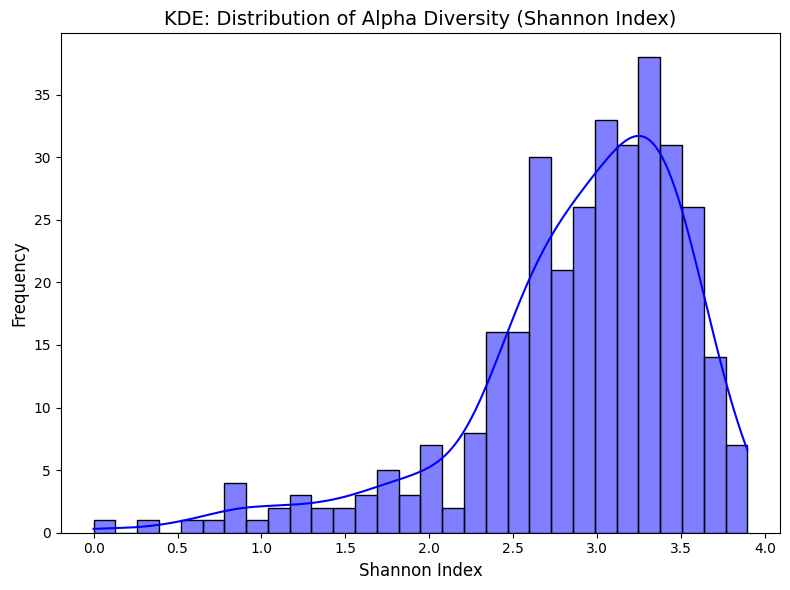

'global_resources/alpha_diversity_histogram.png'

In [83]:
# Histogram of Shannon Index (Alpha Diversity)
plt.figure(figsize=(8, 6))
sns.histplot(ad_df["Alpha Diversity (Shannon Index)"], bins=30, kde=True, color='blue')
plt.title("KDE: Distribution of Alpha Diversity (Shannon Index)", fontsize=14)
plt.xlabel("Shannon Index", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
sns.histplot(ad_df["Alpha Diversity (Shannon Index)"], bins=30, kde=True, color='blue')
plt.title("KDE: Distribution of Alpha Diversity (Shannon Index)", fontsize=14)
plt.xlabel("Shannon Index", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.tight_layout()

# Save the plot to a file
output_hist_path = f'global_resources{os.sep}alpha_diversity_histogram.png'
plt.savefig(output_hist_path, dpi=300)
plt.close()

output_hist_path

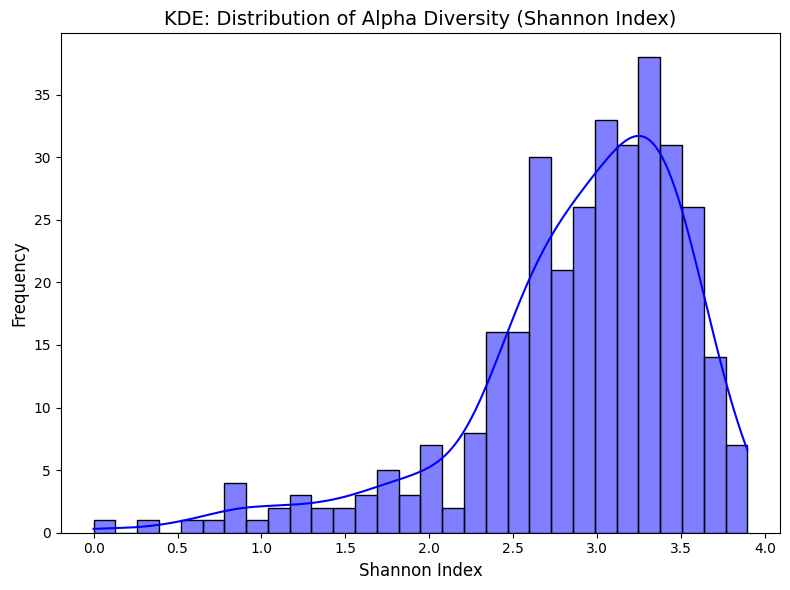

'global_resources/alpha_diversity_histogram.png'

In [84]:
# Histogram of Shannon Index (Alpha Diversity)
plt.figure(figsize=(8, 6))
sns.histplot(ad_df["Alpha Diversity (Shannon Index)"], bins=30, kde=True, color='blue')
plt.title("KDE: Distribution of Alpha Diversity (Shannon Index)", fontsize=14)
plt.xlabel("Shannon Index", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
sns.histplot(ad_df["Alpha Diversity (Shannon Index)"], bins=30, kde=True, color='blue')
plt.title("KDE: Distribution of Alpha Diversity (Shannon Index)", fontsize=14)
plt.xlabel("Shannon Index", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.tight_layout()

# Save the plot to a file
output_hist_path = f'global_resources{os.sep}alpha_diversity_histogram.png'
plt.savefig(output_hist_path, dpi=300)
plt.close()

output_hist_path

In [85]:
from skbio.diversity import beta_diversity

def calculate_and_save_beta_diversity(df, sample_ids, method="braycurtis", output_filename=None):
    """
    Calculate beta diversity for a subset of samples and save the results to a file if specified.
    
    Parameters:
        df (pd.DataFrame): Input DataFrame with microbial data.
        sample_ids (list): List of sample IDs to filter.
        method (str): Beta diversity metric to use (default is 'braycurtis').
        output_filename (str): Path to save the beta diversity DataFrame (default is None, which skips saving).
        
    Returns:
        pd.DataFrame: Beta diversity DataFrame (square distance matrix).
    """
    # Filter the DataFrame based on sample IDs
    filtered_df = df[df.index.isin(sample_ids)]
    print(f"Filtered DataFrame Shape: {filtered_df.shape}")
    
    # Calculate beta diversity
    sample_id = filtered_df.index
    bc_dm = beta_diversity(method, filtered_df.values, ids=sample_id)
    bc_df = pd.DataFrame(bc_dm.data, index=bc_dm.ids, columns=bc_dm.ids)
    
    # Save to CSV if a filename is provided
    if output_filename:
        bc_df.to_csv(output_filename, index=False)
        print(f"Beta Diversity results saved to {output_filename}")
    
    return bc_df

# Full dataset
bc_df = calculate_and_save_beta_diversity(
    filtered_mph_matching_df_t,
    filtered_mph_matching_df_t.index.tolist(),
    output_filename=f"global_resources{os.sep}bc_df.csv"
)
print("\nBeta Diversity (Bray-Curtis Dissimilarity) for Full Dataset:")
print(bc_df)

# Train dataset
bc_df_tr = calculate_and_save_beta_diversity(
    filtered_mph_matching_df_t,
    train_sample_ids,
    output_filename=f"local_resources{os.sep}experiment{experiment_number:02}{os.sep}biostatistics{os.sep}bc_df_tr.csv"
)
print("\nBeta Diversity (Bray-Curtis Dissimilarity) for Train Dataset:")
print(bc_df_tr)

# Test dataset
bc_df_tt = calculate_and_save_beta_diversity(
    filtered_mph_matching_df_t,
    test_sample_ids,
    output_filename=f"local_resources{os.sep}experiment{experiment_number:02}{os.sep}biostatistics{os.sep}bc_df_tt.csv"
)
print("\nBeta Diversity (Bray-Curtis Dissimilarity) for Test Dataset:")
print(bc_df_tt)

Filtered DataFrame Shape: (335, 940)
Beta Diversity results saved to global_resources/bc_df.csv

Beta Diversity (Bray-Curtis Dissimilarity) for Full Dataset:
          DC001     DC002     DC003     DC004     DC005     DC006     DC007  \
DC001  0.000000  0.643103  0.494985  0.668307  0.500148  0.444798  0.492854   
DC002  0.643103  0.000000  0.337175  0.316846  0.316432  0.396707  0.364480   
DC003  0.494985  0.337175  0.000000  0.473713  0.263922  0.398276  0.236307   
DC004  0.668307  0.316846  0.473713  0.000000  0.436897  0.362643  0.446416   
DC005  0.500148  0.316432  0.263922  0.436897  0.000000  0.391218  0.314184   
...         ...       ...       ...       ...       ...       ...       ...   
FB443  0.772637  0.796514  0.749373  0.876250  0.769026  0.814249  0.775815   
FB444  0.775156  0.839791  0.765074  0.901218  0.747771  0.815115  0.769177   
FB445  0.912875  0.820395  0.833680  0.888483  0.831408  0.884409  0.876363   
FB446  0.963617  0.831321  0.878053  0.859737  0.845

In [86]:
from skbio.diversity import beta_diversity
import pandas as pd

# Define beta diversity metrics to calculate
beta_measure_list = ["braycurtis", "jaccard", "canberra"]

# Initialize an empty list to store results
all_beta_div_results = []

# Loop through metrics and calculate beta diversity
for beta_measure in beta_measure_list:
    # Calculate beta diversity for the current metric
    beta_matrix = beta_diversity(
        metric=beta_measure,
        counts=filtered_mph_matching_df_t.values,
        ids=filtered_mph_matching_df_t.index.tolist(),
    )
    
    # Convert the distance matrix to a DataFrame
    beta_df = beta_matrix.to_data_frame()
    
    # Rename columns to include the metric name
    beta_df.columns = [f"{beta_measure}_{col}" for col in beta_df.columns]
    
    # Append the result to the list
    all_beta_div_results.append(beta_df)

# Combine all results into a single DataFrame
combined_beta_div_df = pd.concat(all_beta_div_results, axis=1)

# Remove duplicate columns if necessary
combined_beta_div_df = combined_beta_div_df.loc[:, ~combined_beta_div_df.columns.duplicated()]

# Display combined results
print("\nCombined Beta Diversity Metrics:")
combined_beta_div_df


Combined Beta Diversity Metrics:


,braycurtis_DC001,braycurtis_DC002,braycurtis_DC003,braycurtis_DC004,braycurtis_DC005,braycurtis_DC006,braycurtis_DC007,braycurtis_DC008,braycurtis_DC009,braycurtis_DC010,...,canberra_FB437,canberra_FB438,canberra_FB439,canberra_FB441,canberra_FB442,canberra_FB443,canberra_FB444,canberra_FB445,canberra_FB446,canberra_FB448
DC001,0.000000,0.643103,0.494985,0.668307,0.500148,0.444798,0.492854,0.497710,0.736109,0.596560,...,35.720561,121.364165,71.828279,165.239564,100.137246,119.138390,118.333847,95.061015,113.677370,74.157809
DC002,0.643103,0.000000,0.337175,0.316846,0.316432,0.396707,0.364480,0.363080,0.316974,0.258380,...,76.829546,148.019834,102.911872,182.702120,114.919194,134.134505,140.976635,116.506198,136.249493,108.463112
DC003,0.494985,0.337175,0.000000,0.473713,0.263922,0.398276,0.236307,0.326517,0.514070,0.312875,...,73.851119,144.404393,98.679067,173.611986,113.303922,131.651433,139.725612,113.063879,132.338161,102.727156
DC004,0.668307,0.316846,0.473713,0.000000,0.436897,0.362643,0.446416,0.425975,0.373689,0.397113,...,41.000000,128.694546,72.052417,165.780706,99.086939,122.398380,120.102418,97.011603,114.066525,83.110478
DC005,0.500148,0.316432,0.263922,0.436897,0.000000,0.391218,0.314184,0.240515,0.452632,0.301450,...,77.808744,147.490650,103.062622,175.900183,117.341291,133.931549,137.088198,115.940697,139.478953,106.947796
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FB443,0.772637,0.796514,0.749373,0.876250,0.769026,0.814249,0.775815,0.786866,0.843514,0.772193,...,121.490670,167.770546,136.719114,200.741255,145.979143,0.000000,92.871359,149.756841,171.939866,142.224116
FB444,0.775156,0.839791,0.765074,0.901218,0.747771,0.815115,0.769177,0.787585,0.866155,0.803643,...,117.961892,167.324947,135.741633,201.725342,144.779384,92.871359,0.000000,147.619906,164.825441,138.705567
FB445,0.912875,0.820395,0.833680,0.888483,0.831408,0.884409,0.876363,0.877615,0.870110,0.852263,...,87.393966,118.159827,88.310041,187.628764,118.080739,149.756841,147.619906,0.000000,124.921936,90.448572
FB446,0.963617,0.831321,0.878053,0.859737,0.845236,0.944040,0.880097,0.842805,0.910949,0.833863,...,100.769739,130.093401,111.530991,215.036188,131.759275,171.939866,164.825441,124.921936,0.000000,107.292205


In [87]:
# Splitting bc_df into hc (healthy control) and ad (Alzheimer's patients) DataFrames
# hc_ids, ad_ids
hc_ids = clinical_microbiome_df[clinical_microbiome_df['Alzheimers'] == 0.0]['Sample ID']
ad_ids = clinical_microbiome_df[clinical_microbiome_df['Alzheimers'] == 1.0]['Sample ID']

# Creating bc_df_hc and bc_df_ad using the sample IDs from filtered_training_clinical_df
bc_df_hc = bc_df.loc[bc_df.index.intersection(hc_ids), bc_df.columns.intersection(hc_ids)]
bc_df_ad = bc_df.loc[bc_df.index.intersection(ad_ids), bc_df.columns.intersection(ad_ids)]

# Display the resulting DataFrames
bc_df_hc.head()

,DC001,DC002,DC003,DC004,DC005,DC006,DC007,DC008,DC009,DC010,...,FB432,FB433,FB435,FB437,FB438,FB441,FB443,FB444,FB445,FB448
DC001,0.000000,0.643103,0.494985,0.668307,0.500148,0.444798,0.492854,0.497710,0.736109,0.596560,...,0.970291,0.964411,0.905736,0.916550,0.877182,0.846224,0.772637,0.775156,0.912875,0.831610
DC002,0.643103,0.000000,0.337175,0.316846,0.316432,0.396707,0.364480,0.363080,0.316974,0.258380,...,0.967715,0.962753,0.976113,0.991377,0.868827,0.838692,0.796514,0.839791,0.820395,0.869797
DC003,0.494985,0.337175,0.000000,0.473713,0.263922,0.398276,0.236307,0.326517,0.514070,0.312875,...,0.956485,0.950605,0.966066,0.985123,0.855515,0.816215,0.749373,0.765074,0.833680,0.836330
DC004,0.668307,0.316846,0.473713,0.000000,0.436897,0.362643,0.446416,0.425975,0.373689,0.397113,...,0.972776,0.967145,0.987536,1.000000,0.911796,0.878189,0.876250,0.901218,0.888483,0.926642
DC005,0.500148,0.316432,0.263922,0.436897,0.000000,0.391218,0.314184,0.240515,0.452632,0.301450,...,0.939319,0.933397,0.970191,0.988475,0.867440,0.815636,0.769026,0.747771,0.831408,0.844943


In [88]:
# hc_ids ad_ids
combined_alpha_div_df_hc = combined_alpha_div_df[combined_alpha_div_df["Sample ID"].isin(hc_ids)]
combined_alpha_div_df_ad = combined_alpha_div_df[~combined_alpha_div_df["Sample ID"].isin(hc_ids)]

combined_alpha_div_df_hc.shape, combined_alpha_div_df_ad.shape
combined_alpha_div_df_hc

,Sample ID,Alpha Diversity (Shannon Index),Alpha Diversity (Simpson Index),Alpha Diversity (Berger_parker_d Index)
0,DC001,2.519907,0.881144,0.207141
1,DC002,3.451174,0.955258,0.104616
2,DC003,3.385870,0.951319,0.122270
3,DC004,2.834624,0.924893,0.150096
4,DC005,3.290396,0.932922,0.203456
...,...,...,...,...
328,FB441,3.891149,0.966766,0.080735
330,FB443,3.560865,0.948860,0.143986
331,FB444,3.401113,0.946262,0.107723
332,FB445,3.300568,0.933426,0.189150


In [89]:
# hc_ids ad_ids
# combined_alpha_div_df_hc = combined_alpha_div_df[combined_alpha_div_df["Sample ID"].isin(hc_ids)]
# combined_alpha_div_df_ad = combined_alpha_div_df[~combined_alpha_div_df["Sample ID"].isin(hc_ids)]

# combined_alpha_div_df_hc.shape, combined_alpha_div_df_ad.shape

combined_beta_div_df_hc = combined_beta_div_df[combined_beta_div_df.index.isin(hc_ids)]
combined_beta_div_df_ad = combined_beta_div_df[~combined_beta_div_df.index.isin(hc_ids)]
combined_beta_div_df_hc.shape, combined_beta_div_df_ad.shape
combined_beta_div_df_hc

,braycurtis_DC001,braycurtis_DC002,braycurtis_DC003,braycurtis_DC004,braycurtis_DC005,braycurtis_DC006,braycurtis_DC007,braycurtis_DC008,braycurtis_DC009,braycurtis_DC010,...,canberra_FB437,canberra_FB438,canberra_FB439,canberra_FB441,canberra_FB442,canberra_FB443,canberra_FB444,canberra_FB445,canberra_FB446,canberra_FB448
DC001,0.000000,0.643103,0.494985,0.668307,0.500148,0.444798,0.492854,0.497710,0.736109,0.596560,...,35.720561,121.364165,71.828279,165.239564,100.137246,119.138390,118.333847,95.061015,113.677370,74.157809
DC002,0.643103,0.000000,0.337175,0.316846,0.316432,0.396707,0.364480,0.363080,0.316974,0.258380,...,76.829546,148.019834,102.911872,182.702120,114.919194,134.134505,140.976635,116.506198,136.249493,108.463112
DC003,0.494985,0.337175,0.000000,0.473713,0.263922,0.398276,0.236307,0.326517,0.514070,0.312875,...,73.851119,144.404393,98.679067,173.611986,113.303922,131.651433,139.725612,113.063879,132.338161,102.727156
DC004,0.668307,0.316846,0.473713,0.000000,0.436897,0.362643,0.446416,0.425975,0.373689,0.397113,...,41.000000,128.694546,72.052417,165.780706,99.086939,122.398380,120.102418,97.011603,114.066525,83.110478
DC005,0.500148,0.316432,0.263922,0.436897,0.000000,0.391218,0.314184,0.240515,0.452632,0.301450,...,77.808744,147.490650,103.062622,175.900183,117.341291,133.931549,137.088198,115.940697,139.478953,106.947796
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FB441,0.846224,0.838692,0.816215,0.878189,0.815636,0.878494,0.843422,0.839845,0.868328,0.832527,...,163.127487,217.697554,185.721688,0.000000,186.959052,200.741255,201.725342,187.628764,215.036188,188.980074
FB443,0.772637,0.796514,0.749373,0.876250,0.769026,0.814249,0.775815,0.786866,0.843514,0.772193,...,121.490670,167.770546,136.719114,200.741255,145.979143,0.000000,92.871359,149.756841,171.939866,142.224116
FB444,0.775156,0.839791,0.765074,0.901218,0.747771,0.815115,0.769177,0.787585,0.866155,0.803643,...,117.961892,167.324947,135.741633,201.725342,144.779384,92.871359,0.000000,147.619906,164.825441,138.705567
FB445,0.912875,0.820395,0.833680,0.888483,0.831408,0.884409,0.876363,0.877615,0.870110,0.852263,...,87.393966,118.159827,88.310041,187.628764,118.080739,149.756841,147.619906,0.000000,124.921936,90.448572


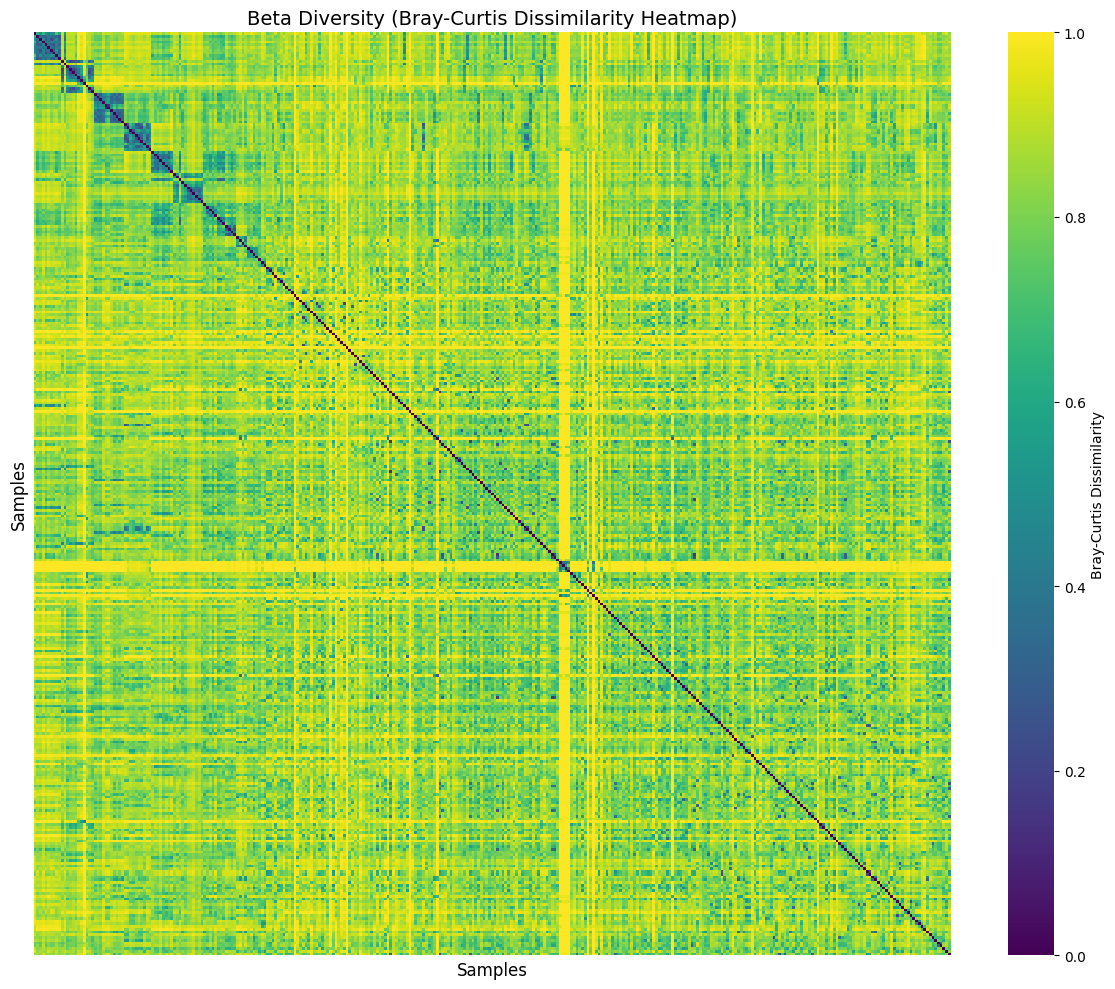

'global_resources/beta_diversity_heatmap.png'

In [90]:
# Create a heatmap for the Bray-Curtis Dissimilarity matrix
plt.figure(figsize=(12, 10))
sns.heatmap(bc_df, cmap='viridis', xticklabels=False, yticklabels=False, cbar_kws={'label': 'Bray-Curtis Dissimilarity'})
plt.title("Beta Diversity (Bray-Curtis Dissimilarity Heatmap)", fontsize=14)
plt.xlabel("Samples", fontsize=12)
plt.ylabel("Samples", fontsize=12)
plt.tight_layout()
plt.show()

# Save the Bray-Curtis Dissimilarity Heatmap as an image file
plt.figure(figsize=(12, 10))
sns.heatmap(bc_df, cmap='viridis', xticklabels=False, yticklabels=False, cbar_kws={'label': 'Bray-Curtis Dissimilarity'})
plt.title("Beta Diversity (Bray-Curtis Dissimilarity Heatmap)", fontsize=14)
plt.xlabel("Samples", fontsize=12)
plt.ylabel("Samples", fontsize=12)
plt.tight_layout()

# Save the plot to a file
output_path = f'global_resources{os.sep}beta_diversity_heatmap.png'
plt.savefig(output_path, dpi=300)
plt.close()

output_path

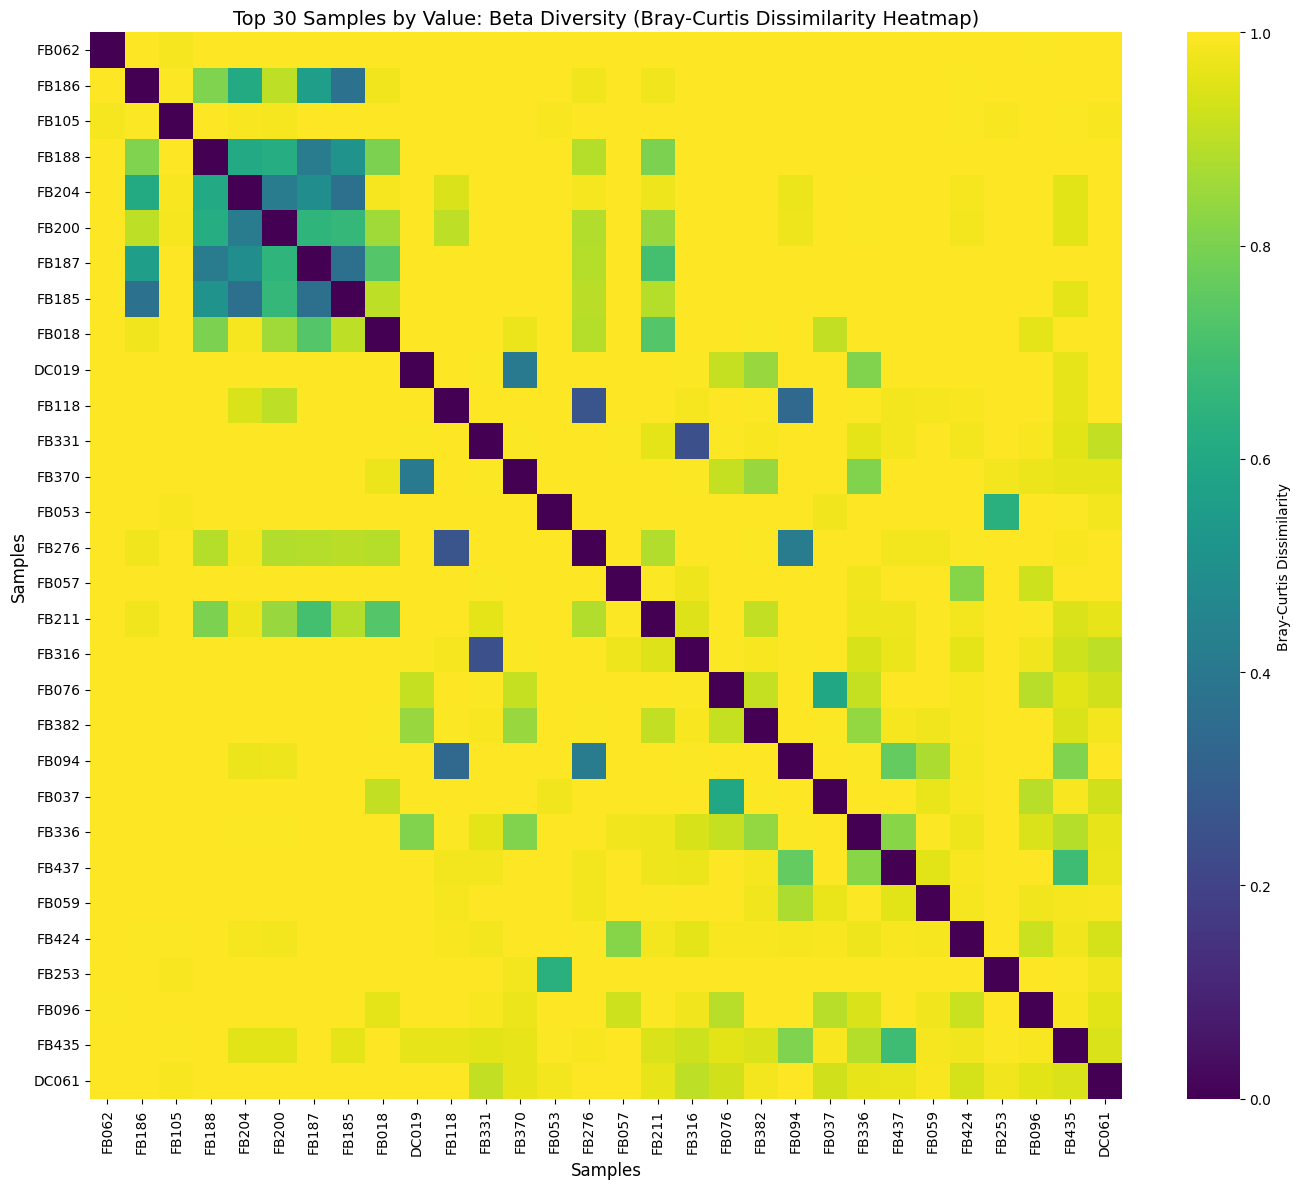

Heatmap saved to: global_resources/top_30_beta_diversity_heatmap.png


In [91]:
# Calculate aggregate scores (e.g., mean) for each sample
sample_scores = bc_df.mean(axis=1)  # Replace `.mean()` with `.sum()` or `.max()` if desired

# Select the top 30 samples by value
top_30_samples = sample_scores.nlargest(30).index

# Subset the matrix to include only the top 30 rows and columns
top_30_matrix = bc_df.loc[top_30_samples, top_30_samples]

# Create the heatmap for the top 30 samples
plt.figure(figsize=(14, 12))
sns.heatmap(
    top_30_matrix,
    cmap='viridis',
    xticklabels=True,
    yticklabels=True,
    cbar_kws={'label': 'Bray-Curtis Dissimilarity'}
)
plt.title("Top 30 Samples by Value: Beta Diversity (Bray-Curtis Dissimilarity Heatmap)", fontsize=14)
plt.xlabel("Samples", fontsize=12)
plt.ylabel("Samples", fontsize=12)
plt.tight_layout()
plt.show()

# Save the heatmap to a file
output_path = f'global_resources{os.sep}top_30_beta_diversity_heatmap.png'
plt.savefig(output_path, dpi=300)
plt.close()

print(f"Heatmap saved to: {output_path}")

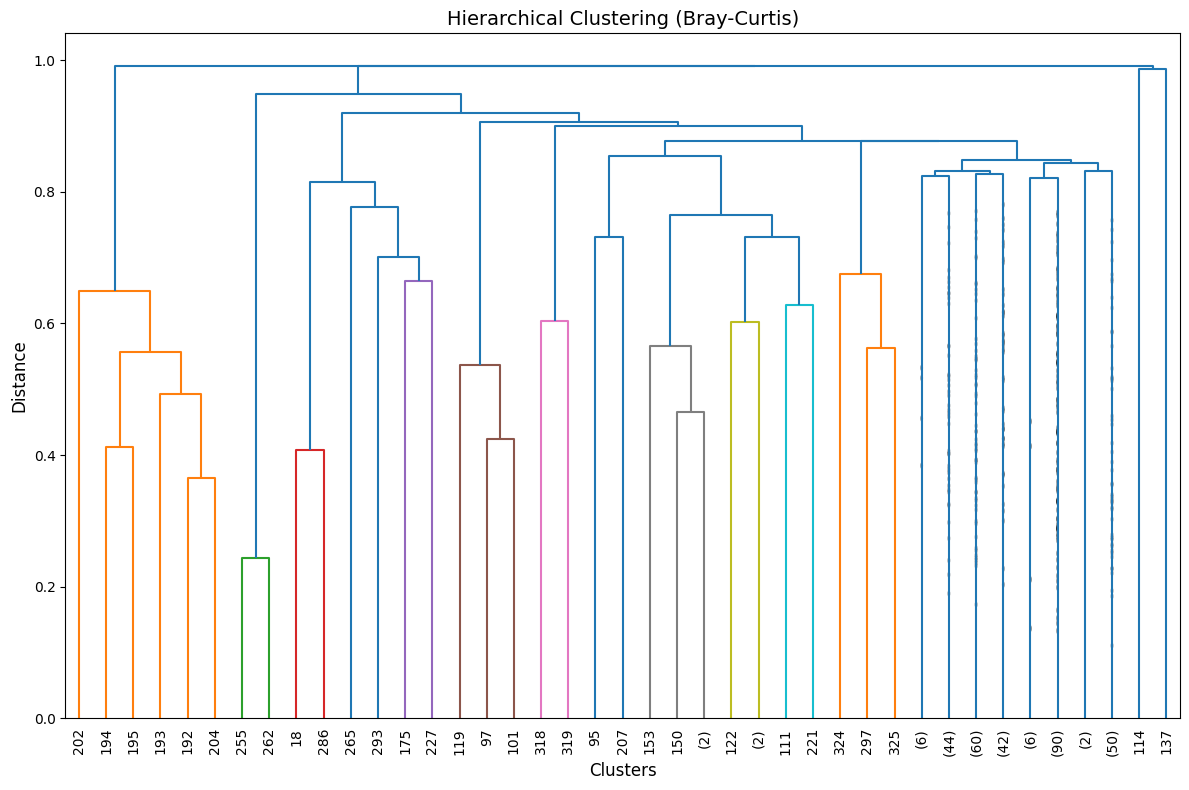

'global_resources/beta_diversity_hierarchical_clustering_dendrogram.png'

In [92]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt

# Convert the square distance matrix to condensed format
condensed_dm = squareform(bc_df.values)

# Perform hierarchical clustering
linkage_matrix = linkage(condensed_dm, method='average')

# Plot the dendrogram with truncated labels
plt.figure(figsize=(12, 8))
dendrogram(
    linkage_matrix,
    truncate_mode='level',  # Show only top-level clusters
    p=10,                   # Number of levels to show
    leaf_rotation=90,
    leaf_font_size=10,
    show_contracted=True    # Indicate where clusters are truncated
)
plt.title("Hierarchical Clustering (Bray-Curtis)", fontsize=14)
plt.xlabel("Clusters", fontsize=12)
plt.ylabel("Distance", fontsize=12)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
dendrogram(
    linkage_matrix,
    truncate_mode='level',  # Show only top-level clusters
    p=10,                   # Number of levels to show
    leaf_rotation=90,
    leaf_font_size=10,
    show_contracted=True    # Indicate where clusters are truncated
)
plt.title("Hierarchical Clustering (Bray-Curtis)", fontsize=14)
plt.xlabel("Clusters", fontsize=12)
plt.ylabel("Distance", fontsize=12)
plt.tight_layout()

# Save the plot to a file
output_path = f'global_resources{os.sep}beta_diversity_hierarchical_clustering_dendrogram.png'
plt.savefig(output_path, dpi=300)
plt.close()

output_path

In [93]:
print(clinical_microbiome_tr.shape, clinical_microbiome_tr['Alzheimers'].value_counts())
clinical_microbiome_tr.head()

(252, 1050) 0.0    170
1.0     82
Name: Alzheimers, dtype: int64


,Sample ID,study_id,day,Date Sample,age,age_cat,male,abx6mo,hopsn,malnutrition_indicator_sco,...,Aerococcus sp HMSC035B07,Actinomyces oricola,Citrobacter werkmanii,Bifidobacterium angulatum,Fructilactobacillus fructivorans,Schaalia meyeri,Ndongobacter massiliensis,Actinomyces radicidentis,Candida tropicalis,GGB3297 SGB4356
0,DC071,CH1-002,0.0,2016-07-15,93.0,3.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,DC013,CH1-003,0.0,2016-07-12,68.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,DC019,CH1-003,18.0,2016-07-30,68.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,DC014,CH1-003,20.0,2016-08-01,68.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,DC015,CH1-003,23.0,2016-08-04,68.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [94]:
# Splitting bc_df into hc (healthy control) and ad (Alzheimer's patients) DataFrames
hc_ids_tr = clinical_microbiome_tr[clinical_microbiome_tr['Alzheimers'] == 0.0]['Sample ID']
ad_ids_tr = clinical_microbiome_tr[clinical_microbiome_tr['Alzheimers'] == 1.0]['Sample ID']

# Creating bc_df_hc and bc_df_ad using the sample IDs from filtered_training_clinical_df
bc_df_hc_tr = bc_df_tr.loc[bc_df_tr.index.intersection(hc_ids_tr), bc_df_tr.columns.intersection(hc_ids_tr)]
bc_df_ad_tr = bc_df_tr.loc[bc_df_tr.index.intersection(ad_ids_tr), bc_df_tr.columns.intersection(ad_ids_tr)]

# Display the resulting DataFrames
bc_df_hc_tr.head()

,DC001,DC002,DC003,DC004,DC005,DC006,DC007,DC008,DC009,DC010,...,FB432,FB433,FB435,FB437,FB438,FB441,FB443,FB444,FB445,FB448
DC001,0.000000,0.643103,0.494985,0.668307,0.500148,0.444798,0.492854,0.497710,0.736109,0.596560,...,0.970291,0.964411,0.905736,0.916550,0.877182,0.846224,0.772637,0.775156,0.912875,0.831610
DC002,0.643103,0.000000,0.337175,0.316846,0.316432,0.396707,0.364480,0.363080,0.316974,0.258380,...,0.967715,0.962753,0.976113,0.991377,0.868827,0.838692,0.796514,0.839791,0.820395,0.869797
DC003,0.494985,0.337175,0.000000,0.473713,0.263922,0.398276,0.236307,0.326517,0.514070,0.312875,...,0.956485,0.950605,0.966066,0.985123,0.855515,0.816215,0.749373,0.765074,0.833680,0.836330
DC004,0.668307,0.316846,0.473713,0.000000,0.436897,0.362643,0.446416,0.425975,0.373689,0.397113,...,0.972776,0.967145,0.987536,1.000000,0.911796,0.878189,0.876250,0.901218,0.888483,0.926642
DC005,0.500148,0.316432,0.263922,0.436897,0.000000,0.391218,0.314184,0.240515,0.452632,0.301450,...,0.939319,0.933397,0.970191,0.988475,0.867440,0.815636,0.769026,0.747771,0.831408,0.844943


In [95]:
# Splitting bc_df into hc (healthy control) and ad (Alzheimer's patients) DataFrames
hc_ids_tt = clinical_microbiome_tt[clinical_microbiome_tt['Alzheimers'] == 0.0]['Sample ID']
ad_ids_tt = clinical_microbiome_tt[clinical_microbiome_tt['Alzheimers'] == 1.0]['Sample ID']

# Creating bc_df_hc and bc_df_ad using the sample IDs from filtered_training_clinical_df
bc_df_hc_tt = bc_df_tt.loc[bc_df_tt.index.intersection(hc_ids_tt), bc_df_tt.columns.intersection(hc_ids_tt)]
bc_df_ad_tt = bc_df_tt.loc[bc_df_tt.index.intersection(ad_ids_tt), bc_df_tt.columns.intersection(ad_ids_tt)]

# Display the resulting DataFrames
bc_df_hc_tt.head()

,DC029,DC032,DC059,DC060,DC061,DC062,DC074,DC102,FB003,FB049,FB058,FB064,FB152,FB223,FB344
DC029,0.000000,0.611545,0.865599,0.873894,0.940386,0.886406,0.769706,0.780316,0.917931,0.790556,0.828107,0.964516,0.844092,0.882632,0.768368
DC032,0.611545,0.000000,0.837788,0.847246,0.875055,0.778776,0.766058,0.891951,0.827422,0.851138,0.895785,0.864244,0.782765,0.792133,0.815495
DC059,0.865599,0.837788,0.000000,0.239782,0.452721,0.359553,0.782643,0.822305,0.744413,0.867608,0.927483,0.923264,0.748871,0.867882,0.847090
DC060,0.873894,0.847246,0.239782,0.000000,0.316886,0.378708,0.805070,0.817087,0.756386,0.871764,0.919949,0.932790,0.789372,0.887294,0.851856
DC061,0.940386,0.875055,0.452721,0.316886,0.000000,0.495660,0.874406,0.870248,0.757665,0.905735,0.943348,0.928889,0.848210,0.920597,0.885946


In [96]:
bacteria_df

,taxonomy_hierarchy,genus_name,species_name,species_description,feature_description_down_sized
0,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,Faecalibacterium,Faecalibacterium prausnitzii,**Description:** \nFaecalibacterium prausnitz...,Faecalibacterium prausnitzii is a prominent me...
1,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,Fusicatenibacter,Fusicatenibacter saccharivorans,**Description:** \nFusicatenibacter_sacchariv...,Fusicatenibacter_saccharivorans is a bacterium...
2,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,Ruminococcaceae_unclassified,Eubacterium siraeum,**Description:** \nEubacterium siraeum is a b...,Eubacterium siraeum is a bacterium classified ...
3,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,Gemmiger,Gemmiger formicilis,**Description:** \nGemmiger formicilis is a b...,Gemmiger formicilis is a bacterium classified ...
4,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,Lachnospiraceae_unclassified,Eubacterium rectale,**Description:** \nEubacterium rectale is a s...,Eubacterium rectale is a prominent member of t...
...,...,...,...,...,...
935,k__Bacteria|p__Actinobacteria|c__Actinobacteri...,Schaalia,Schaalia meyeri,**Description:** \nSchaalia meyeri is a bacte...,Schaalia meyeri is a bacterium classified unde...
936,k__Bacteria|p__Firmicutes|c__Firmicutes_unclas...,Ndongobacter,Ndongobacter massiliensis,**Description:** \nNdongobacter_massiliensis ...,k__Bacteria|p__Firmicutes|o__Firmutes_unclassi...
937,k__Bacteria|p__Actinobacteria|c__Actinobacteri...,Actinomyces,Actinomyces radicidentis,**Description:** \nActinomyces radicidentis i...,Actinomyces radicidentis is a bacterium classi...
938,k__Eukaryota|p__Ascomycota|c__Saccharomycetes|...,Candida,Candida tropicalis,**Description:** \nCandida tropicalis is a eu...,Candida tropicalis is a eukaryotic fungus belo...


In [97]:
def normalize_text(text):
    """Converts text to lowercase, retains periods, removes other punctuation, and normalizes spaces."""
    import re
    text = text.lower()
    # Remove punctuation except periods
    text = re.sub(r'[^\w\s.]', '', text)  # Retain periods
    return ' '.join(text.split())
# Print the top 1 record
print(normalize_text(bacteria_df['species_description'].iloc[0])) # Retrieve the first record
print("-----------")

# Print the top 2 record
print(normalize_text(bacteria_df['species_description'].iloc[1])) # Retrieve the second record
print("-----------")

# Print the top 2 record
print(normalize_text(bacteria_df['species_description'].iloc[800]))  # Retrieve the second record
print("-----------")

# Print the top 1 record
print(normalize_text(bacteria_df['species_description'].iloc[900]))  # Retrieve the first record
print("-----------")

# Print the top 1 record
print(normalize_text(bacteria_df['species_description'].iloc[912]))  # Retrieve the first record
print("-----------")

# Print the top 2 record
print(normalize_text(bacteria_df['species_description'].iloc[924]))  # Retrieve the second record

description faecalibacterium prausnitzii is a prominent member of the human gut microbiome classified under the phylum firmicutes class clostridia order clostridiales family ruminococcaceae and genus faecalibacterium. this bacterium is known for its significant role in producing butyrate a shortchain fatty acid that serves as an energy source for colonocytes and has antiinflammatory properties. decreased levels of f. prausnitzii have been associated with various gastrointestinal disorders and inflammatory conditions. in the context of alzheimers disease ad emerging evidence suggests that alterations in gut microbiota including reduced abundance of f. prausnitzii may influence neuroinflammation and cognitive decline. the bacteriums ability to modulate inflammation and produce metabolites that affect gutbrain communication highlights its potential relevance in ad pathology. furthermore f. prausnitziis presence is inversely correlated with cognitive impairment suggesting that maintaining 

In [98]:
len(filtered_mph_matching_df_t.columns.tolist())

940

In [99]:
data_dictionary=pd.read_csv(f"..{os.sep}data{os.sep}column_names.csv")
data_dictionary

,Column Names
0,Sample ID
1,study_id
2,day
3,Date Sample
4,age
...,...
1145,Ndongobacter massiliensis
1146,Actinomyces radicidentis
1147,Candida tropicalis
1148,Lachnospiraceae bacterium 10 1


In [100]:
clinical_dict_df = pd.read_excel(glob(f"..{os.sep}data{os.sep}*clinical_data_dictionary.xlsx")[0])
clinical_dict_df

,Feature Name,Feature Notes,Feature Description,Feature Group
0,ID Match,Identifier for patient or participant matching...,Identifier for patient or participant matching...,Study Identification
1,Sample ID,Unique Sample Identifier,Unique identifier for biological or clinical s...,Study Identification
2,Version 2,If there is a second metaphlan file,Version control for data entry or survey.,Study Identification
3,Version 3,If there is a third metaphlan file,Updated version for data entry or survey.,Study Identification
4,study_id,Unique ID number for each elder,Identifier for the specific study or research ...,Study Identification
...,...,...,...,...
112,Severe Liver disease,Each medical problem Y/N,Advanced liver disease diagnosis.,Hepatic Condition
113,ostomy,Each medical problem Y/N,Presence of an ostomy.,Surgical History
114,Alzheimers,Each medical problem Y/N,Diagnosis of Alzheimer's disease.,Neurological Condition
115,Dementia Other,Each medical problem Y/N,Other forms of dementia.,Neurological Condition


In [101]:
# Test the function
test_query = "what is alzheimer's disease"

results = query_vector_db(
    query_text=test_query,
    top_k=5,
    similarity_threshold=0.75
)
 
if results:
    print(f"\nMessage: {results.get('message')}")
    print("\nFull Context:")
    print(results.get('context', ''))


Message: Found 5 relevant context entries

Full Context:
Database: chroma_db1
Source: PMC8599320.xml
Content: will need to obtain permission directly from the copyright holder. to view a copy of this licence, visit http://creativecommons.org/licenses/by/4.0/. alzheimer's disease (ad) is a progressive neurodegenerative disorder of the central nervous system (cns) leading to mental deterioration and devastation, and eventually a fatal outcome. ad affects mostly the elderly. ad is frequently accompanied by hypercholesterolemia, hypertension, atherosclerosis, and diabetes mellitus, and these are significant risk factors of ad. other conditions triggered by the progression of ad include psychosis, sleep disorders, epilepsy, and depression. one important comorbidity is down’s syndrome, which directly contributes to the severity and rapid progression of ad. the development of new therapeutic strategies for ad includes the repurposing of drugs currently used for the treatment of comorbidities

In [102]:
clinical_dict_df[clinical_dict_df['Feature Name'].isin(selected_feature_names)]

,Feature Name,Feature Notes,Feature Description,Feature Group
12,age_cat,"categorized age (i.e. 1=65-74, 2=75-84, 3=85-9...",Age category or grouping for analysis.,Demographic Information
13,male,male = 1,Binary indicator for male gender.,Demographic Information
15,hopsn,How many times hospitalized in past year,Hospitalization status or related information.,Clinical Status
16,malnutrition_indicator_sco,Malnutrition Category (1-3 with 3 being malnou...,Score indicating malnutrition status.,Clinical Assessment
17,clinical_frailty_scale,Clinical Frailty Scale = Frailty into 9 catego...,Scale to measure clinical frailty.,Clinical Assessment
19,PPI,Each medication class Y/N,Use of proton pump inhibitors.,Medication History
28,Beta blockers,Each medication class Y/N,Use of beta-adrenergic blocking agents.,Cardiovascular Medication
34,SSRIs,Each medication class Y/N,Use of selective serotonin reuptake inhibitors...,Psychiatric Medication
50,Anticoagulation,Each medication class Y/N,Blood-thinning medication use.,Blood/Coagulation Management
56,Loop diuretics,Each medication class Y/N,Affects the kidneys' loop of Henle.,Fluid Regulation Medication


In [103]:
selected_bacteria_explanation_df = bacteria_df[bacteria_df['species_name'].isin(selected_feature_names)]
selected_bacteria_explanation_df

,taxonomy_hierarchy,genus_name,species_name,species_description,feature_description_down_sized
0,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,Faecalibacterium,Faecalibacterium prausnitzii,**Description:** \nFaecalibacterium prausnitz...,Faecalibacterium prausnitzii is a prominent me...
3,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,Gemmiger,Gemmiger formicilis,**Description:** \nGemmiger formicilis is a b...,Gemmiger formicilis is a bacterium classified ...
4,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,Lachnospiraceae_unclassified,Eubacterium rectale,**Description:** \nEubacterium rectale is a s...,Eubacterium rectale is a prominent member of t...
6,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,Lachnospiraceae_unclassified,Lachnospiraceae bacterium WCA3 601 WT 6H,**Description:** \nLachnospiraceae_bacterium_...,Lachnospiraceae bacterium is part of the gut m...
7,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o_...,Alistipes,Alistipes putredinis,**Description:** \nAlistipes putredinis is a ...,Alistipes putredinis is a bacterium classified...
...,...,...,...,...,...
442,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o_...,Parabacteroides,Parabacteroides johnsonii,**Description:** \nParabacteroides johnsonii ...,Parabacteroides johnsonii is a bacterium class...
469,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o_...,Alistipes,Alistipes dispar,**Description:** \nAlistipes_dispar is a bact...,Alistipes_dispar is a bacterium classified und...
488,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,GGB3005,GGB3005 SGB3996,**Description:** \nGGB3005_SGB3996 is a bacte...,k__Bacteria|p__Firmicutes|o__Clostridia_unclas...
727,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactob...,Limosilactobacillus,Limosilactobacillus reuteri,**Description:** \nLimosilactobacillus reuter...,Limosilactobacillus reuteri is a species of la...


In [104]:
# clinical_variable_explanations_df.to_csv(f"..{os.sep}data{os.sep}clinical_variable_explanations_df.csv", index=False)
clinical_variable_explanations_df = pd.read_csv(f"..{os.sep}data{os.sep}clinical_variable_explanations_df.csv")
clinical_variable_explanations_df

,Feature Name,Feature Notes,Feature Group,Feature Description,Feature Explanation
0,ID Match,Identifier for patient or participant matching...,Study Identification,Identifier for patient or participant matching...,- **Feature Name:** ID Match\n\n - **Definiti...
1,Sample ID,Unique Sample Identifier,Study Identification,Unique identifier for biological or clinical s...,- **Feature Name:** Sample ID\n\n - **Definit...
2,Version 2,If there is a second metaphlan file,Study Identification,Version control for data entry or survey.,- **Feature Name:** Version 2\n\n - **Definit...
3,Version 3,If there is a third metaphlan file,Study Identification,Updated version for data entry or survey.,- **Feature Name:** Version 3\n\n - **Definit...
4,study_id,Unique ID number for each elder,Study Identification,Identifier for the specific study or research ...,- **Feature Name:** study_id\n\n - **Definiti...
...,...,...,...,...,...
112,Severe Liver disease,Each medical problem Y/N,Hepatic Condition,Advanced liver disease diagnosis.,- **Feature Name:** Severe Liver Disease\n\n ...
113,ostomy,Each medical problem Y/N,Surgical History,Presence of an ostomy.,- **Feature Name:** ostomy\n\n - **Definition...
114,Alzheimers,Each medical problem Y/N,Neurological Condition,Diagnosis of Alzheimer's disease.,- **Feature Name:** Alzheimers\n\n - **Defini...
115,Dementia Other,Each medical problem Y/N,Neurological Condition,Other forms of dementia.,- **Feature Name:** Dementia Other\n\n - **De...


In [105]:
selected_clinical_explanation_df = clinical_variable_explanations_df[clinical_variable_explanations_df['Feature Name'].isin(selected_feature_names)]
selected_clinical_explanation_df

,Feature Name,Feature Notes,Feature Group,Feature Description,Feature Explanation
12,age_cat,"categorized age (i.e. 1=65-74, 2=75-84, 3=85-9...",Demographic Information,Age category or grouping for analysis.,- **Feature Name:** age_cat\n\n - **Definitio...
13,male,male = 1,Demographic Information,Binary indicator for male gender.,- **Feature Name:** male\n\n - **Definition:*...
15,hopsn,How many times hospitalized in past year,Clinical Status,Hospitalization status or related information.,- **Feature Name:** hopsn\n\n - **Definition:...
16,malnutrition_indicator_sco,Malnutrition Category (1-3 with 3 being malnou...,Clinical Assessment,Score indicating malnutrition status.,- **Feature Name:** malnutrition_indicator_sco...
17,clinical_frailty_scale,Clinical Frailty Scale = Frailty into 9 catego...,Clinical Assessment,Scale to measure clinical frailty.,- **Feature Name:** clinical_frailty_scale\n\n...
19,PPI,Each medication class Y/N,Medication History,Use of proton pump inhibitors.,- **Feature Name:** PPI\n\n - **Definition:**...
28,Beta blockers,Each medication class Y/N,Cardiovascular Medication,Use of beta-adrenergic blocking agents.,- **Feature Name:** Beta blockers\n\n - **Def...
34,SSRIs,Each medication class Y/N,Psychiatric Medication,Use of selective serotonin reuptake inhibitors...,- **Feature Name:** SSRIs\n\n - **Definition:...
50,Anticoagulation,Each medication class Y/N,Blood/Coagulation Management,Blood-thinning medication use.,- **Feature Name:** Anticoagulation\n\n - **D...
56,Loop diuretics,Each medication class Y/N,Fluid Regulation Medication,Affects the kidneys' loop of Henle.,- **Feature Name:** Loop diuretics\n\n - **De...


In [106]:
print(clinical_variable_explanations_df["Feature Explanation"][clinical_variable_explanations_df['Feature Name']=='malnutrition_indicator_sco'].values[0])

- **Feature Name:** malnutrition_indicator_sco

  - **Definition:** The malnutrition_indicator_sco is a score that categorizes the nutritional status of a participant into three levels, with 1 indicating well-nourished, 2 indicating at risk of malnutrition, and 3 indicating malnourished. This score is derived from clinical assessments that evaluate various aspects of nutrition, including dietary intake, weight loss, and physical health indicators.

  - **Group Characteristics:** This feature is part of a clinical assessment framework, where participants are evaluated based on their nutritional status. The categorization allows for differentiation between individuals who are well-nourished, those who may be at risk, and those who are malnourished. This stratification can be crucial for understanding the health status of participants in studies, particularly in older adults who are more susceptible to malnutrition.

  - **Relevance to Research:** Malnutrition is a significant concern in 

In [107]:
combined_force_plot_test_df

,Sample ID,Study ID,Feature Name,Feature Value,SHAP Value,Predicted Percentage,Predicted Status
0,DC074,CH1-004,age_cat,3.00000,0.080925,0.282536,0
1,DC074,CH1-004,male,0.00000,0.009421,0.282536,0
2,DC074,CH1-004,hopsn,0.00000,0.159347,0.282536,0
3,DC074,CH1-004,malnutrition_indicator_sco,2.00000,0.564061,0.282536,0
4,DC074,CH1-004,clinical_frailty_scale,5.00000,-0.752709,0.282536,0
...,...,...,...,...,...,...,...
2305,FB267,CH1-132,Parabacteroides johnsonii,0.46032,0.039622,0.979824,1
2306,FB267,CH1-132,Alistipes dispar,0.00000,0.017202,0.979824,1
2307,FB267,CH1-132,GGB3005 SGB3996,0.01098,-0.159822,0.979824,1
2308,FB267,CH1-132,Limosilactobacillus reuteri,0.00000,0.000000,0.979824,1


In [108]:
# Fix column selection to avoid duplicates
ml_prediction = combined_force_plot_test_df[['Sample ID', 'Study ID', 'Predicted Percentage', 'Predicted Status']].drop_duplicates()

# Map Predicted Status values
ml_prediction['Predicted Status'] = ml_prediction['Predicted Status'].map({0: 'No', 1: 'Yes'})

# Reset index for clean DataFrame
ml_prediction.reset_index(drop=True, inplace=True)

# Filter rows where Sample ID is 'FB411'
ml_prediction.head()

,Sample ID,Study ID,Predicted Percentage,Predicted Status
0,DC074,CH1-004,0.282536,No
1,FB223,CH1-136,0.986319,Yes
2,DC102,CH1-040,0.821721,Yes
3,FB344,CH1-165,0.349916,No
4,DC062,CH1-011,0.011799,No


In [109]:
ml_prediction[ml_prediction['Sample ID']=='FB246']

,Sample ID,Study ID,Predicted Percentage,Predicted Status


In [110]:
combined_force_plot_test_df['Absolute SHAP Value'] = abs(combined_force_plot_test_df['SHAP Value'])

# Sorting the DataFrame
combined_force_plot_test_d_sorted = combined_force_plot_test_df.sort_values(
    by=['Study ID', 'Sample ID', 'Absolute SHAP Value'],
    ascending=[True, True, False]
)
combined_force_plot_test_d_sorted

,Sample ID,Study ID,Feature Name,Feature Value,SHAP Value,Predicted Percentage,Predicted Status,Absolute SHAP Value
5,DC074,CH1-004,PPI,0.00000,1.207082,0.282536,0,1.207082
45,DC074,CH1-004,Alistipes indistinctus,0.26862,0.767254,0.282536,0,0.767254
4,DC074,CH1-004,clinical_frailty_scale,5.00000,-0.752709,0.282536,0,0.752709
74,DC074,CH1-004,GGB3005 SGB3996,0.45477,0.709952,0.282536,0,0.709952
18,DC074,CH1-004,Eubacterium rectale,4.36753,-0.667454,0.282536,0,0.667454
...,...,...,...,...,...,...,...,...
1273,FB384,CH1-184,GGB9176 SGB14114,0.00000,-0.000112,0.730375,1,0.000112
1286,FB384,CH1-184,Bifidobacterium dentium,0.00000,0.000000,0.730375,1,0.000000
1292,FB384,CH1-184,GGB9633 SGB15090,0.00000,0.000000,0.730375,1,0.000000
1307,FB384,CH1-184,Limosilactobacillus reuteri,0.00000,0.000000,0.730375,1,0.000000


In [111]:
combined_force_plot_test_d_sorted_no_zero = combined_force_plot_test_d_sorted[
    # (combined_force_plot_test_d_sorted["Sample ID"] == 'DC045') & 
    (combined_force_plot_test_d_sorted["Absolute SHAP Value"] > 0)
]
combined_force_plot_test_d_sorted_no_zero

,Sample ID,Study ID,Feature Name,Feature Value,SHAP Value,Predicted Percentage,Predicted Status,Absolute SHAP Value
5,DC074,CH1-004,PPI,0.00000,1.207082,0.282536,0,1.207082
45,DC074,CH1-004,Alistipes indistinctus,0.26862,0.767254,0.282536,0,0.767254
4,DC074,CH1-004,clinical_frailty_scale,5.00000,-0.752709,0.282536,0,0.752709
74,DC074,CH1-004,GGB3005 SGB3996,0.45477,0.709952,0.282536,0,0.709952
18,DC074,CH1-004,Eubacterium rectale,4.36753,-0.667454,0.282536,0,0.667454
...,...,...,...,...,...,...,...,...
1291,FB384,CH1-184,Gemmiger SGB15295,0.00000,-0.001656,0.730375,1,0.001656
1304,FB384,CH1-184,Parabacteroides johnsonii,0.00000,-0.000719,0.730375,1,0.000719
1284,FB384,CH1-184,Massilistercora timonensis,0.00000,0.000627,0.730375,1,0.000627
1272,FB384,CH1-184,Bacteroides thetaiotaomicron,0.00000,0.000302,0.730375,1,0.000302


In [112]:
# Create a count table for the 'age' column
age_count_table = train_data['age'].value_counts().reset_index()

# Rename the columns for clarity
age_count_table.columns = ['Age', 'Count']
age_count_table.head()

,Age,Count
0,90.0,32
1,80.0,16
2,93.0,15
3,68.0,14
4,83.0,14


In [113]:
# Count occurrences grouped by 'age' and 'alzheimers'
age_ad_count_table = train_data.groupby(['age', 'Alzheimers']).size().reset_index(name='Count')
age_ad_count_table.columns = ['Age', 'Alzheimers', 'Count']
age_ad_count_table['Alzheimers'] = age_ad_count_table['Alzheimers'].map({0: 'No', 1: 'Yes'})
# Display the count table
age_ad_count_table.head()

,Age,Alzheimers,Count
0,52.0,No,4
1,53.0,No,4
2,58.0,No,2
3,68.0,No,10
4,68.0,Yes,4


In [114]:
# Count occurrences grouped by 'age' and 'alzheimers'
ad_count_table = train_data.groupby(['Alzheimers']).size().reset_index(name='Count')
ad_count_table.columns = ['Alzheimers', 'Count']
ad_count_table['Alzheimers'] = ad_count_table['Alzheimers'].map({0: 'No', 1: 'Yes'})
# Display the count table
ad_count_table

,Alzheimers,Count
0,No,170
1,Yes,82


In [115]:
bacteria_overlap = list(set(directional_shap_df['Feature'].tolist()) & set(bacteria_df["species_name"].str.replace("_", " ").tolist()))
bacteria_overlap[:10]

['Ruminococcus gnavus',
 'Bacteroides fragilis',
 'GGB9176 SGB14114',
 'Clostridia unclassified SGB4121',
 'GGB2982 SGB3964',
 'Phocaeicola dorei',
 'Klebsiella pneumoniae',
 'Limosilactobacillus reuteri',
 'Ruminococcus torques',
 'GGB3746 SGB5089']

In [116]:
# Assign "bacterial variable" or "clinical variable"
directional_shap_df["Variable_Type"] = directional_shap_df["Feature"].apply(
    lambda x: "bacterial" if x in bacteria_list else "clinical"
)

directional_shap_df

,Feature,Mean_SHAP,Mean_Abs_SHAP,Std_SHAP,Variable_Type
0,PPI,0.102658,1.208784,1.272018,clinical
1,Neglecta timonensis,-0.008418,0.574339,0.731680,bacterial
2,clinical_frailty_scale,0.039154,0.475688,0.525658,clinical
3,malnutrition_indicator_sco,0.066266,0.415770,0.449756,clinical
4,Faecalimonas umbilicata,0.026426,0.398788,0.553546,bacterial
...,...,...,...,...,...
72,Massilistercora timonensis,0.000301,0.001813,0.003756,bacterial
73,Bifidobacterium dentium,0.000000,0.000000,0.000000,bacterial
74,GGB9633 SGB15090,0.000000,0.000000,0.000000,bacterial
75,Limosilactobacillus reuteri,0.000000,0.000000,0.000000,bacterial


In [117]:
# bacteria_overlap, clinical_overlap
clinical_overlap = directional_shap_df['Feature'][directional_shap_df['Variable_Type']=="clinical"].tolist() 
features_remain_in_model = clinical_overlap + bacteria_overlap
features_remain_in_model[:10]

['PPI',
 'clinical_frailty_scale',
 'malnutrition_indicator_sco',
 'hopsn',
 'age_cat',
 'Beta blockers',
 'SSRIs',
 'Probiotics',
 'Loop diuretics',
 'HTN']

In [118]:
base_model = "gpt-4o-mini-2024-07-18"
base_model_4o = "gpt-4o-2024-11-20"

In [119]:
import tiktoken

def count_tokens_in_message(message, model=base_model):
    import tiktoken

    # Ensure the message is a string (e.g., extract "content" if it's a dictionary)
    if isinstance(message, dict):
        message = message.get("content", "")
    
    # Load the tokenizer for the specified model
    encoding = tiktoken.encoding_for_model(model)
    
    # Tokenize the message content and return the token count
    return len(encoding.encode(message))

In [120]:
# Calculate the ratio
no_count = ad_count_table['Count'][ad_count_table['Alzheimers'] == 'No'].values[0]
yes_count = ad_count_table['Count'][ad_count_table['Alzheimers'] == 'Yes'].values[0]

# Simplify the ratio to its smallest terms
from math import gcd

def calculate_ratio(x, y):
    factor = gcd(x, y)
    return x // factor, y // factor

ratio_no_to_yes = calculate_ratio(no_count, yes_count)

# Display the ratio in '1:x' format
hc_ad_ratio = f"{ratio_no_to_yes[0]}:{ratio_no_to_yes[1]}"
print("Ratio (No:Yes):", hc_ad_ratio)

Ratio (No:Yes): 85:41


In [121]:
base_model

'gpt-4o-mini-2024-07-18'

In [122]:
import pandas as pd
from tqdm import tqdm
from openai import OpenAI

# Initialize OpenAI client (assumes OPENAI_API_KEY is set)
client = OpenAI()

def get_completion(messages, model, seed=None, temperature=0.0, top_p=0.9):
    """Generate GPT completion from given messages using the specified model."""
    try:
        print(f"Using model: {model} ...")
        response = client.chat.completions.create(
            model=model,
            messages=messages,
            seed=seed,
            temperature=temperature,
            top_p=top_p
        )
        return response.choices[0].message.content
    except Exception as e:
        print(f"Error: {e}")
        return None

def summarize_columns_to_name(row, train_df, ad_df, bc_df, bc_df_hc, bc_df_ad, clinical_dict, bacteria_dict, model, dataset_type="train"):
    """
    Summarizes a single row's clinical and microbiome data into a clear, standardized narrative.
    This agent focuses solely on descriptive summarization using probabilistic language and critical interpretation.
    It also analyzes machine learning (ML) predictions and SHAP analysis, while noting that such predictions may be imperfect.
    """
    print(f"Processing dataset type: {dataset_type}...")
    
    sample_id = row['Sample ID']
    study_id = row['study_id']
    
    # Set Alzheimer's status based on dataset type
    if dataset_type in ["train", "valid"]:
        ad_status = 'No' if row['Alzheimers'] == 0.0 else 'Yes'
    else:
        ad_status = "Unknown"
        row['Alzheimers'] = "Unknown"
    
    # Retrieve diversity metrics (assuming global DataFrames are defined)
    alpha_diversity = combined_alpha_div_df[combined_alpha_div_df["Sample ID"] == sample_id]
    beta_div_bray = all_beta_div_results[0].loc[all_beta_div_results[0].index.intersection([sample_id])]
    beta_div_jaccard = all_beta_div_results[1].loc[all_beta_div_results[1].index.intersection([sample_id])]
    beta_div_canberra = all_beta_div_results[2].loc[all_beta_div_results[2].index.intersection([sample_id])]

    # Define malnutrition categories
    malnutrition_categories = {
        1: "Well-Nourished: Adequate nutrition supports brain health and microbiome balance.",
        2: "At Risk of Malnutrition: Early nutritional deficiencies may exacerbate cognitive decline.",
        3: "Malnourished: Severe deficiencies accelerate neurodegeneration via inflammation and gut-brain axis impairment."
    }

    # Overall diversity methods
    alpha_measures = ['shannon', 'simpson', 'berger_parker_d']
    beta_measures = ["braycurtis", "jaccard", "canberra"]

    # Build clinical and microbiome summaries with exclusions (assuming clinical_dict_df and bacteria_dict are DataFrames)
    exclude_cols = ["Alzheimers"]
    
    # Create the clinical data string using the row Series
    clinical_data = "\n".join(
        f"{feature}: {row[feature]}" 
        for feature in clinical_dict_df['Feature Name'].tolist()
        if feature not in exclude_cols and feature in row.index
    )
    
    # Create the microbiome data string
    microbiome_data = "\n".join(
        f"{species}: {row[species]}" 
        for species in bacteria_dict['species_name'].tolist()
        if species not in exclude_cols and species in row.index
    )

    # Final combined overview with diversity metrics
    patient_overview = f"Clinical Data:\n{clinical_data}\n\nGut Microbiome Data:\n{microbiome_data}"
    patient_overview += f"\n\nAlpha Diversity (methods: {alpha_measures}): {alpha_diversity.to_dict()}"
    patient_overview += f"\nBeta Diversity (methods: {beta_measures}): Bray-Curtis {beta_div_bray.to_dict()}, Jaccard {beta_div_jaccard.to_dict()}, Canberra {beta_div_canberra.to_dict()}"

    # Standard token thresholds
    token_threshold_1 = 8000
    token_threshold_2 = 16000

    # --- Construct standardized step texts with enhanced interpretation instructions ---
    step1_text = (
        f"Step 1: Patient Overview\n"
        f"Sample ID: {sample_id}\nPatient ID: {study_id}\nVisit Day: {row.get('day', 'N/A')}\n"
        f"Clinical Details:\n{patient_overview}\n"
        "Provide a clear description of the patient's demographic and clinical background."
    )

    # Step 2: Emphasize numerical values and potential impact
    step2_text = (
        "Step 2: Key Clinical Markers\n"
        f"Based on {clinical_data}, identify and describe important clinical markers along with their numeric values (e.g., Malnutrition Score, Frailty Scale, Hospitalizations). "
        "Discuss how these numbers influence the probability of Alzheimer's disease, drawing on historical data and clinical knowledge. "
        "For instance, a Malnutrition Score of 2 (At Risk) and a Clinical Frailty Scale of 7 may elevate the Alzheimer's probability."
    )

    # Step 3: Emphasize bacterial abundance and potential impact
    step3_text = (
        f"Step 3: Gut Microbiome Profile\n"
        f"Based on {microbiome_data}, List and interpret the key bacterial species identified as relevant (e.g., {bacteria_found if 'bacteria_found' in globals() else 'N/A'}). "
        "Include the relative abundance values for each species and discuss their potential impact on Alzheimer's probability. "
        "For example, higher abundance of species associated with inflammation may increase the probability, while those linked to gut health may be protective."
    )

    step4_text = (
        f"Step 4: Diversity Metrics Analysis\n"
        f"Evaluate alpha diversity (using methods: {alpha_measures}) and beta diversity (using methods: {beta_measures}) "
        "to assess the balance of the gut microbial community. Describe what these diversity metrics imply about overall gut health."
    )

    step5_text = (
        "Step 5: Interactions and Mechanisms\n"
        "Discuss potential interactions between clinical markers and gut microbiome features. "
        "Explain mechanisms (e.g., gut-brain axis, cytokine release, metabolite production) through which these interactions might affect cognitive function."
    )

    step6_text = (
        "Step 6: Descriptive Correlation\n"
        "Integrate clinical, microbiome, and diversity data to describe overall trends. "
        "Use probabilistic language to express how these factors may collectively influence Alzheimer's disease probability, without making definitive classifications."
    )

    # Prepare data for longitudinal analysis
    individual_study_data = test_data_no_normal[test_data_no_normal['study_id'] == study_id].drop(columns=["Alzheimers"])
    individual_sample_data = test_data_no_normal[test_data_no_normal['Sample ID'] == sample_id].drop(columns=["Alzheimers"])

    def longitudinal_prompt(study_data, sample_data, sample_id, study_id):
        cognitive_features = ['Atypical Antipsychotics', 'cholinesterase inhibitors', 'Parkinsons', 'SSRIs', 'clinical_frailty_scale']
        if len(sample_data) > 1:
            return (
                f"Longitudinal Analysis:\nMultiple records ({len(sample_data)}) exist for Patient {study_id} (Sample ID: {sample_id}). "
                f"Current Visit Day: {row.get('day', 'N/A')}. Visit Days: {study_data['day'].tolist()}.\n"
                f"Current Visit Data: {sample_data.to_json(orient='records')}\n"
                f"Historical Data: {study_data.to_json(orient='records')}\n"
                "Focus on trends in cognitive-related features: "
                f"{study_data[['Sample ID','study_id'] + cognitive_features].to_json(orient='records')}\n"
            )
        else:
            return (
                f"First-Time Visit Analysis:\nOnly one record exists for Patient {study_id} (Sample ID: {sample_id}). "
                f"Visit Day: {sample_data['day'].to_json(orient='records')}\n"
                f"Data: {sample_data.to_json(orient='records')}\n"
                "Establish this as the baseline for future comparisons.\n"
            )

    # Retrieve SHAP data for context (assumes combined_force_plot_test_d_sorted is defined)
    shap_sample_data = combined_force_plot_test_d_sorted[
        ["Sample ID", "Study ID", "Feature Name", "SHAP Value", "Absolute SHAP Value"]
    ][combined_force_plot_test_d_sorted["Sample ID"] == sample_id]
    shap_global_data = (directional_important_shap_df_sort.to_json(orient='records')
                        if 'directional_important_shap_df_sort' in globals() else "N/A")

    # Step 7: ML Analysis and SHAP Assessment with Probabilistic Language
    ml_prob = ml_prediction['Predicted Percentage'][ml_prediction['Sample ID'] == sample_id].iloc[0]
    step7_text = (
        "Step 7: Machine Learning Analysis and Probabilistic Assessment\n"
        f"ML Prediction: The model indicates a {ml_prob*100}% probability for Alzheimer's classification. "
        "Note: ML predictions are derived from historical data and may contain errors; they should be interpreted with caution.\n\n"
        "SHAP Analysis:\n"
        " - SHAP values explain the contribution of each feature to the model's prediction.\n"
        f" - SHAP Data for Sample: {shap_sample_data.to_json(orient='records')}\n"
        f" - Global SHAP Summary: {shap_global_data}\n\n"
        f"{longitudinal_prompt(individual_study_data, individual_sample_data, sample_id, study_id)}\n"
        "Discuss how the ML prediction, together with the detailed SHAP analysis, integrates with the clinical and microbiome evidence. "
        "Highlight any discrepancies or uncertainties in the data interpretation."
    )

    step8_text = (
        "Step 8: Final Comprehensive Descriptive Summary\n"
        "Integrate all findings—from clinical data, gut microbiome profiles, diversity metrics, and ML/SHAP analysis—into a clear, standardized narrative. "
        "Use probabilistic language to express the overall probability of Alzheimer's disease, taking into account potential ML prediction errors. "
        "Provide a critical interpretation of how the various data points interact, and emphasize the need for expert review to refine these insights."
    )

    # Compile all step texts into a list and get RAG context for each step
    step_texts = [step1_text, step2_text, step3_text, step4_text, step5_text, step6_text, step7_text, step8_text]
    rag_results = {}
    similarity_threshold = 0.7
    top_k = 5
    for i, text in enumerate(step_texts, start=1):
        print(f"Processing RAG for Step {i} ...")
        current_top_k = 10 if i == len(step_texts) else top_k
        rag_results[f"step{i}_rag"] = rag_model(test_query=text, top_k=current_top_k, similarity=similarity_threshold)
    
    # Prepare the user message content in standardized format
    user_message_content = (
        "**Standardized Descriptive Summary of Clinical and Microbiome Data**\n\n"
        f"Clinical Data Dictionary: {clinical_dict}\n"
        f"Bacteria Data Dictionary: {bacteria_dict}\n\n"
        "This summarization agent produces a clear, logical narrative using probabilistic language to describe the subject's Alzheimer's disease probability. "
        "A subsequent classification agent will perform binary classification based on this description.\n\n"
    )
    for i, step_text in enumerate(step_texts, start=1):
        user_message_content += f"{step_text}\nExplanation Context: {rag_results[f'step{i}_rag']}\n\n"
    
    user_message = {"role": "user", "content": user_message_content}
    
    # Prepare the system message ensuring all placeholders are resolved and 'risk' is replaced by 'probability'
    system_message = {
        "role": "system",
        "content": (
            "**Role:** Summarization and Learning Agent\n"
            "**Purpose:** Generate a clear and logical diagnostic summary for Alzheimer's disease using clinical, microbiome, and computational data. "
            "This agent focuses solely on descriptive summarization using probabilistic language; binary classification will be performed later.\n\n"
            f"Study Subjects in Training:\n- Healthy Controls: {hc_ids_tr if 'hc_ids_tr' in globals() else 'N/A'}\n"
            f"- Alzheimer's Patients: {ad_ids_tr if 'ad_ids_tr' in globals() else 'N/A'}\n\n"
            "**Scope and Focus:**\n"
            "- Integrate species-level microbiome data, clinical variables, SHAP analysis, and diversity metrics into a unified descriptive summary.\n"
            "- Emphasize clarity, logical structure, and probabilistic descriptions of Alzheimer's disease probability, while considering potential ML prediction errors.\n\n"
            "**Expectations:**\n"
            "- Use SHAP values to describe the influence of key features with associated numbers.\n"
            f"- Malnutrition Categories: {malnutrition_categories}\n"
            "- Incorporate historical data to enhance context and adjust for potential ML prediction mistakes.\n"
            "**Output Guidelines:**\n"
            "- Produce a structured, step-by-step narrative summarizing all data sources in a standardized format.\n"
            "- Focus on clear, logical explanations that reveal data interpretation and avoid definitive categorical assignments."
        )
    }
    
    messages = [system_message, user_message]

    # Optional: Token counting (if function is available)
    token_count_system = count_tokens_in_message(system_message) if 'count_tokens_in_message' in globals() else None
    token_count_user = count_tokens_in_message(user_message) if 'count_tokens_in_message' in globals() else None
    if token_count_system is not None and token_count_user is not None:
        total_tokens = token_count_system + token_count_user
        print(f"Total token count: {total_tokens}")
    
    # Generate the final descriptive summary using the base model (base_model must be defined)
    final_response = get_completion(messages, model)
    return final_response

def summarization_agent(dataset_type, test_df, train_df, ad_df, bc_df, bc_df_hc, bc_df_ad, clinical_dict, bacteria_dict, model, top_summ=5, seed=None):
    """
    Processes the specified dataset and generates standardized, clear summaries for each sample.
    The output describes the study subject's Alzheimer's disease probability using probabilistic language,
    and analyzes ML predictions with caution.
    """
    print(f"Processing {dataset_type} dataset...")
    results = []
    
    # Shuffle dataset (for train/validation; test assumed already shuffled)
    shuffle_df = test_df.sample(n=min(len(test_df), top_summ), random_state=seed)
    
    for _, row in tqdm(shuffle_df.iterrows(), total=len(shuffle_df), desc=f"Generating summaries for {dataset_type}"):
        sample_id = row["Sample ID"]
        ad_status = 'Yes' if row['Alzheimers'] == 1.0 else 'No'
        
        summary_text = summarize_columns_to_name(
            row=row,
            train_df=train_df,
            ad_df=ad_df,
            bc_df=bc_df,
            bc_df_hc=bc_df_hc,
            bc_df_ad=bc_df_ad,
            clinical_dict=clinical_dict,
            bacteria_dict=bacteria_dict,
            model=model,
            dataset_type=dataset_type
        )
        
        results.append({
            'Dataset': dataset_type,
            'Sample ID': sample_id,
            'Alzheimers': ad_status,
            'Summary': summary_text.strip(),
            'Formatted Summary': summary_text
        })
    
    dataset_result_df = pd.DataFrame(results)
    print(f"{dataset_type.capitalize()} dataset summaries generated.")
    return dataset_result_df

In [123]:
ml_prediction

,Sample ID,Study ID,Predicted Percentage,Predicted Status
0,DC074,CH1-004,0.282536,No
1,FB223,CH1-136,0.986319,Yes
2,DC102,CH1-040,0.821721,Yes
3,FB344,CH1-165,0.349916,No
4,DC062,CH1-011,0.011799,No
5,FB049,CH1-051,0.737682,Yes
6,FB003,CH1-011,0.067390,No
7,FB152,CH1-111,0.154705,No
8,DC059,CH1-011,0.016917,No
9,DC060,CH1-011,0.012271,No


In [124]:
# Convert both columns to sets for comparison
train_sample_ids = set(train_data['Sample ID'])
test_sample_ids = set(test_data["Sample ID"])

# Find the overlap
overlap = train_sample_ids.intersection(test_sample_ids)

# Display the result
if overlap:
    print(f"Overlap found: {len(overlap)} matching Sample IDs.")
    print("Matching Sample IDs:", overlap)
else:
    print("No overlap Sample IDs found between full train_results and test_results.")

# Convert both columns to sets for comparison
train_study_ids = set(train_data['study_id'])
test_study_ids = set(test_data["study_id"])

# Find the overlap
overlap = train_study_ids.intersection(test_study_ids)

# Display the result
if overlap:
    print(f"Overlap found: {len(overlap)} matching Study IDs.")
    print("Matching Study IDs:", overlap)
else:
    print("No overlap Study IDs found between full train_results and test_results.")

No overlap Sample IDs found between full train_results and test_results.
No overlap Study IDs found between full train_results and test_results.


In [125]:
bacteria_df

,taxonomy_hierarchy,genus_name,species_name,species_description,feature_description_down_sized
0,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,Faecalibacterium,Faecalibacterium prausnitzii,**Description:** \nFaecalibacterium prausnitz...,Faecalibacterium prausnitzii is a prominent me...
1,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,Fusicatenibacter,Fusicatenibacter saccharivorans,**Description:** \nFusicatenibacter_sacchariv...,Fusicatenibacter_saccharivorans is a bacterium...
2,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,Ruminococcaceae_unclassified,Eubacterium siraeum,**Description:** \nEubacterium siraeum is a b...,Eubacterium siraeum is a bacterium classified ...
3,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,Gemmiger,Gemmiger formicilis,**Description:** \nGemmiger formicilis is a b...,Gemmiger formicilis is a bacterium classified ...
4,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,Lachnospiraceae_unclassified,Eubacterium rectale,**Description:** \nEubacterium rectale is a s...,Eubacterium rectale is a prominent member of t...
...,...,...,...,...,...
935,k__Bacteria|p__Actinobacteria|c__Actinobacteri...,Schaalia,Schaalia meyeri,**Description:** \nSchaalia meyeri is a bacte...,Schaalia meyeri is a bacterium classified unde...
936,k__Bacteria|p__Firmicutes|c__Firmicutes_unclas...,Ndongobacter,Ndongobacter massiliensis,**Description:** \nNdongobacter_massiliensis ...,k__Bacteria|p__Firmicutes|o__Firmutes_unclassi...
937,k__Bacteria|p__Actinobacteria|c__Actinobacteri...,Actinomyces,Actinomyces radicidentis,**Description:** \nActinomyces radicidentis i...,Actinomyces radicidentis is a bacterium classi...
938,k__Eukaryota|p__Ascomycota|c__Saccharomycetes|...,Candida,Candida tropicalis,**Description:** \nCandida tropicalis is a eu...,Candida tropicalis is a eukaryotic fungus belo...


In [126]:
bacteria_dict = pd.read_csv(f"..{os.sep}data{os.sep}bacteria_df.csv")
print(bacteria_df.shape)

filtered_bacteria_df = bacteria_df[bacteria_df["species_name"].isin(bacteria_overlap)]#.isin([item.replace(" ", "_") for item in bacteria_overlap])]
filtered_bacteria_df.shape

(940, 5)


(61, 5)

In [127]:
filtered_bacteria_df.head()

,taxonomy_hierarchy,genus_name,species_name,species_description,feature_description_down_sized
0,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,Faecalibacterium,Faecalibacterium prausnitzii,**Description:** \nFaecalibacterium prausnitz...,Faecalibacterium prausnitzii is a prominent me...
3,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,Gemmiger,Gemmiger formicilis,**Description:** \nGemmiger formicilis is a b...,Gemmiger formicilis is a bacterium classified ...
4,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,Lachnospiraceae_unclassified,Eubacterium rectale,**Description:** \nEubacterium rectale is a s...,Eubacterium rectale is a prominent member of t...
6,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,Lachnospiraceae_unclassified,Lachnospiraceae bacterium WCA3 601 WT 6H,**Description:** \nLachnospiraceae_bacterium_...,Lachnospiraceae bacterium is part of the gut m...
7,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o_...,Alistipes,Alistipes putredinis,**Description:** \nAlistipes putredinis is a ...,Alistipes putredinis is a bacterium classified...


In [128]:
# First, make an explicit copy of the filtered DataFrame
filtered_bacteria_df = filtered_bacteria_df.copy()

# Now extract genus name
filtered_bacteria_df['genus_name'] = filtered_bacteria_df['taxonomy_hierarchy'].apply(
    lambda x: x.split('|')[-2].split('__')[-1]
)

# Rename the "summary" column to "species_description"
filtered_bacteria_df = filtered_bacteria_df.rename(columns={"summary": "species_description"})

# Rearrange columns
filtered_bacteria_df = filtered_bacteria_df[['taxonomy_hierarchy', 'genus_name', 'species_name', 'species_description']]
filtered_bacteria_df.head()

,taxonomy_hierarchy,genus_name,species_name,species_description
0,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,Faecalibacterium,Faecalibacterium prausnitzii,**Description:** \nFaecalibacterium prausnitz...
3,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,Gemmiger,Gemmiger formicilis,**Description:** \nGemmiger formicilis is a b...
4,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,Lachnospiraceae_unclassified,Eubacterium rectale,**Description:** \nEubacterium rectale is a s...
6,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,Lachnospiraceae_unclassified,Lachnospiraceae bacterium WCA3 601 WT 6H,**Description:** \nLachnospiraceae_bacterium_...
7,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o_...,Alistipes,Alistipes putredinis,**Description:** \nAlistipes putredinis is a ...


In [129]:
filtered_bacteria_df.head()['taxonomy_hierarchy'].tolist()[0]

'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Faecalibacterium|s__Faecalibacterium_prausnitzii'

In [130]:
filtered_clinical_dict_df = clinical_variable_explanations_df[clinical_variable_explanations_df["Feature Name"].isin(directional_shap_df['Feature'][directional_shap_df['Variable_Type']=="clinical"].tolist())]
filtered_clinical_dict_df

,Feature Name,Feature Notes,Feature Group,Feature Description,Feature Explanation
12,age_cat,"categorized age (i.e. 1=65-74, 2=75-84, 3=85-9...",Demographic Information,Age category or grouping for analysis.,- **Feature Name:** age_cat\n\n - **Definitio...
13,male,male = 1,Demographic Information,Binary indicator for male gender.,- **Feature Name:** male\n\n - **Definition:*...
15,hopsn,How many times hospitalized in past year,Clinical Status,Hospitalization status or related information.,- **Feature Name:** hopsn\n\n - **Definition:...
16,malnutrition_indicator_sco,Malnutrition Category (1-3 with 3 being malnou...,Clinical Assessment,Score indicating malnutrition status.,- **Feature Name:** malnutrition_indicator_sco...
17,clinical_frailty_scale,Clinical Frailty Scale = Frailty into 9 catego...,Clinical Assessment,Scale to measure clinical frailty.,- **Feature Name:** clinical_frailty_scale\n\n...
19,PPI,Each medication class Y/N,Medication History,Use of proton pump inhibitors.,- **Feature Name:** PPI\n\n - **Definition:**...
28,Beta blockers,Each medication class Y/N,Cardiovascular Medication,Use of beta-adrenergic blocking agents.,- **Feature Name:** Beta blockers\n\n - **Def...
34,SSRIs,Each medication class Y/N,Psychiatric Medication,Use of selective serotonin reuptake inhibitors...,- **Feature Name:** SSRIs\n\n - **Definition:...
50,Anticoagulation,Each medication class Y/N,Blood/Coagulation Management,Blood-thinning medication use.,- **Feature Name:** Anticoagulation\n\n - **D...
56,Loop diuretics,Each medication class Y/N,Fluid Regulation Medication,Affects the kidneys' loop of Henle.,- **Feature Name:** Loop diuretics\n\n - **De...


In [131]:
clinical_microbiome_df.malnutrition_indicator_sco.value_counts()

2.0    150
1.0    128
3.0     57
Name: malnutrition_indicator_sco, dtype: int64

In [132]:
clinical_dict_df['Feature Name'].tolist()[:5]

['ID Match', 'Sample ID', 'Version 2', 'Version 3', 'study_id']

In [133]:
bacteria_dict['species_name'].tolist()[:5]

['Faecalibacterium prausnitzii',
 'Fusicatenibacter saccharivorans',
 'Eubacterium siraeum',
 'Gemmiger formicilis',
 'Eubacterium rectale']

In [134]:
clinical_microbiome_tt

,Sample ID,study_id,day,Date Sample,age,age_cat,male,abx6mo,hopsn,malnutrition_indicator_sco,...,Aerococcus sp HMSC035B07,Actinomyces oricola,Citrobacter werkmanii,Bifidobacterium angulatum,Fructilactobacillus fructivorans,Schaalia meyeri,Ndongobacter massiliensis,Actinomyces radicidentis,Candida tropicalis,GGB3297 SGB4356
0,DC074,CH1-004,71.0,2016-09-22,87.0,3.0,0.0,1.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,FB223,CH1-136,0.0,2018-04-05,89.0,3.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,DC102,CH1-040,0.0,2016-11-11,84.0,2.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,FB344,CH1-165,122.0,2018-09-17,82.0,2.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,DC062,CH1-011,81.0,2016-10-02,89.0,3.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,FB049,CH1-051,0.0,2017-03-08,76.0,2.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,FB003,CH1-011,155.0,2016-12-15,89.0,3.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,FB152,CH1-111,90.0,2017-12-18,90.0,3.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,DC059,CH1-011,68.0,2016-09-19,89.0,3.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,DC060,CH1-011,77.0,2016-09-28,89.0,3.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [135]:
base_model, base_model_4o

('gpt-4o-mini-2024-07-18', 'gpt-4o-2024-11-20')

In [136]:
ad_df

,Sample ID,Alpha Diversity (Shannon Index)
0,DC001,2.519907
1,DC002,3.451174
2,DC003,3.385870
3,DC004,2.834624
4,DC005,3.290396
...,...,...
330,FB443,3.560865
331,FB444,3.401113
332,FB445,3.300568
333,FB446,3.303342


In [137]:
# Construct the path directly instead of using glob
summarization_output_path = f"local_resources{os.sep}experiment{experiment_number:02d}{os.sep}summarization{os.sep}"

# Create directory if it doesn't exist (exist_ok=True handles both cases)
os.makedirs(summarization_output_path, exist_ok=True)

# Construct output file path
summarization_output_file_path = os.path.join(summarization_output_path, f"summarization_agent_output_{base_model_4o}.csv")

# Check if file exists
if os.path.isfile(summarization_output_file_path):
   # If file exists, just read it
   test_df = pd.read_csv(summarization_output_file_path)
   print(f"Loading existing file from: {summarization_output_file_path}")
else:
   # If file doesn't exist, run the summarization agent and save results
   print("File not found. Running summarization agent...")
   data_feed = clinical_microbiome_tt # [clinical_microbiome_tt['Sample ID']=='FB246']
   # hc_ids_tr, ad_ids_tr, ad_df_tr, bc_df_tr, bc_df_hc_tr, bc_df_ad_tr
   test_df = summarization_agent(
       dataset_type="test",
       test_df=data_feed,
       train_df=None, # ADAM 2.0 will involve train_df in LLM.
       ad_df=None, # ADAM 2.0 will involve ad_df_tr,
       bc_df=None, # ADAM 2.0 will involve bc_df_tr,
       bc_df_hc=None, # ADAM 2.0 will involve bc_df_hc_tr,
       bc_df_ad=None, # ADAM 2.0 will involve bc_df_ad_tr,
       clinical_dict=filtered_clinical_dict_df,
       bacteria_dict=filtered_bacteria_df,
       model=base_model_4o,
       top_summ=data_feed.shape[0],
       seed=seed
   )
   # Create directory if it doesn't exist
   os.makedirs(summarization_output_path, exist_ok=True)
   # Save the file
   test_df.to_csv(summarization_output_file_path, index=False)
   print(f"File saved to: {summarization_output_file_path}")

test_df.head()

File not found. Running summarization agent...
Processing test dataset...


Generating summaries for test:   0%|          | 0/30 [00:00<?, ?it/s]

Processing dataset type: test...
Processing RAG for Step 1 ...
Processing RAG for Step 2 ...
Processing RAG for Step 3 ...
Processing RAG for Step 4 ...
Processing RAG for Step 5 ...
Processing RAG for Step 6 ...
Processing RAG for Step 7 ...
Processing RAG for Step 8 ...
Total token count: 71848
Using model: gpt-4o-2024-11-20 ...


Generating summaries for test:   3%|▎         | 1/30 [00:56<27:07, 56.13s/it]

Processing dataset type: test...
Processing RAG for Step 1 ...
Processing RAG for Step 2 ...
Processing RAG for Step 3 ...
Processing RAG for Step 4 ...
Processing RAG for Step 5 ...
Processing RAG for Step 6 ...
Processing RAG for Step 7 ...
Processing RAG for Step 8 ...
Total token count: 71213
Using model: gpt-4o-2024-11-20 ...


Generating summaries for test:   7%|▋         | 2/30 [01:49<25:20, 54.30s/it]

Processing dataset type: test...
Processing RAG for Step 1 ...
Processing RAG for Step 2 ...
Processing RAG for Step 3 ...
Processing RAG for Step 4 ...
Processing RAG for Step 5 ...
Processing RAG for Step 6 ...
Processing RAG for Step 7 ...
Processing RAG for Step 8 ...
Total token count: 73101
Using model: gpt-4o-2024-11-20 ...


Generating summaries for test:  10%|█         | 3/30 [02:44<24:33, 54.58s/it]

Processing dataset type: test...
Processing RAG for Step 1 ...
Processing RAG for Step 2 ...
Processing RAG for Step 3 ...
Processing RAG for Step 4 ...
Processing RAG for Step 5 ...
Processing RAG for Step 6 ...
Processing RAG for Step 7 ...
Processing RAG for Step 8 ...
Total token count: 70682
Using model: gpt-4o-2024-11-20 ...


Generating summaries for test:  13%|█▎        | 4/30 [03:30<22:18, 51.49s/it]

Processing dataset type: test...
Processing RAG for Step 1 ...
Processing RAG for Step 2 ...
Processing RAG for Step 3 ...
Processing RAG for Step 4 ...
Processing RAG for Step 5 ...
Processing RAG for Step 6 ...
Processing RAG for Step 7 ...
Processing RAG for Step 8 ...
Total token count: 73005
Using model: gpt-4o-2024-11-20 ...


Generating summaries for test:  17%|█▋        | 5/30 [04:22<21:24, 51.40s/it]

Processing dataset type: test...
Processing RAG for Step 1 ...
Processing RAG for Step 2 ...
Processing RAG for Step 3 ...
Processing RAG for Step 4 ...
Processing RAG for Step 5 ...
Processing RAG for Step 6 ...
Processing RAG for Step 7 ...
Processing RAG for Step 8 ...
Total token count: 73057
Using model: gpt-4o-2024-11-20 ...


Generating summaries for test:  20%|██        | 6/30 [05:08<19:54, 49.77s/it]

Processing dataset type: test...
Processing RAG for Step 1 ...
Processing RAG for Step 2 ...
Processing RAG for Step 3 ...
Processing RAG for Step 4 ...
Processing RAG for Step 5 ...
Processing RAG for Step 6 ...
Processing RAG for Step 7 ...
Processing RAG for Step 8 ...
Total token count: 71918
Using model: gpt-4o-2024-11-20 ...


Generating summaries for test:  23%|██▎       | 7/30 [06:02<19:31, 50.96s/it]

Processing dataset type: test...
Processing RAG for Step 1 ...
Processing RAG for Step 2 ...
Processing RAG for Step 3 ...
Processing RAG for Step 4 ...
Processing RAG for Step 5 ...
Processing RAG for Step 6 ...
Processing RAG for Step 7 ...
Processing RAG for Step 8 ...
Total token count: 71833
Using model: gpt-4o-2024-11-20 ...


Generating summaries for test:  27%|██▋       | 8/30 [06:58<19:22, 52.84s/it]

Processing dataset type: test...
Processing RAG for Step 1 ...
Processing RAG for Step 2 ...
Processing RAG for Step 3 ...
Processing RAG for Step 4 ...
Processing RAG for Step 5 ...
Processing RAG for Step 6 ...
Processing RAG for Step 7 ...
Processing RAG for Step 8 ...
Total token count: 71725
Using model: gpt-4o-2024-11-20 ...


Generating summaries for test:  30%|███       | 9/30 [07:46<17:56, 51.26s/it]

Processing dataset type: test...
Processing RAG for Step 1 ...
Processing RAG for Step 2 ...
Processing RAG for Step 3 ...
Processing RAG for Step 4 ...
Processing RAG for Step 5 ...
Processing RAG for Step 6 ...
Processing RAG for Step 7 ...
Processing RAG for Step 8 ...
Total token count: 71360
Using model: gpt-4o-2024-11-20 ...


Generating summaries for test:  33%|███▎      | 10/30 [08:41<17:29, 52.47s/it]

Processing dataset type: test...
Processing RAG for Step 1 ...
Processing RAG for Step 2 ...
Processing RAG for Step 3 ...
Processing RAG for Step 4 ...
Processing RAG for Step 5 ...
Processing RAG for Step 6 ...
Processing RAG for Step 7 ...
Processing RAG for Step 8 ...
Total token count: 72125
Using model: gpt-4o-2024-11-20 ...


Generating summaries for test:  37%|███▋      | 11/30 [09:31<16:19, 51.57s/it]

Processing dataset type: test...
Processing RAG for Step 1 ...
Processing RAG for Step 2 ...
Processing RAG for Step 3 ...
Processing RAG for Step 4 ...
Processing RAG for Step 5 ...
Processing RAG for Step 6 ...
Processing RAG for Step 7 ...
Processing RAG for Step 8 ...
Total token count: 71957
Using model: gpt-4o-2024-11-20 ...


Generating summaries for test:  40%|████      | 12/30 [10:24<15:36, 52.02s/it]

Processing dataset type: test...
Processing RAG for Step 1 ...
Processing RAG for Step 2 ...
Processing RAG for Step 3 ...
Processing RAG for Step 4 ...
Processing RAG for Step 5 ...
Processing RAG for Step 6 ...
Processing RAG for Step 7 ...
Processing RAG for Step 8 ...
Total token count: 70802
Using model: gpt-4o-2024-11-20 ...


Generating summaries for test:  43%|████▎     | 13/30 [11:16<14:44, 52.02s/it]

Processing dataset type: test...
Processing RAG for Step 1 ...
Processing RAG for Step 2 ...
Processing RAG for Step 3 ...
Processing RAG for Step 4 ...
Processing RAG for Step 5 ...
Processing RAG for Step 6 ...
Processing RAG for Step 7 ...
Processing RAG for Step 8 ...
Total token count: 72338
Using model: gpt-4o-2024-11-20 ...


Generating summaries for test:  47%|████▋     | 14/30 [12:05<13:35, 50.97s/it]

Processing dataset type: test...
Processing RAG for Step 1 ...
Processing RAG for Step 2 ...
Processing RAG for Step 3 ...
Processing RAG for Step 4 ...
Processing RAG for Step 5 ...
Processing RAG for Step 6 ...
Processing RAG for Step 7 ...
Processing RAG for Step 8 ...
Total token count: 72873
Using model: gpt-4o-2024-11-20 ...


Generating summaries for test:  50%|█████     | 15/30 [12:56<12:47, 51.14s/it]

Processing dataset type: test...
Processing RAG for Step 1 ...
Processing RAG for Step 2 ...
Processing RAG for Step 3 ...
Processing RAG for Step 4 ...
Processing RAG for Step 5 ...
Processing RAG for Step 6 ...
Processing RAG for Step 7 ...
Processing RAG for Step 8 ...
Total token count: 70696
Using model: gpt-4o-2024-11-20 ...


Generating summaries for test:  53%|█████▎    | 16/30 [13:49<12:04, 51.76s/it]

Processing dataset type: test...
Processing RAG for Step 1 ...
Processing RAG for Step 2 ...
Processing RAG for Step 3 ...
Processing RAG for Step 4 ...
Processing RAG for Step 5 ...
Processing RAG for Step 6 ...
Processing RAG for Step 7 ...
Processing RAG for Step 8 ...
Total token count: 70712
Using model: gpt-4o-2024-11-20 ...


Generating summaries for test:  57%|█████▋    | 17/30 [14:39<11:03, 51.04s/it]

Processing dataset type: test...
Processing RAG for Step 1 ...
Processing RAG for Step 2 ...
Processing RAG for Step 3 ...
Processing RAG for Step 4 ...
Processing RAG for Step 5 ...
Processing RAG for Step 6 ...
Processing RAG for Step 7 ...
Processing RAG for Step 8 ...
Total token count: 71536
Using model: gpt-4o-2024-11-20 ...


Generating summaries for test:  60%|██████    | 18/30 [15:31<10:15, 51.30s/it]

Processing dataset type: test...
Processing RAG for Step 1 ...
Processing RAG for Step 2 ...
Processing RAG for Step 3 ...
Processing RAG for Step 4 ...
Processing RAG for Step 5 ...
Processing RAG for Step 6 ...
Processing RAG for Step 7 ...
Processing RAG for Step 8 ...
Total token count: 71981
Using model: gpt-4o-2024-11-20 ...


Generating summaries for test:  63%|██████▎   | 19/30 [16:25<09:34, 52.22s/it]

Processing dataset type: test...
Processing RAG for Step 1 ...
Processing RAG for Step 2 ...
Processing RAG for Step 3 ...
Processing RAG for Step 4 ...
Processing RAG for Step 5 ...
Processing RAG for Step 6 ...
Processing RAG for Step 7 ...
Processing RAG for Step 8 ...
Total token count: 72194
Using model: gpt-4o-2024-11-20 ...


Generating summaries for test:  67%|██████▋   | 20/30 [17:24<09:02, 54.27s/it]

Processing dataset type: test...
Processing RAG for Step 1 ...
Processing RAG for Step 2 ...
Processing RAG for Step 3 ...
Processing RAG for Step 4 ...
Processing RAG for Step 5 ...
Processing RAG for Step 6 ...
Processing RAG for Step 7 ...
Processing RAG for Step 8 ...
Total token count: 72601
Using model: gpt-4o-2024-11-20 ...


Generating summaries for test:  70%|███████   | 21/30 [18:24<08:22, 55.89s/it]

Processing dataset type: test...
Processing RAG for Step 1 ...
Processing RAG for Step 2 ...
Processing RAG for Step 3 ...
Processing RAG for Step 4 ...
Processing RAG for Step 5 ...
Processing RAG for Step 6 ...
Processing RAG for Step 7 ...
Processing RAG for Step 8 ...
Total token count: 71381
Using model: gpt-4o-2024-11-20 ...


Generating summaries for test:  73%|███████▎  | 22/30 [19:13<07:11, 53.99s/it]

Processing dataset type: test...
Processing RAG for Step 1 ...
Processing RAG for Step 2 ...
Processing RAG for Step 3 ...
Processing RAG for Step 4 ...
Processing RAG for Step 5 ...
Processing RAG for Step 6 ...
Processing RAG for Step 7 ...
Processing RAG for Step 8 ...
Total token count: 72493
Using model: gpt-4o-2024-11-20 ...


Generating summaries for test:  77%|███████▋  | 23/30 [20:00<06:02, 51.85s/it]

Processing dataset type: test...
Processing RAG for Step 1 ...
Processing RAG for Step 2 ...
Processing RAG for Step 3 ...
Processing RAG for Step 4 ...
Processing RAG for Step 5 ...
Processing RAG for Step 6 ...
Processing RAG for Step 7 ...
Processing RAG for Step 8 ...
Total token count: 71002
Using model: gpt-4o-2024-11-20 ...


Generating summaries for test:  80%|████████  | 24/30 [21:02<05:29, 55.00s/it]

Processing dataset type: test...
Processing RAG for Step 1 ...
Processing RAG for Step 2 ...
Processing RAG for Step 3 ...
Processing RAG for Step 4 ...
Processing RAG for Step 5 ...
Processing RAG for Step 6 ...
Processing RAG for Step 7 ...
Processing RAG for Step 8 ...
Total token count: 71288
Using model: gpt-4o-2024-11-20 ...


Generating summaries for test:  83%|████████▎ | 25/30 [21:57<04:33, 54.76s/it]

Processing dataset type: test...
Processing RAG for Step 1 ...
Processing RAG for Step 2 ...
Processing RAG for Step 3 ...
Processing RAG for Step 4 ...
Processing RAG for Step 5 ...
Processing RAG for Step 6 ...
Processing RAG for Step 7 ...
Processing RAG for Step 8 ...
Total token count: 71303
Using model: gpt-4o-2024-11-20 ...


Generating summaries for test:  87%|████████▋ | 26/30 [23:23<04:16, 64.22s/it]

Processing dataset type: test...
Processing RAG for Step 1 ...
Processing RAG for Step 2 ...
Processing RAG for Step 3 ...
Processing RAG for Step 4 ...
Processing RAG for Step 5 ...
Processing RAG for Step 6 ...
Processing RAG for Step 7 ...
Processing RAG for Step 8 ...
Total token count: 71245
Using model: gpt-4o-2024-11-20 ...


Generating summaries for test:  90%|█████████ | 27/30 [24:21<03:07, 62.47s/it]

Processing dataset type: test...
Processing RAG for Step 1 ...
Processing RAG for Step 2 ...
Processing RAG for Step 3 ...
Processing RAG for Step 4 ...
Processing RAG for Step 5 ...
Processing RAG for Step 6 ...
Processing RAG for Step 7 ...
Processing RAG for Step 8 ...
Total token count: 72089
Using model: gpt-4o-2024-11-20 ...


Generating summaries for test:  93%|█████████▎| 28/30 [25:07<01:54, 57.31s/it]

Processing dataset type: test...
Processing RAG for Step 1 ...
Processing RAG for Step 2 ...
Processing RAG for Step 3 ...
Processing RAG for Step 4 ...
Processing RAG for Step 5 ...
Processing RAG for Step 6 ...
Processing RAG for Step 7 ...
Processing RAG for Step 8 ...
Total token count: 72647
Using model: gpt-4o-2024-11-20 ...


Generating summaries for test:  97%|█████████▋| 29/30 [25:53<00:53, 53.93s/it]

Processing dataset type: test...
Processing RAG for Step 1 ...
Processing RAG for Step 2 ...
Processing RAG for Step 3 ...
Processing RAG for Step 4 ...
Processing RAG for Step 5 ...
Processing RAG for Step 6 ...
Processing RAG for Step 7 ...
Processing RAG for Step 8 ...
Total token count: 71171
Using model: gpt-4o-2024-11-20 ...


Generating summaries for test: 100%|██████████| 30/30 [26:53<00:00, 53.80s/it]

Test dataset summaries generated.
File saved to: local_resources/experiment17/summarization/summarization_agent_output_gpt-4o-2024-11-20.csv


,Dataset,Sample ID,Alzheimers,Summary,Formatted Summary
0,test,FB199,Yes,### Comprehensive Descriptive Summary for Alzh...,### Comprehensive Descriptive Summary for Alzh...
1,test,FB267,Yes,### Comprehensive Descriptive Summary for Alzh...,### Comprehensive Descriptive Summary for Alzh...
2,test,FB058,No,### Comprehensive Descriptive Summary for Alzh...,### Comprehensive Descriptive Summary for Alzh...
3,test,DC032,No,### Comprehensive Descriptive Summary for Alzh...,### Comprehensive Descriptive Summary for Alzh...
4,test,DC060,No,### Comprehensive Descriptive Summary for Alzh...,### Comprehensive Descriptive Summary for Alzh...


In [138]:
ml_prediction[ml_prediction['Sample ID']=='DC094']

,Sample ID,Study ID,Predicted Percentage,Predicted Status


In [139]:
clinical_microbiome_df[clinical_microbiome_df['Sample ID']=='DC094']['Alzheimers']

76    0.0
Name: Alzheimers, dtype: float64

In [140]:
seed, experiment_number

(681076636, 17)

In [141]:
filtered_bacteria_df = filtered_bacteria_df.rename(columns={
    "summary": "species_description",
})

bacteria_dict_mapping = deepcopy(filtered_bacteria_df[['species_name','species_description']])
bacteria_dict_mapping['species_name'] = bacteria_dict_mapping['species_name'].str.replace("_", " ")
# Rename bacteria_dict_mapping columns to align with clinical_dict_mapping
bacteria_dict_mapping = bacteria_dict_mapping.rename(columns={
    "species_name": "Feature Name",
    "species_description": "Feature Explanation"
})
bacteria_dict_mapping.head()

,Feature Name,Feature Explanation
0,Faecalibacterium prausnitzii,**Description:** \nFaecalibacterium prausnitz...
3,Gemmiger formicilis,**Description:** \nGemmiger formicilis is a b...
4,Eubacterium rectale,**Description:** \nEubacterium rectale is a s...
6,Lachnospiraceae bacterium WCA3 601 WT 6H,**Description:** \nLachnospiraceae_bacterium_...
7,Alistipes putredinis,**Description:** \nAlistipes putredinis is a ...


In [142]:
clinical_dict_mapping = filtered_clinical_dict_df[['Feature Name','Feature Explanation']].copy()
clinical_dict_mapping.head()

,Feature Name,Feature Explanation
12,age_cat,- **Feature Name:** age_cat\n\n - **Definitio...
13,male,- **Feature Name:** male\n\n - **Definition:*...
15,hopsn,- **Feature Name:** hopsn\n\n - **Definition:...
16,malnutrition_indicator_sco,- **Feature Name:** malnutrition_indicator_sco...
17,clinical_frailty_scale,- **Feature Name:** clinical_frailty_scale\n\n...


In [143]:
# Add a source column to identify data origin
bacteria_dict_mapping["Source"] = "bacteria"
clinical_dict_mapping["Source"] = "clinical"

# Vertically concatenate the DataFrames
bacteria_clinical_dict_df = pd.concat([bacteria_dict_mapping, clinical_dict_mapping], axis=0, ignore_index=True)

# Display the merged DataFrame
bacteria_clinical_dict_df.head()

,Feature Name,Feature Explanation,Source
0,Faecalibacterium prausnitzii,**Description:** \nFaecalibacterium prausnitz...,bacteria
1,Gemmiger formicilis,**Description:** \nGemmiger formicilis is a b...,bacteria
2,Eubacterium rectale,**Description:** \nEubacterium rectale is a s...,bacteria
3,Lachnospiraceae bacterium WCA3 601 WT 6H,**Description:** \nLachnospiraceae_bacterium_...,bacteria
4,Alistipes putredinis,**Description:** \nAlistipes putredinis is a ...,bacteria


In [144]:
bacteria_dict_mapping['Feature Name'].tolist()[:5]

['Faecalibacterium prausnitzii',
 'Gemmiger formicilis',
 'Eubacterium rectale',
 'Lachnospiraceae bacterium WCA3 601 WT 6H',
 'Alistipes putredinis']

In [145]:
from contextlib import contextmanager
import sys

@contextmanager
def suppress_print():
    """
    Context manager to suppress print statements temporarily.
    """
    original_stdout = sys.stdout
    try:
        sys.stdout = open(os.devnull, 'w')  # Redirect stdout to null
        yield
    finally:
        sys.stdout = original_stdout  # Restore original stdout

In [146]:
age_count_table

,Age,Count
0,90.0,32
1,80.0,16
2,93.0,15
3,68.0,14
4,83.0,14
5,81.0,14
6,86.0,13
7,75.0,13
8,84.0,13
9,91.0,12


In [147]:
age_ad_count_table

import pandas as pd
from pandasai import SmartDataframe
from pandasai.llm.openai import OpenAI as OpenAI_df
import os
llm_df = OpenAI_df(model=base_model, temperature=0, top_p=0.9, seed=seed,)
age_ad_count_table_smart = age_ad_count_table.copy()
##### Wrap the DataFrame with PandasAI
age_ad_count_df = SmartDataframe(age_ad_count_table_smart, config={"llm": llm_df, "enable_cache": False, "enforce_privacy": True})
##### Ask a natural language question
age_group_response = age_ad_count_df.chat("Which age group is more likely to have Alzheimer's disease? Give me a range. Answer the question in text.")
print(age_group_response)

{'type': 'string', 'value': "The age group around 68.0 years old is more likely to have Alzheimer's disease."}
The age group around 68.0 years old is more likely to have Alzheimer's disease.


In [148]:
import pandasai
print(pandasai.__version__.__version__)

2.4.2


In [149]:
len(bacteria_clinical_dict_df['Feature Name'].tolist())

77

In [150]:
train_all_data_smart = train_data[["Alzheimers", "age"]+selected_feature_names].copy()

##### Wrap the DataFrame with PandasAI
train_all_data_smart = SmartDataframe(train_all_data_smart, config={"llm": llm_df, "enable_cache": False, "enforce_privacy": True})
##### Ask a natural language question
selected_bacteria_variables_string = ", ".join(map(str, bacteria_clinical_dict_df['Feature Name'][bacteria_clinical_dict_df['Source']=="bacteria"].tolist()))
selected_clinical_variables_string = ", ".join(map(str, ['age']+bacteria_clinical_dict_df['Feature Name'][bacteria_clinical_dict_df['Source']=="clinical"].tolist()))
train_all_data_smart_response = train_all_data_smart.chat(f"In a text paragraph, given the variable name Alzheimers is the target variable, summarize the differences between Alzheimer's patients (1.0) and healthy controls (0.0) from both clinical variables such as {selected_bacteria_variables_string} and bacteria variables such as {selected_bacteria_variables_string} perspective? Answer the question in a text paragraph.")
print(train_all_data_smart_response)

{'type': 'string', 'value': "In comparing Alzheimer's patients to healthy controls, notable differences were observed in various clinical and bacterial variables. Alzheimer's patients exhibited higher levels of Faecalibacterium prausnitzii (-0.4697), Gemmiger formicilis (0.5506), and Eubacterium rectale (-2.1970). Conversely, levels of beneficial bacteria such as Bifidobacterium longum and Roseburia hominis were significantly lower in Alzheimer's patients. Additionally, clinical indicators such as malnutrition scores and frailty scales were higher among Alzheimer's patients, indicating a more compromised health status compared to healthy controls."}
In comparing Alzheimer's patients to healthy controls, notable differences were observed in various clinical and bacterial variables. Alzheimer's patients exhibited higher levels of Faecalibacterium prausnitzii (-0.4697), Gemmiger formicilis (0.5506), and Eubacterium rectale (-2.1970). Conversely, levels of beneficial bacteria such as Bifid

In [151]:
train_bacteria_data_smart = train_data[["Alzheimers", "age"]+bacteria_clinical_dict_df['Feature Name'][bacteria_clinical_dict_df['Source']=="bacteria"].tolist()].copy()

##### Wrap the DataFrame with PandasAI
train_bacteria_data_smart = SmartDataframe(train_bacteria_data_smart, config={"llm": llm_df, "enable_cache": False, "enforce_privacy": True})
##### Ask a natural language question
train_bacteria_data_smart_response = train_bacteria_data_smart.chat("In a text paragraph, given the variable name Alzheimers is the target variable, summarize the differences between Alzheimer's patients and healthy controls? Answer the question in a text paragraph.")
print(train_bacteria_data_smart_response)

{'type': 'string', 'value': "In comparison to healthy controls, age is higher in Alzheimer's patients by 4.68., Faecalibacterium prausnitzii is lower in Alzheimer's patients by 0.47., Gemmiger formicilis is higher in Alzheimer's patients by 0.55., Eubacterium rectale is lower in Alzheimer's patients by 2.20., Lachnospiraceae bacterium WCA3 601 WT 6H is lower in Alzheimer's patients by 0.05., Alistipes putredinis is lower in Alzheimer's patients by 0.54., Blautia wexlerae is higher in Alzheimer's patients by 0.49., Alistipes onderdonkii is higher in Alzheimer's patients by 2.19., Barnesiella intestinihominis is higher in Alzheimer's patients by 0.10., Bacteroides uniformis is higher in Alzheimer's patients by 1.67., Oscillibacter sp ER4 is lower in Alzheimer's patients by 0.35., Bifidobacterium longum is lower in Alzheimer's patients by 0.16., Parabacteroides distasonis is higher in Alzheimer's patients by 1.07., Bacteroides caccae is lower in Alzheimer's patients by 0.41., Clostridium 

In [152]:
train_clinical_data_smart = train_data[["Alzheimers"]+bacteria_clinical_dict_df['Feature Name'][bacteria_clinical_dict_df['Source']=="clinical"].tolist()].copy()

##### Wrap the DataFrame with PandasAI
train_clinical_data_smart = SmartDataframe(train_clinical_data_smart, config={"llm": llm_df, "enable_cache": False, "enforce_privacy": True})
##### Ask a natural language question
train_clinical_data_smart_response = train_clinical_data_smart.chat("In a text paragraph, Given the variable name Alzheimers is the target variable, summarize the differences between Alzheimer's patients and healthy controls? Answer the question in a text paragraph.")
print(train_clinical_data_smart_response)

{'type': 'string', 'value': "Alzheimer's patients tend to be older, with an average age category of 2.80, compared to 2.32 for healthy controls. Additionally, they exhibit a higher clinical frailty scale score, averaging 6.67 versus 5.82. The proportion of males among Alzheimer's patients is 0.16, while it is 0.15 for healthy controls."}
Alzheimer's patients tend to be older, with an average age category of 2.80, compared to 2.32 for healthy controls. Additionally, they exhibit a higher clinical frailty scale score, averaging 6.67 versus 5.82. The proportion of males among Alzheimer's patients is 0.16, while it is 0.15 for healthy controls.


In [153]:
# Calculate the ratio
no_count = ad_count_table['Count'][ad_count_table['Alzheimers'] == 'No'].values[0]
yes_count = ad_count_table['Count'][ad_count_table['Alzheimers'] == 'Yes'].values[0]

# Simplify the ratio to its smallest terms
from math import gcd

def calculate_ratio(x, y):
    factor = gcd(x, y)
    return x // factor, y // factor

ratio_no_to_yes = calculate_ratio(no_count, yes_count)

# Display the ratio in '1:x' format
hc_ad_ratio = f"{ratio_no_to_yes[0]}:{ratio_no_to_yes[1]}"
print("Ratio (No:Yes):", hc_ad_ratio)

Ratio (No:Yes): 85:41


In [154]:
def custom_query_completion(query, row, model):
    """
    Wrapper to call custom_completion with the query, row, and model.
    """
    return custom_completion(query=query, row=row, model=model)

def custom_completion(query, row, model=None):
    """
    Process the query with the row data and generate completion.
    """
    # Create a row summary to pass additional context
    row_summary = "\n".join([f"{col}: {row[col]}" for col in row.index if pd.notnull(row[col])])

    ##### Wrap the DataFrame with PandasAI
    # row_smart_df = SmartDataframe(row, config={"llm": llm_df, "enable_cache": False, "enforce_privacy": True})
    ##### Ask a natural language question
    sample_id = row['Sample ID']
    study_id = row['study_id']
    print(f"Sample ID: {sample_id}, Study ID: {study_id}.")
    
    # First get this sample's SHAP values
    filtered_test_shap_sample_df = combined_force_plot_test_d_sorted[
        ["Sample ID", "Study ID", "Feature Name", "SHAP Value", "Absolute SHAP Value"]
    ][
        (combined_force_plot_test_d_sorted["Sample ID"] == sample_id) &
        (combined_force_plot_test_d_sorted["Absolute SHAP Value"] >= 0.1)
    ].merge(
        sample_study_day_df[['Sample ID', 'day']],
        on='Sample ID',
        how='left'
    )
    
    # Get the study ID from this sample
    current_study_id = filtered_test_shap_sample_df['Study ID'].iloc[0] if not filtered_test_shap_sample_df.empty else study_id
    
    # Get SHAP values for all samples in this study
    filtered_test_shap_study_df = combined_force_plot_test_d_sorted[
        ["Sample ID", "Study ID", "Feature Name", "SHAP Value", "Absolute SHAP Value"]
    ][
        (combined_force_plot_test_d_sorted["Study ID"] == current_study_id) & 
        (combined_force_plot_test_d_sorted["Absolute SHAP Value"] >= 0.1)
    ].merge(
        sample_study_day_df[['Sample ID', 'study_id', 'day']],
        on='Sample ID',
        how='left'
    )
    
    # Get only the observations that have a day value less than or equal to the current sample's day
    current_sample_day = filtered_test_shap_sample_df['day'].max() if not filtered_test_shap_sample_df.empty else 0
    filtered_test_shap_study_df = filtered_test_shap_study_df[
        filtered_test_shap_study_df['day'] <= current_sample_day
    ]
    
    # Check if this is the only/first sample for this patient
    is_first_sample = len(filtered_test_shap_study_df['day'].unique()) <= 1
    
    if is_first_sample:
        sample_visit = (
            "Patient status classification: Baseline Visit. "
            "This is the first recorded sample for this study subject (Day 0). "
            "Use this sample as a reference for establishing initial biomarker values. "
            "Analyze this sample to determine the probability of Alzheimer's disease at baseline. "
            "No prior SHAP values exist for comparison.\n"
            f"{filtered_test_shap_sample_df.to_json(orient='records', indent=1)}"
        )
    else:
        # Format the day values for display
        sample_days = sorted(filtered_test_shap_sample_df['day'].unique())
        study_days = sorted(filtered_test_shap_study_df['day'].unique())
        
        sample_visit = (
            f"Patient status classification: Current Visit (Day {sample_days}). "
            f"This sample was collected on these visit days: {study_days}. "
            "Compare each visit's data with prior visits to update the probability of Alzheimer's disease. "
            "Assess whether biomarker changes and SHAP value variations indicate progression or stability.\n"
            f"{filtered_test_shap_study_df.to_json(orient='records', indent=1)}"
        )
    
    alpha_diversity_shannon = all_alpha_div_results[0][all_alpha_div_results[0]['Sample ID']==sample_id]
    alpha_diversity_shannon_all = all_alpha_div_results[0]
    
    alpha_diversity_simpson = all_alpha_div_results[1][all_alpha_div_results[0]['Sample ID']==sample_id]
    alpha_diversity_simpson_all = all_alpha_div_results[1]
    
    alpha_diversity_berger_parker_d = all_alpha_div_results[2][all_alpha_div_results[0]['Sample ID']==sample_id]
    alpha_diversity_berger_parker_d_all = all_alpha_div_results[2]
    
    # Beta Diversity calculations
    beta_diversity_braycurtis = all_beta_div_results[0].loc[[sample_id]]
    beta_diversity_braycurtis_all = all_beta_div_results[0]
    
    beta_diversity_jaccard = all_beta_div_results[1].loc[[sample_id]]
    beta_diversity_jaccard_all = all_beta_div_results[1]
    
    beta_diversity_canberra = all_beta_div_results[2].loc[[sample_id]]
    beta_diversity_canberra_all = all_beta_div_results[2]

    # System message setup with focus on reducing false positives
    system_message = {
        "role": "system",
        "content": (
            "**Objective**: Perform binary classification ('Yes' / 'No') for Alzheimer's disease status.\n\n"
            "**Guidelines**:\n"
            "- **Historical Data Insights**:\n"
            "  - Differences between Alzheimer's study objects (1.0) and healthy controls (0.0):\n"
            f"    - Clinical variables ({selected_clinical_variables_string}): {train_clinical_data_smart_response}\n"
            f"    - Bacterial variables ({selected_bacteria_variables_string}): {train_bacteria_data_smart_response}\n"
            f"    - Combined clinical & bacterial variables: {train_all_data_smart_response}\n\n"
            "- **Diversity Metrics & Classification Refinement**:\n"
            "  - **Alpha Diversity Thresholds**:\n"
            f"    - Shannon Index: Adjust classification if outlier detected ({alpha_diversity_shannon_all}).\n"
            f"    - Simpson Index: Lower threshold for cases exceeding {alpha_diversity_simpson_all}.\n"
            f"    - Berger-Parker Index: Prioritize cases with extreme values ({alpha_diversity_berger_parker_d_all}).\n"
            "  - **Beta Diversity Considerations**:\n"
            f"    - Bray-Curtis: Evaluate outlier impact ({beta_diversity_braycurtis_all}).\n"
            f"    - Jaccard: If deviation is >{beta_diversity_jaccard_all}, compare to misclassified samples.\n"
            f"    - Canberra: Ensure correction in borderline cases ({beta_diversity_canberra_all}).\n\n"
            "- **Adaptive Threshold Decisioning**:\n"
            "  - Adjust classification dynamically based on feature impact and historical misclassification trends.\n"
            "  - Apply Bayesian probability adjustment when classification falls in the **40%-50%** range.\n"
            "  - **If top 3 SHAP features indicate 'Yes'**, lower classification threshold to **35%-40%**.\n"
            "  - **If the patient has high frailty (>7.0) and bacterial diversity imbalance**, classify as 'Yes' even at lower probability.\n\n"
            "- **Handling Edge Cases & Misclassifications**:\n"
            "  - Compare test sample against misclassified cases before making a final decision.\n"
            "  - If past similar cases were misclassified, adjust the probability threshold based on cumulative evidence.\n\n"
            "**Output Format**:\n"
            "- Classification: **Yes/No**\n"
            "- Confidence: **Probability (%)**\n"
            "- Justification: **Explain using SHAP, diversity metrics, and past misclassifications.**\n"
            "- Reflection: **Indicate if the decision was adjusted based on misclassification trends.**"
        )
    }

    # RAG model retrieval
    rag_result = rag_model(test_query=query, top_k=5, similarity=0.7)

    explanations = []
    
    # Loop through each feature and its value
    for feature_name in ['age']+selected_feature_names:
        feature_value = row[feature_name]
        feature_name_definition = bacteria_clinical_dict_df[bacteria_clinical_dict_df['Feature Name']==feature_name].to_json(orient='records')
        
        query_text = f"Explain the meaning of feature name '{feature_name}' defined as {feature_name_definition}, with value '{feature_value}' for Alzheimer's disease status."

        # Feature Meaning Query and RAG Adjustment
        if feature_name in bacteria_dict_mapping['Feature Name'].tolist() and feature_value == 0:
            print(f"No **bacterial** feature value: Feature name {feature_name} and its value {feature_value} associated to Sample ID {sample_id}.")
            rag_result = bacteria_dict_mapping['Feature Explanation'][bacteria_dict_mapping['Feature Name'] == feature_name].values[0]
        else:
            print(f"Has feature value: Feature name {feature_name} and its value {feature_value} associated to Sample ID {sample_id}.")
            query_text = f"Explain the meaning of feature name '{feature_name}' defined as {feature_name_definition}, with value '{feature_value}' for Alzheimer's disease status."
            with suppress_print():
                rag_result = rag_model(test_query=query_text, top_k=1, similarity=0.7)

        explanations.append({
            "Feature Name": feature_name,
            "Feature Value": feature_value,
            "Explanation": rag_result
        })
        
    # Construct user message
    user_message = {
        "role": "user",
        "content": (
            "**Task**:\n"
            "Predict whether the study object is in an Alzheimer's disease state ('Yes') or not ('No').\n\n"
            "**Prevalence Context**:\n"
            f"- The assumed ratio of healthy controls to Alzheimer's cases in the study dataset is {hc_ad_ratio}.\n\n"
            "**Study Object Data**:\n"
            f"{sample_visit}\n\n"
            "**Comprehensive Summary of this Visit**:\n"
            f"{row['Formatted Summary']}\n\n"
            "**SHAP Feature Importance**:\n"
            f"{combined_force_plot_test_d_sorted[combined_force_plot_test_d_sorted['Sample ID'] == sample_id]}\n\n"
            "**Diversity Metrics Evaluation**:\n"
            "  - **Alpha Diversity Adjustments**:\n"
            f"    - Shannon Index: {alpha_diversity_shannon}\n"
            f"    - Simpson Index: {alpha_diversity_simpson}\n"
            f"    - Berger-Parker Index: {alpha_diversity_berger_parker_d}\n\n"
            "  - **Beta Diversity Adjustments**:\n"
            f"    - Bray-Curtis: {beta_diversity_braycurtis}\n"
            f"    - Jaccard: {beta_diversity_jaccard}\n"
            f"    - Canberra: {beta_diversity_canberra}\n\n"
            "**Retrieved Context (RAG-based Adjustments)**:\n"
            f"{rag_result}\n\n"
            "**Key Considerations for Prediction & Misclassification Adjustments**:\n"
            f"{explanations}\n\n"
            "**Prediction Decision Rules**:\n"
            "1. **Confidence Threshold Optimization**:\n"
            "   - Predict 'Yes' if probability **> 50%**.\n"
            "   - Predict 'No' if probability **< 50%**.\n"
            "   - If probability is **between 40%-50%**, compare with past misclassifications before finalizing.\n"
            "   - **Apply Bayesian adjustment** for cases with feature overlap with misclassified samples.\n"
            "2. **Feature Impact Adjustments**:\n"
            "   - If top 3 SHAP features favor 'Yes', lower confidence threshold to **35%-40%**.\n"
            "   - If the study object has high frailty (>7.0) and bacterial diversity imbalance, classify as 'Yes' even at 35%-40% probability.\n"
            "3. **Self-Evaluation Using Historical Misclassifications**:\n"
            "   - Compare this case with **previously misclassified cases** and adjust probability thresholds accordingly.\n\n"
            "**Output Format**:\n"
            "- Prediction: **Yes/No**\n"
            "- Confidence: **Probability (%)**\n"
            "- Justification: **Explain the decision using retrieved data and feature impact.**\n"
            "- Reflection: **Indicate sources of possible misclassification and suggested refinements.**"
        )
    }

    # Generate the response
    messages = [system_message, user_message]

    # Optional: Token counting (if function is available)
    token_count_system = count_tokens_in_message(system_message) if 'count_tokens_in_message' in globals() else None
    token_count_user = count_tokens_in_message(user_message) if 'count_tokens_in_message' in globals() else None
    if token_count_system is not None and token_count_user is not None:
        total_tokens = token_count_system + token_count_user
        print(f"Total token count: {total_tokens}")
    
    response = client.chat.completions.create(
        model=model,
        messages=messages,
        temperature=0,
        top_p=0.9,
        seed=seed,
    )
    return response.choices[0].message.content

def process_test_df(test_df, model):
    """
    Feed each row of test_df into custom_query_completion.
    """
    results = []
    for _, row in tqdm(test_df.iterrows(), total=len(test_df), desc="Processing rows"):
        query = f"Does the Sample ID {row['Sample ID']} have Alzheimer's based on the data provided?"
        completion = custom_query_completion(query=query, row=row, model=model)
        results.append({"Sample ID": row["Sample ID"], "Completion": completion})
    return results

In [155]:
all_alpha_div_results[2]

,Sample ID,Alpha Diversity (Berger_parker_d Index)
0,DC001,0.207141
1,DC002,0.104616
2,DC003,0.122270
3,DC004,0.150096
4,DC005,0.203456
...,...,...
330,FB443,0.143986
331,FB444,0.107723
332,FB445,0.189150
333,FB446,0.188849


In [156]:
# Combine results into a DataFrame for clarity
ml_test_results_df = pd.DataFrame({
    "Sample ID": test_data["Sample ID"].values,
    "True Label": y_test,
    "Predicted Label": y_test_pred_binary,
    "Confidence (Class 1 Probability)": y_test_pred
})

ml_test_results_df = ml_test_results_df[ml_test_results_df["Sample ID"].isin(test_data["Sample ID"].values)].copy()

# Print the predictions with confidence
print("\nPredictions with Confidence:")
ml_test_results_to_agent = ml_test_results_df[['Sample ID', 'Predicted Label', 'Confidence (Class 1 Probability)']]
ml_test_results_to_agent["Predicted Alzheimers"] = np.where(
    ml_test_results_to_agent['Predicted Label'] == 0,
    "No",
    "Yes"
)
ml_test_results_to_agent.rename(columns={"Predicted Label": "Predicted Alzheimers Label"}, inplace=True)

ml_test_results_to_agent.rename(columns={"Confidence (Class 1 Probability)": "Probability of Alzheimers = Yes"}, inplace=True)
print(ml_test_results_to_agent.shape)
ml_test_results_to_agent


Predictions with Confidence:
(30, 4)


,Sample ID,Predicted Alzheimers Label,Probability of Alzheimers = Yes,Predicted Alzheimers
0,DC074,0,0.282536,No
1,FB223,1,0.986319,Yes
2,DC102,1,0.821721,Yes
3,FB344,0,0.349916,No
4,DC062,0,0.011799,No
5,FB049,1,0.737682,Yes
6,FB003,0,0.067390,No
7,FB152,0,0.154705,No
8,DC059,0,0.016917,No
9,DC060,0,0.012271,No


In [157]:
# Predictions and Evaluation
y_test_pred = final_model.predict(dtest_final)
y_test_pred_binary = (y_test_pred >= 0.5).astype(int)
auc = roc_auc_score(y_test, y_test_pred)
accuracy = accuracy_score(y_test, y_test_pred_binary)
f1 = f1_score(y_test, y_test_pred_binary)
conf_matrix = confusion_matrix(y_test, y_test_pred_binary)

In [158]:
test_merged_df = pd.merge(test_df[['Sample ID', 'Summary', 'Formatted Summary']], test_data, on="Sample ID", how="inner")  # Use "inner" for common rows
test_merged_df.head()

,Sample ID,Summary,Formatted Summary,study_id,day,Date Sample,age,age_cat,male,abx6mo,...,Aerococcus sp HMSC035B07,Actinomyces oricola,Citrobacter werkmanii,Bifidobacterium angulatum,Fructilactobacillus fructivorans,Schaalia meyeri,Ndongobacter massiliensis,Actinomyces radicidentis,Candida tropicalis,GGB3297 SGB4356
0,FB199,### Comprehensive Descriptive Summary for Alzh...,### Comprehensive Descriptive Summary for Alzh...,CH1-088,238.0,2018-02-06,80.0,2.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,FB267,### Comprehensive Descriptive Summary for Alzh...,### Comprehensive Descriptive Summary for Alzh...,CH1-132,90.0,2018-06-06,85.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,FB058,### Comprehensive Descriptive Summary for Alzh...,### Comprehensive Descriptive Summary for Alzh...,CH1-085,0.0,2017-06-14,91.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,DC032,### Comprehensive Descriptive Summary for Alzh...,### Comprehensive Descriptive Summary for Alzh...,CH1-009,27.0,2016-08-27,90.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,DC060,### Comprehensive Descriptive Summary for Alzh...,### Comprehensive Descriptive Summary for Alzh...,CH1-011,77.0,2016-09-28,89.0,3.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [159]:
test_merged_df_no_target = test_merged_df.drop(columns=["Alzheimers", "Summary"])
test_merged_df_no_target

,Sample ID,Formatted Summary,study_id,day,Date Sample,age,age_cat,male,abx6mo,hopsn,...,Aerococcus sp HMSC035B07,Actinomyces oricola,Citrobacter werkmanii,Bifidobacterium angulatum,Fructilactobacillus fructivorans,Schaalia meyeri,Ndongobacter massiliensis,Actinomyces radicidentis,Candida tropicalis,GGB3297 SGB4356
0,FB199,### Comprehensive Descriptive Summary for Alzh...,CH1-088,238.0,2018-02-06,80.0,2.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,FB267,### Comprehensive Descriptive Summary for Alzh...,CH1-132,90.0,2018-06-06,85.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,FB058,### Comprehensive Descriptive Summary for Alzh...,CH1-085,0.0,2017-06-14,91.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,DC032,### Comprehensive Descriptive Summary for Alzh...,CH1-009,27.0,2016-08-27,90.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,DC060,### Comprehensive Descriptive Summary for Alzh...,CH1-011,77.0,2016-09-28,89.0,3.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,FB224,### Comprehensive Descriptive Summary for Alzh...,CH1-131,0.0,2018-03-23,89.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,DC029,### Comprehensive Descriptive Summary for Alzh...,CH1-009,15.0,2016-08-15,90.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,FB318,### Comprehensive Descriptive Summary for Pati...,CH1-184,203.0,2019-04-01,97.0,4.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,FB219,### Comprehensive Descriptive Summary for Alzh...,CH1-137,0.0,2018-04-20,69.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,DC062,### Comprehensive Descriptive Summary for Alzh...,CH1-011,81.0,2016-10-02,89.0,3.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [160]:
test_merged_df_ml_no_target = pd.merge(test_merged_df_no_target, ml_test_results_to_agent, on="Sample ID", how="inner")  # Use "inner" for common rows
test_merged_df_ml_no_target.head()

,Sample ID,Formatted Summary,study_id,day,Date Sample,age,age_cat,male,abx6mo,hopsn,...,Bifidobacterium angulatum,Fructilactobacillus fructivorans,Schaalia meyeri,Ndongobacter massiliensis,Actinomyces radicidentis,Candida tropicalis,GGB3297 SGB4356,Predicted Alzheimers Label,Probability of Alzheimers = Yes,Predicted Alzheimers
0,FB199,### Comprehensive Descriptive Summary for Alzh...,CH1-088,238.0,2018-02-06,80.0,2.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.861775,Yes
1,FB267,### Comprehensive Descriptive Summary for Alzh...,CH1-132,90.0,2018-06-06,85.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.979824,Yes
2,FB058,### Comprehensive Descriptive Summary for Alzh...,CH1-085,0.0,2017-06-14,91.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.317668,No
3,DC032,### Comprehensive Descriptive Summary for Alzh...,CH1-009,27.0,2016-08-27,90.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.132833,No
4,DC060,### Comprehensive Descriptive Summary for Alzh...,CH1-011,77.0,2016-09-28,89.0,3.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.012271,No


In [161]:
base_model, base_model_4o

('gpt-4o-mini-2024-07-18', 'gpt-4o-2024-11-20')

In [162]:
ad_df=ad_df_tt,
bc_df=bc_df_tt,
bc_df_hc=bc_df_hc_tt,
bc_df_ad=bc_df_ad_tt,
train_df=clinical_microbiome_tr,
clinical_dict=filtered_clinical_dict_df,
bacteria_dict=filtered_bacteria_df,

In [163]:
sample_study_day_df = clinical_microbiome_df[['Sample ID', 'study_id', 'day']]
sample_study_day_df

,Sample ID,study_id,day
0,DC071,CH1-002,0
1,DC013,CH1-003,0
2,DC019,CH1-003,18
3,DC014,CH1-003,20
4,DC015,CH1-003,23
...,...,...,...
330,FB187,CH3-010,2
331,FB188,CH3-010,4
332,FB185,CH3-010,6
333,FB200,CH3-010,8


In [164]:
# Process the test DataFrame
test_combined_results = process_test_df(test_merged_df_ml_no_target, base_model)

Processing rows:   0%|          | 0/30 [00:00<?, ?it/s]

Sample ID: FB199, Study ID: CH1-088.
Has feature value: Feature name age and its value 80.0 associated to Sample ID FB199.
Has feature value: Feature name age_cat and its value 2.0 associated to Sample ID FB199.
Has feature value: Feature name male and its value 1.0 associated to Sample ID FB199.
Has feature value: Feature name hopsn and its value 0.0 associated to Sample ID FB199.
Has feature value: Feature name malnutrition_indicator_sco and its value 2.0 associated to Sample ID FB199.
Has feature value: Feature name clinical_frailty_scale and its value 7.0 associated to Sample ID FB199.
Has feature value: Feature name PPI and its value 1.0 associated to Sample ID FB199.
Has feature value: Feature name Beta blockers and its value 0.0 associated to Sample ID FB199.
Has feature value: Feature name SSRIs and its value 0.0 associated to Sample ID FB199.
Has feature value: Feature name Anticoagulation and its value 0.0 associated to Sample ID FB199.
Has feature value: Feature name Loop di

Processing rows:   3%|▎         | 1/30 [00:44<21:21, 44.17s/it]

Sample ID: FB267, Study ID: CH1-132.
Has feature value: Feature name age and its value 85.0 associated to Sample ID FB267.
Has feature value: Feature name age_cat and its value 3.0 associated to Sample ID FB267.
Has feature value: Feature name male and its value 0.0 associated to Sample ID FB267.
Has feature value: Feature name hopsn and its value 0.0 associated to Sample ID FB267.
Has feature value: Feature name malnutrition_indicator_sco and its value 2.0 associated to Sample ID FB267.
Has feature value: Feature name clinical_frailty_scale and its value 7.0 associated to Sample ID FB267.
Has feature value: Feature name PPI and its value 0.0 associated to Sample ID FB267.
Has feature value: Feature name Beta blockers and its value 0.0 associated to Sample ID FB267.
Has feature value: Feature name SSRIs and its value 0.0 associated to Sample ID FB267.
Has feature value: Feature name Anticoagulation and its value 0.0 associated to Sample ID FB267.
Has feature value: Feature name Loop di

Processing rows:   7%|▋         | 2/30 [01:26<20:01, 42.90s/it]

Sample ID: FB058, Study ID: CH1-085.
Has feature value: Feature name age and its value 91.0 associated to Sample ID FB058.
Has feature value: Feature name age_cat and its value 3.0 associated to Sample ID FB058.
Has feature value: Feature name male and its value 0.0 associated to Sample ID FB058.
Has feature value: Feature name hopsn and its value 0.0 associated to Sample ID FB058.
Has feature value: Feature name malnutrition_indicator_sco and its value 1.0 associated to Sample ID FB058.
Has feature value: Feature name clinical_frailty_scale and its value 6.0 associated to Sample ID FB058.
Has feature value: Feature name PPI and its value 1.0 associated to Sample ID FB058.
Has feature value: Feature name Beta blockers and its value 1.0 associated to Sample ID FB058.
Has feature value: Feature name SSRIs and its value 0.0 associated to Sample ID FB058.
Has feature value: Feature name Anticoagulation and its value 0.0 associated to Sample ID FB058.
Has feature value: Feature name Loop di

Processing rows:  10%|█         | 3/30 [02:00<17:33, 39.02s/it]

Sample ID: DC032, Study ID: CH1-009.
Has feature value: Feature name age and its value 90.0 associated to Sample ID DC032.
Has feature value: Feature name age_cat and its value 3.0 associated to Sample ID DC032.
Has feature value: Feature name male and its value 0.0 associated to Sample ID DC032.
Has feature value: Feature name hopsn and its value 0.0 associated to Sample ID DC032.
Has feature value: Feature name malnutrition_indicator_sco and its value 1.0 associated to Sample ID DC032.
Has feature value: Feature name clinical_frailty_scale and its value 5.0 associated to Sample ID DC032.
Has feature value: Feature name PPI and its value 0.0 associated to Sample ID DC032.
Has feature value: Feature name Beta blockers and its value 1.0 associated to Sample ID DC032.
Has feature value: Feature name SSRIs and its value 0.0 associated to Sample ID DC032.
Has feature value: Feature name Anticoagulation and its value 1.0 associated to Sample ID DC032.
Has feature value: Feature name Loop di

Processing rows:  13%|█▎        | 4/30 [02:36<16:21, 37.77s/it]

Sample ID: DC060, Study ID: CH1-011.
Has feature value: Feature name age and its value 89.0 associated to Sample ID DC060.
Has feature value: Feature name age_cat and its value 3.0 associated to Sample ID DC060.
Has feature value: Feature name male and its value 0.0 associated to Sample ID DC060.
Has feature value: Feature name hopsn and its value 0.0 associated to Sample ID DC060.
Has feature value: Feature name malnutrition_indicator_sco and its value 1.0 associated to Sample ID DC060.
Has feature value: Feature name clinical_frailty_scale and its value 5.0 associated to Sample ID DC060.
Has feature value: Feature name PPI and its value 1.0 associated to Sample ID DC060.
Has feature value: Feature name Beta blockers and its value 1.0 associated to Sample ID DC060.
Has feature value: Feature name SSRIs and its value 0.0 associated to Sample ID DC060.
Has feature value: Feature name Anticoagulation and its value 0.0 associated to Sample ID DC060.
Has feature value: Feature name Loop di

Processing rows:  17%|█▋        | 5/30 [03:28<17:55, 43.00s/it]

Sample ID: FB224, Study ID: CH1-131.
Has feature value: Feature name age and its value 89.0 associated to Sample ID FB224.
Has feature value: Feature name age_cat and its value 3.0 associated to Sample ID FB224.
Has feature value: Feature name male and its value 0.0 associated to Sample ID FB224.
Has feature value: Feature name hopsn and its value 0.0 associated to Sample ID FB224.
Has feature value: Feature name malnutrition_indicator_sco and its value 3.0 associated to Sample ID FB224.
Has feature value: Feature name clinical_frailty_scale and its value 7.0 associated to Sample ID FB224.
Has feature value: Feature name PPI and its value 0.0 associated to Sample ID FB224.
Has feature value: Feature name Beta blockers and its value 1.0 associated to Sample ID FB224.
Has feature value: Feature name SSRIs and its value 0.0 associated to Sample ID FB224.
Has feature value: Feature name Anticoagulation and its value 0.0 associated to Sample ID FB224.
Has feature value: Feature name Loop di

Processing rows:  20%|██        | 6/30 [04:15<17:45, 44.39s/it]

Sample ID: DC029, Study ID: CH1-009.
Has feature value: Feature name age and its value 90.0 associated to Sample ID DC029.
Has feature value: Feature name age_cat and its value 3.0 associated to Sample ID DC029.
Has feature value: Feature name male and its value 0.0 associated to Sample ID DC029.
Has feature value: Feature name hopsn and its value 0.0 associated to Sample ID DC029.
Has feature value: Feature name malnutrition_indicator_sco and its value 1.0 associated to Sample ID DC029.
Has feature value: Feature name clinical_frailty_scale and its value 5.0 associated to Sample ID DC029.
Has feature value: Feature name PPI and its value 0.0 associated to Sample ID DC029.
Has feature value: Feature name Beta blockers and its value 1.0 associated to Sample ID DC029.
Has feature value: Feature name SSRIs and its value 0.0 associated to Sample ID DC029.
Has feature value: Feature name Anticoagulation and its value 1.0 associated to Sample ID DC029.
Has feature value: Feature name Loop di

Processing rows:  23%|██▎       | 7/30 [04:42<14:48, 38.62s/it]

Sample ID: FB318, Study ID: CH1-184.
Has feature value: Feature name age and its value 97.0 associated to Sample ID FB318.
Has feature value: Feature name age_cat and its value 4.0 associated to Sample ID FB318.
Has feature value: Feature name male and its value 0.0 associated to Sample ID FB318.
Has feature value: Feature name hopsn and its value 1.0 associated to Sample ID FB318.
Has feature value: Feature name malnutrition_indicator_sco and its value 3.0 associated to Sample ID FB318.
Has feature value: Feature name clinical_frailty_scale and its value 7.0 associated to Sample ID FB318.
Has feature value: Feature name PPI and its value 0.0 associated to Sample ID FB318.
Has feature value: Feature name Beta blockers and its value 1.0 associated to Sample ID FB318.
Has feature value: Feature name SSRIs and its value 1.0 associated to Sample ID FB318.
Has feature value: Feature name Anticoagulation and its value 1.0 associated to Sample ID FB318.
Has feature value: Feature name Loop di

Processing rows:  27%|██▋       | 8/30 [05:28<15:00, 40.94s/it]

Sample ID: FB219, Study ID: CH1-137.
Has feature value: Feature name age and its value 69.0 associated to Sample ID FB219.
Has feature value: Feature name age_cat and its value 1.0 associated to Sample ID FB219.
Has feature value: Feature name male and its value 0.0 associated to Sample ID FB219.
Has feature value: Feature name hopsn and its value 0.0 associated to Sample ID FB219.
Has feature value: Feature name malnutrition_indicator_sco and its value 3.0 associated to Sample ID FB219.
Has feature value: Feature name clinical_frailty_scale and its value 8.0 associated to Sample ID FB219.
Has feature value: Feature name PPI and its value 0.0 associated to Sample ID FB219.
Has feature value: Feature name Beta blockers and its value 0.0 associated to Sample ID FB219.
Has feature value: Feature name SSRIs and its value 1.0 associated to Sample ID FB219.
Has feature value: Feature name Anticoagulation and its value 0.0 associated to Sample ID FB219.
Has feature value: Feature name Loop di

Processing rows:  30%|███       | 9/30 [05:54<12:45, 36.44s/it]

Sample ID: DC062, Study ID: CH1-011.
Has feature value: Feature name age and its value 89.0 associated to Sample ID DC062.
Has feature value: Feature name age_cat and its value 3.0 associated to Sample ID DC062.
Has feature value: Feature name male and its value 0.0 associated to Sample ID DC062.
Has feature value: Feature name hopsn and its value 0.0 associated to Sample ID DC062.
Has feature value: Feature name malnutrition_indicator_sco and its value 1.0 associated to Sample ID DC062.
Has feature value: Feature name clinical_frailty_scale and its value 5.0 associated to Sample ID DC062.
Has feature value: Feature name PPI and its value 1.0 associated to Sample ID DC062.
Has feature value: Feature name Beta blockers and its value 1.0 associated to Sample ID DC062.
Has feature value: Feature name SSRIs and its value 0.0 associated to Sample ID DC062.
Has feature value: Feature name Anticoagulation and its value 0.0 associated to Sample ID DC062.
Has feature value: Feature name Loop di

Processing rows:  33%|███▎      | 10/30 [06:26<11:37, 34.88s/it]

Sample ID: FB220, Study ID: CH1-132.
Has feature value: Feature name age and its value 85.0 associated to Sample ID FB220.
Has feature value: Feature name age_cat and its value 3.0 associated to Sample ID FB220.
Has feature value: Feature name male and its value 0.0 associated to Sample ID FB220.
Has feature value: Feature name hopsn and its value 0.0 associated to Sample ID FB220.
Has feature value: Feature name malnutrition_indicator_sco and its value 2.0 associated to Sample ID FB220.
Has feature value: Feature name clinical_frailty_scale and its value 7.0 associated to Sample ID FB220.
Has feature value: Feature name PPI and its value 0.0 associated to Sample ID FB220.
Has feature value: Feature name Beta blockers and its value 0.0 associated to Sample ID FB220.
Has feature value: Feature name SSRIs and its value 0.0 associated to Sample ID FB220.
Has feature value: Feature name Anticoagulation and its value 0.0 associated to Sample ID FB220.
Has feature value: Feature name Loop di

Processing rows:  37%|███▋      | 11/30 [07:44<15:13, 48.07s/it]

Sample ID: FB344, Study ID: CH1-165.
Has feature value: Feature name age and its value 82.0 associated to Sample ID FB344.
Has feature value: Feature name age_cat and its value 2.0 associated to Sample ID FB344.
Has feature value: Feature name male and its value 0.0 associated to Sample ID FB344.
Has feature value: Feature name hopsn and its value 0.0 associated to Sample ID FB344.
Has feature value: Feature name malnutrition_indicator_sco and its value 1.0 associated to Sample ID FB344.
Has feature value: Feature name clinical_frailty_scale and its value 6.0 associated to Sample ID FB344.
Has feature value: Feature name PPI and its value 1.0 associated to Sample ID FB344.
Has feature value: Feature name Beta blockers and its value 1.0 associated to Sample ID FB344.
Has feature value: Feature name SSRIs and its value 0.0 associated to Sample ID FB344.
Has feature value: Feature name Anticoagulation and its value 0.0 associated to Sample ID FB344.
Has feature value: Feature name Loop di

Processing rows:  40%|████      | 12/30 [08:27<13:57, 46.51s/it]

Sample ID: FB300, Study ID: CH1-184.
Has feature value: Feature name age and its value 97.0 associated to Sample ID FB300.
Has feature value: Feature name age_cat and its value 4.0 associated to Sample ID FB300.
Has feature value: Feature name male and its value 0.0 associated to Sample ID FB300.
Has feature value: Feature name hopsn and its value 1.0 associated to Sample ID FB300.
Has feature value: Feature name malnutrition_indicator_sco and its value 3.0 associated to Sample ID FB300.
Has feature value: Feature name clinical_frailty_scale and its value 7.0 associated to Sample ID FB300.
Has feature value: Feature name PPI and its value 0.0 associated to Sample ID FB300.
Has feature value: Feature name Beta blockers and its value 1.0 associated to Sample ID FB300.
Has feature value: Feature name SSRIs and its value 1.0 associated to Sample ID FB300.
Has feature value: Feature name Anticoagulation and its value 1.0 associated to Sample ID FB300.
Has feature value: Feature name Loop di

Processing rows:  43%|████▎     | 13/30 [09:04<12:24, 43.80s/it]

Sample ID: DC074, Study ID: CH1-004.
Has feature value: Feature name age and its value 87.0 associated to Sample ID DC074.
Has feature value: Feature name age_cat and its value 3.0 associated to Sample ID DC074.
Has feature value: Feature name male and its value 0.0 associated to Sample ID DC074.
Has feature value: Feature name hopsn and its value 0.0 associated to Sample ID DC074.
Has feature value: Feature name malnutrition_indicator_sco and its value 2.0 associated to Sample ID DC074.
Has feature value: Feature name clinical_frailty_scale and its value 5.0 associated to Sample ID DC074.
Has feature value: Feature name PPI and its value 0.0 associated to Sample ID DC074.
Has feature value: Feature name Beta blockers and its value 1.0 associated to Sample ID DC074.
Has feature value: Feature name SSRIs and its value 0.0 associated to Sample ID DC074.
Has feature value: Feature name Anticoagulation and its value 0.0 associated to Sample ID DC074.
Has feature value: Feature name Loop di

Processing rows:  47%|████▋     | 14/30 [09:35<10:37, 39.82s/it]

Sample ID: FB064, Study ID: CH1-036.
Has feature value: Feature name age and its value 82.0 associated to Sample ID FB064.
Has feature value: Feature name age_cat and its value 2.0 associated to Sample ID FB064.
Has feature value: Feature name male and its value 0.0 associated to Sample ID FB064.
Has feature value: Feature name hopsn and its value 0.0 associated to Sample ID FB064.
Has feature value: Feature name malnutrition_indicator_sco and its value 1.0 associated to Sample ID FB064.
Has feature value: Feature name clinical_frailty_scale and its value 6.0 associated to Sample ID FB064.
Has feature value: Feature name PPI and its value 0.0 associated to Sample ID FB064.
Has feature value: Feature name Beta blockers and its value 0.0 associated to Sample ID FB064.
Has feature value: Feature name SSRIs and its value 1.0 associated to Sample ID FB064.
Has feature value: Feature name Anticoagulation and its value 0.0 associated to Sample ID FB064.
Has feature value: Feature name Loop di

Processing rows:  50%|█████     | 15/30 [09:58<08:41, 34.74s/it]

Sample ID: FB062, Study ID: CH1-088.
Has feature value: Feature name age and its value 80.0 associated to Sample ID FB062.
Has feature value: Feature name age_cat and its value 2.0 associated to Sample ID FB062.
Has feature value: Feature name male and its value 1.0 associated to Sample ID FB062.
Has feature value: Feature name hopsn and its value 0.0 associated to Sample ID FB062.
Has feature value: Feature name malnutrition_indicator_sco and its value 2.0 associated to Sample ID FB062.
Has feature value: Feature name clinical_frailty_scale and its value 7.0 associated to Sample ID FB062.
Has feature value: Feature name PPI and its value 1.0 associated to Sample ID FB062.
Has feature value: Feature name Beta blockers and its value 0.0 associated to Sample ID FB062.
Has feature value: Feature name SSRIs and its value 0.0 associated to Sample ID FB062.
Has feature value: Feature name Anticoagulation and its value 0.0 associated to Sample ID FB062.
Has feature value: Feature name Loop di

Processing rows:  53%|█████▎    | 16/30 [10:46<09:02, 38.75s/it]

Sample ID: FB088, Study ID: CH1-091.
Has feature value: Feature name age and its value 81.0 associated to Sample ID FB088.
Has feature value: Feature name age_cat and its value 2.0 associated to Sample ID FB088.
Has feature value: Feature name male and its value 0.0 associated to Sample ID FB088.
Has feature value: Feature name hopsn and its value 0.0 associated to Sample ID FB088.
Has feature value: Feature name malnutrition_indicator_sco and its value 3.0 associated to Sample ID FB088.
Has feature value: Feature name clinical_frailty_scale and its value 6.0 associated to Sample ID FB088.
Has feature value: Feature name PPI and its value 0.0 associated to Sample ID FB088.
Has feature value: Feature name Beta blockers and its value 0.0 associated to Sample ID FB088.
Has feature value: Feature name SSRIs and its value 0.0 associated to Sample ID FB088.
Has feature value: Feature name Anticoagulation and its value 0.0 associated to Sample ID FB088.
Has feature value: Feature name Loop di

Processing rows:  57%|█████▋    | 17/30 [11:10<07:26, 34.38s/it]

Sample ID: FB152, Study ID: CH1-111.
Has feature value: Feature name age and its value 90.0 associated to Sample ID FB152.
Has feature value: Feature name age_cat and its value 3.0 associated to Sample ID FB152.
Has feature value: Feature name male and its value 0.0 associated to Sample ID FB152.
Has feature value: Feature name hopsn and its value 0.0 associated to Sample ID FB152.
Has feature value: Feature name malnutrition_indicator_sco and its value 1.0 associated to Sample ID FB152.
Has feature value: Feature name clinical_frailty_scale and its value 6.0 associated to Sample ID FB152.
Has feature value: Feature name PPI and its value 0.0 associated to Sample ID FB152.
Has feature value: Feature name Beta blockers and its value 0.0 associated to Sample ID FB152.
Has feature value: Feature name SSRIs and its value 0.0 associated to Sample ID FB152.
Has feature value: Feature name Anticoagulation and its value 0.0 associated to Sample ID FB152.
Has feature value: Feature name Loop di

Processing rows:  60%|██████    | 18/30 [11:45<06:54, 34.51s/it]

Sample ID: FB049, Study ID: CH1-051.
Has feature value: Feature name age and its value 76.0 associated to Sample ID FB049.
Has feature value: Feature name age_cat and its value 2.0 associated to Sample ID FB049.
Has feature value: Feature name male and its value 0.0 associated to Sample ID FB049.
Has feature value: Feature name hopsn and its value 1.0 associated to Sample ID FB049.
Has feature value: Feature name malnutrition_indicator_sco and its value 1.0 associated to Sample ID FB049.
Has feature value: Feature name clinical_frailty_scale and its value 7.0 associated to Sample ID FB049.
Has feature value: Feature name PPI and its value 0.0 associated to Sample ID FB049.
Has feature value: Feature name Beta blockers and its value 0.0 associated to Sample ID FB049.
Has feature value: Feature name SSRIs and its value 0.0 associated to Sample ID FB049.
Has feature value: Feature name Anticoagulation and its value 0.0 associated to Sample ID FB049.
Has feature value: Feature name Loop di

Processing rows:  63%|██████▎   | 19/30 [12:25<06:39, 36.27s/it]

Sample ID: DC059, Study ID: CH1-011.
Has feature value: Feature name age and its value 89.0 associated to Sample ID DC059.
Has feature value: Feature name age_cat and its value 3.0 associated to Sample ID DC059.
Has feature value: Feature name male and its value 0.0 associated to Sample ID DC059.
Has feature value: Feature name hopsn and its value 0.0 associated to Sample ID DC059.
Has feature value: Feature name malnutrition_indicator_sco and its value 1.0 associated to Sample ID DC059.
Has feature value: Feature name clinical_frailty_scale and its value 5.0 associated to Sample ID DC059.
Has feature value: Feature name PPI and its value 1.0 associated to Sample ID DC059.
Has feature value: Feature name Beta blockers and its value 1.0 associated to Sample ID DC059.
Has feature value: Feature name SSRIs and its value 0.0 associated to Sample ID DC059.
Has feature value: Feature name Anticoagulation and its value 0.0 associated to Sample ID DC059.
Has feature value: Feature name Loop di

Processing rows:  67%|██████▋   | 20/30 [12:51<05:31, 33.18s/it]

Sample ID: FB150, Study ID: CH1-091.
Has feature value: Feature name age and its value 81.0 associated to Sample ID FB150.
Has feature value: Feature name age_cat and its value 2.0 associated to Sample ID FB150.
Has feature value: Feature name male and its value 0.0 associated to Sample ID FB150.
Has feature value: Feature name hopsn and its value 0.0 associated to Sample ID FB150.
Has feature value: Feature name malnutrition_indicator_sco and its value 3.0 associated to Sample ID FB150.
Has feature value: Feature name clinical_frailty_scale and its value 6.0 associated to Sample ID FB150.
Has feature value: Feature name PPI and its value 0.0 associated to Sample ID FB150.
Has feature value: Feature name Beta blockers and its value 0.0 associated to Sample ID FB150.
Has feature value: Feature name SSRIs and its value 0.0 associated to Sample ID FB150.
Has feature value: Feature name Anticoagulation and its value 0.0 associated to Sample ID FB150.
Has feature value: Feature name Loop di

Processing rows:  70%|███████   | 21/30 [13:34<05:24, 36.09s/it]

Sample ID: FB223, Study ID: CH1-136.
Has feature value: Feature name age and its value 89.0 associated to Sample ID FB223.
Has feature value: Feature name age_cat and its value 3.0 associated to Sample ID FB223.
Has feature value: Feature name male and its value 0.0 associated to Sample ID FB223.
Has feature value: Feature name hopsn and its value 0.0 associated to Sample ID FB223.
Has feature value: Feature name malnutrition_indicator_sco and its value 3.0 associated to Sample ID FB223.
Has feature value: Feature name clinical_frailty_scale and its value 8.0 associated to Sample ID FB223.
Has feature value: Feature name PPI and its value 0.0 associated to Sample ID FB223.
Has feature value: Feature name Beta blockers and its value 0.0 associated to Sample ID FB223.
Has feature value: Feature name SSRIs and its value 1.0 associated to Sample ID FB223.
Has feature value: Feature name Anticoagulation and its value 0.0 associated to Sample ID FB223.
Has feature value: Feature name Loop di

Processing rows:  73%|███████▎  | 22/30 [14:01<04:26, 33.32s/it]

Sample ID: DC061, Study ID: CH1-011.
Has feature value: Feature name age and its value 89.0 associated to Sample ID DC061.
Has feature value: Feature name age_cat and its value 3.0 associated to Sample ID DC061.
Has feature value: Feature name male and its value 0.0 associated to Sample ID DC061.
Has feature value: Feature name hopsn and its value 0.0 associated to Sample ID DC061.
Has feature value: Feature name malnutrition_indicator_sco and its value 1.0 associated to Sample ID DC061.
Has feature value: Feature name clinical_frailty_scale and its value 5.0 associated to Sample ID DC061.
Has feature value: Feature name PPI and its value 1.0 associated to Sample ID DC061.
Has feature value: Feature name Beta blockers and its value 1.0 associated to Sample ID DC061.
Has feature value: Feature name SSRIs and its value 0.0 associated to Sample ID DC061.
Has feature value: Feature name Anticoagulation and its value 0.0 associated to Sample ID DC061.
Has feature value: Feature name Loop di

Processing rows:  77%|███████▋  | 23/30 [14:24<03:31, 30.22s/it]

Sample ID: FB003, Study ID: CH1-011.
Has feature value: Feature name age and its value 89.0 associated to Sample ID FB003.
Has feature value: Feature name age_cat and its value 3.0 associated to Sample ID FB003.
Has feature value: Feature name male and its value 0.0 associated to Sample ID FB003.
Has feature value: Feature name hopsn and its value 0.0 associated to Sample ID FB003.
Has feature value: Feature name malnutrition_indicator_sco and its value 1.0 associated to Sample ID FB003.
Has feature value: Feature name clinical_frailty_scale and its value 5.0 associated to Sample ID FB003.
Has feature value: Feature name PPI and its value 1.0 associated to Sample ID FB003.
Has feature value: Feature name Beta blockers and its value 1.0 associated to Sample ID FB003.
Has feature value: Feature name SSRIs and its value 0.0 associated to Sample ID FB003.
Has feature value: Feature name Anticoagulation and its value 0.0 associated to Sample ID FB003.
Has feature value: Feature name Loop di

Processing rows:  80%|████████  | 24/30 [15:15<03:38, 36.49s/it]

Sample ID: FB126, Study ID: CH1-109.
Has feature value: Feature name age and its value 85.0 associated to Sample ID FB126.
Has feature value: Feature name age_cat and its value 3.0 associated to Sample ID FB126.
Has feature value: Feature name male and its value 0.0 associated to Sample ID FB126.
Has feature value: Feature name hopsn and its value 0.0 associated to Sample ID FB126.
Has feature value: Feature name malnutrition_indicator_sco and its value 3.0 associated to Sample ID FB126.
Has feature value: Feature name clinical_frailty_scale and its value 7.0 associated to Sample ID FB126.
Has feature value: Feature name PPI and its value 0.0 associated to Sample ID FB126.
Has feature value: Feature name Beta blockers and its value 0.0 associated to Sample ID FB126.
Has feature value: Feature name SSRIs and its value 0.0 associated to Sample ID FB126.
Has feature value: Feature name Anticoagulation and its value 0.0 associated to Sample ID FB126.
Has feature value: Feature name Loop di

Processing rows:  83%|████████▎ | 25/30 [15:45<02:52, 34.41s/it]

Sample ID: DC102, Study ID: CH1-040.
Has feature value: Feature name age and its value 84.0 associated to Sample ID DC102.
Has feature value: Feature name age_cat and its value 2.0 associated to Sample ID DC102.
Has feature value: Feature name male and its value 0.0 associated to Sample ID DC102.
Has feature value: Feature name hopsn and its value 0.0 associated to Sample ID DC102.
Has feature value: Feature name malnutrition_indicator_sco and its value 2.0 associated to Sample ID DC102.
Has feature value: Feature name clinical_frailty_scale and its value 7.0 associated to Sample ID DC102.
Has feature value: Feature name PPI and its value 0.0 associated to Sample ID DC102.
Has feature value: Feature name Beta blockers and its value 1.0 associated to Sample ID DC102.
Has feature value: Feature name SSRIs and its value 0.0 associated to Sample ID DC102.
Has feature value: Feature name Anticoagulation and its value 1.0 associated to Sample ID DC102.
Has feature value: Feature name Loop di

Processing rows:  87%|████████▋ | 26/30 [16:22<02:20, 35.09s/it]

Sample ID: FB259, Study ID: CH1-169.
Has feature value: Feature name age and its value 94.0 associated to Sample ID FB259.
Has feature value: Feature name age_cat and its value 3.0 associated to Sample ID FB259.
Has feature value: Feature name male and its value 0.0 associated to Sample ID FB259.
Has feature value: Feature name hopsn and its value 1.0 associated to Sample ID FB259.
Has feature value: Feature name malnutrition_indicator_sco and its value 3.0 associated to Sample ID FB259.
Has feature value: Feature name clinical_frailty_scale and its value 7.0 associated to Sample ID FB259.
Has feature value: Feature name PPI and its value 1.0 associated to Sample ID FB259.
Has feature value: Feature name Beta blockers and its value 1.0 associated to Sample ID FB259.
Has feature value: Feature name SSRIs and its value 0.0 associated to Sample ID FB259.
Has feature value: Feature name Anticoagulation and its value 1.0 associated to Sample ID FB259.
Has feature value: Feature name Loop di

Processing rows:  90%|█████████ | 27/30 [16:48<01:37, 32.58s/it]

Sample ID: FB384, Study ID: CH1-184.
Has feature value: Feature name age and its value 97.0 associated to Sample ID FB384.
Has feature value: Feature name age_cat and its value 4.0 associated to Sample ID FB384.
Has feature value: Feature name male and its value 0.0 associated to Sample ID FB384.
Has feature value: Feature name hopsn and its value 1.0 associated to Sample ID FB384.
Has feature value: Feature name malnutrition_indicator_sco and its value 3.0 associated to Sample ID FB384.
Has feature value: Feature name clinical_frailty_scale and its value 7.0 associated to Sample ID FB384.
Has feature value: Feature name PPI and its value 0.0 associated to Sample ID FB384.
Has feature value: Feature name Beta blockers and its value 1.0 associated to Sample ID FB384.
Has feature value: Feature name SSRIs and its value 1.0 associated to Sample ID FB384.
Has feature value: Feature name Anticoagulation and its value 1.0 associated to Sample ID FB384.
Has feature value: Feature name Loop di

Processing rows:  93%|█████████▎| 28/30 [17:16<01:02, 31.28s/it]

Sample ID: FB221, Study ID: CH1-132.
Has feature value: Feature name age and its value 85.0 associated to Sample ID FB221.
Has feature value: Feature name age_cat and its value 3.0 associated to Sample ID FB221.
Has feature value: Feature name male and its value 0.0 associated to Sample ID FB221.
Has feature value: Feature name hopsn and its value 0.0 associated to Sample ID FB221.
Has feature value: Feature name malnutrition_indicator_sco and its value 2.0 associated to Sample ID FB221.
Has feature value: Feature name clinical_frailty_scale and its value 7.0 associated to Sample ID FB221.
Has feature value: Feature name PPI and its value 0.0 associated to Sample ID FB221.
Has feature value: Feature name Beta blockers and its value 0.0 associated to Sample ID FB221.
Has feature value: Feature name SSRIs and its value 0.0 associated to Sample ID FB221.
Has feature value: Feature name Anticoagulation and its value 0.0 associated to Sample ID FB221.
Has feature value: Feature name Loop di

Processing rows:  97%|█████████▋| 29/30 [17:49<00:31, 31.64s/it]

Sample ID: FB244, Study ID: CH1-137.
Has feature value: Feature name age and its value 69.0 associated to Sample ID FB244.
Has feature value: Feature name age_cat and its value 1.0 associated to Sample ID FB244.
Has feature value: Feature name male and its value 0.0 associated to Sample ID FB244.
Has feature value: Feature name hopsn and its value 1.0 associated to Sample ID FB244.
Has feature value: Feature name malnutrition_indicator_sco and its value 3.0 associated to Sample ID FB244.
Has feature value: Feature name clinical_frailty_scale and its value 8.0 associated to Sample ID FB244.
Has feature value: Feature name PPI and its value 0.0 associated to Sample ID FB244.
Has feature value: Feature name Beta blockers and its value 0.0 associated to Sample ID FB244.
Has feature value: Feature name SSRIs and its value 1.0 associated to Sample ID FB244.
Has feature value: Feature name Anticoagulation and its value 0.0 associated to Sample ID FB244.
Has feature value: Feature name Loop di

Processing rows: 100%|██████████| 30/30 [18:14<00:00, 36.50s/it]


In [165]:
test_combined_results = pd.DataFrame(test_combined_results)
test_combined_results

,Sample ID,Completion
0,FB199,### Prediction Summary for Alzheimer's Disease...
1,FB267,**Prediction**: **Yes** \n**Confidence**: **9...
2,FB058,### Prediction Summary for Alzheimer's Disease...
3,DC032,### Prediction Summary\n\n- **Prediction**: **...
4,DC060,### Prediction Summary\n\n- **Prediction**: **...
5,FB224,**Prediction**: **Yes** \n**Confidence**: **8...
6,DC029,### Prediction Summary for Alzheimer's Disease...
7,FB318,### Prediction for Patient CH1-184 (Sample ID:...
8,FB219,### Prediction Summary for Alzheimer's Disease...
9,DC062,### Prediction Summary for Alzheimer's Disease...


In [166]:
# Perform an inner join on "Sample ID" to combine results_df with test_df
test_merged_df = pd.merge(test_df, test_combined_results, on="Sample ID", how="inner")

test_results = test_merged_df[["Dataset", "Sample ID", "Alzheimers", "Formatted Summary", "Completion"]]
test_results['Predicted Alzheimers'] = test_results['Completion'].apply(lambda x: 'Yes' if '**Prediction**: **Yes**' in x else 'No')
# Rename columns in the DataFrame
test_results.rename(
    columns={
        "Alzheimers": "Alzheimers Text",
        "Predicted Alzheimers": "Predicted Alzheimers Text"
    },
    inplace=True
)

test_results

,Dataset,Sample ID,Alzheimers Text,Formatted Summary,Completion,Predicted Alzheimers Text
0,test,FB199,Yes,### Comprehensive Descriptive Summary for Alzh...,### Prediction Summary for Alzheimer's Disease...,Yes
1,test,FB267,Yes,### Comprehensive Descriptive Summary for Alzh...,**Prediction**: **Yes** \n**Confidence**: **9...,Yes
2,test,FB058,No,### Comprehensive Descriptive Summary for Alzh...,### Prediction Summary for Alzheimer's Disease...,No
3,test,DC032,No,### Comprehensive Descriptive Summary for Alzh...,### Prediction Summary\n\n- **Prediction**: **...,No
4,test,DC060,No,### Comprehensive Descriptive Summary for Alzh...,### Prediction Summary\n\n- **Prediction**: **...,Yes
5,test,FB224,Yes,### Comprehensive Descriptive Summary for Alzh...,**Prediction**: **Yes** \n**Confidence**: **8...,Yes
6,test,DC029,No,### Comprehensive Descriptive Summary for Alzh...,### Prediction Summary for Alzheimer's Disease...,No
7,test,FB318,Yes,### Comprehensive Descriptive Summary for Pati...,### Prediction for Patient CH1-184 (Sample ID:...,Yes
8,test,FB219,Yes,### Comprehensive Descriptive Summary for Alzh...,### Prediction Summary for Alzheimer's Disease...,Yes
9,test,DC062,No,### Comprehensive Descriptive Summary for Alzh...,### Prediction Summary for Alzheimer's Disease...,No


In [167]:
test_merged_df = pd.merge(test_df, test_combined_results, on="Sample ID", how="inner")
test_results = test_merged_df[["Dataset", "Sample ID", "Formatted Summary", "Completion", "Alzheimers"]]

def extract_prediction(completion_text):
    # Look for different patterns of "Prediction: Yes" with varying formats and spacing
    prediction_pattern = re.compile(r'\*\*\s*Prediction\s*\*\*\s*:\s*\*?\*?\s*(Yes|No)', re.IGNORECASE)
    match = prediction_pattern.search(completion_text)
    
    if match:
        prediction = match.group(1)
        return 'Yes' if prediction.lower() == 'yes' else 'No'
    else:
        # Fallback for other formats
        if 'yes' in completion_text.lower():
            return 'Yes'
        else:
            return 'No'

# Apply the function to extract predictions
test_results['Predicted Alzheimers'] = test_results['Completion'].apply(extract_prediction)

# Rename columns in the DataFrame
test_results.rename(
    columns={
        "Alzheimers": "Ground Truth",
        "Predicted Alzheimers": "Prediction",
        "Completion": "Conclusion",
    },
    inplace=True
)
# Construct the path directly instead of using glob
classification_output_path = f"local_resources{os.sep}experiment{experiment_number:02d}{os.sep}classification{os.sep}"

# Create directory if it doesn't exist (exist_ok=True handles both cases)
os.makedirs(classification_output_path, exist_ok=True)

# Construct output file path
classification_output_file_path = os.path.join(classification_output_path, f"classification_agent_output_{base_model}.csv")
test_results.to_csv(classification_output_file_path, index=False)

test_results

,Dataset,Sample ID,Formatted Summary,Conclusion,Ground Truth,Prediction
0,test,FB199,### Comprehensive Descriptive Summary for Alzh...,### Prediction Summary for Alzheimer's Disease...,Yes,Yes
1,test,FB267,### Comprehensive Descriptive Summary for Alzh...,**Prediction**: **Yes** \n**Confidence**: **9...,Yes,Yes
2,test,FB058,### Comprehensive Descriptive Summary for Alzh...,### Prediction Summary for Alzheimer's Disease...,No,No
3,test,DC032,### Comprehensive Descriptive Summary for Alzh...,### Prediction Summary\n\n- **Prediction**: **...,No,No
4,test,DC060,### Comprehensive Descriptive Summary for Alzh...,### Prediction Summary\n\n- **Prediction**: **...,No,Yes
5,test,FB224,### Comprehensive Descriptive Summary for Alzh...,**Prediction**: **Yes** \n**Confidence**: **8...,Yes,Yes
6,test,DC029,### Comprehensive Descriptive Summary for Alzh...,### Prediction Summary for Alzheimer's Disease...,No,No
7,test,FB318,### Comprehensive Descriptive Summary for Pati...,### Prediction for Patient CH1-184 (Sample ID:...,Yes,Yes
8,test,FB219,### Comprehensive Descriptive Summary for Alzh...,### Prediction Summary for Alzheimer's Disease...,Yes,Yes
9,test,DC062,### Comprehensive Descriptive Summary for Alzh...,### Prediction Summary for Alzheimer's Disease...,No,No


In [168]:
# test_results.to_csv(f"classification_agent_output.csv", index=False)

In [169]:
test_results[(test_results['Ground Truth']==test_results['Prediction'])]

,Dataset,Sample ID,Formatted Summary,Conclusion,Ground Truth,Prediction
0,test,FB199,### Comprehensive Descriptive Summary for Alzh...,### Prediction Summary for Alzheimer's Disease...,Yes,Yes
1,test,FB267,### Comprehensive Descriptive Summary for Alzh...,**Prediction**: **Yes** \n**Confidence**: **9...,Yes,Yes
2,test,FB058,### Comprehensive Descriptive Summary for Alzh...,### Prediction Summary for Alzheimer's Disease...,No,No
3,test,DC032,### Comprehensive Descriptive Summary for Alzh...,### Prediction Summary\n\n- **Prediction**: **...,No,No
5,test,FB224,### Comprehensive Descriptive Summary for Alzh...,**Prediction**: **Yes** \n**Confidence**: **8...,Yes,Yes
6,test,DC029,### Comprehensive Descriptive Summary for Alzh...,### Prediction Summary for Alzheimer's Disease...,No,No
7,test,FB318,### Comprehensive Descriptive Summary for Pati...,### Prediction for Patient CH1-184 (Sample ID:...,Yes,Yes
8,test,FB219,### Comprehensive Descriptive Summary for Alzh...,### Prediction Summary for Alzheimer's Disease...,Yes,Yes
9,test,DC062,### Comprehensive Descriptive Summary for Alzh...,### Prediction Summary for Alzheimer's Disease...,No,No
10,test,FB220,### Comprehensive Descriptive Summary for Alzh...,### Prediction Summary for Alzheimer's Disease...,Yes,Yes


In [170]:
#print(test_results['Conclusion'][test_results['Sample ID']=='FB246'].values[0])
#print(test_results['Formatted Summary'][test_results['Sample ID']=='FB246'].values[0])

In [171]:
from sklearn.metrics import f1_score

# Ensure the "Alzheimers" and "Predicted Alzheimers Status" columns are in the same format
# Convert "Yes"/"No" to binary (1 for "Yes", 0 for "No")
test_results["Alzheimers"] = test_results["Ground Truth"].map({"Yes": 1, "No": 0})
test_results["Predicted Alzheimers"] = test_results["Prediction"].map({"Yes": 1, "No": 0})

# Calculate the F1 score
adam_f1 = f1_score(test_results["Alzheimers"], test_results["Predicted Alzheimers"])
adam_auc = roc_auc_score(test_results["Alzheimers"], test_results["Predicted Alzheimers"])
adam_accuracy = accuracy_score(test_results["Alzheimers"], test_results["Predicted Alzheimers"])

print(f"F1 Score: {adam_f1:.4f} | AUC: {adam_auc:.4f} | Accuracy: {adam_accuracy:.4f}")

output_path = "output"

adam_measures_path = f"{output_path}{os.sep}adam_experiment{experiment_number:02d}_measures.csv"
if output_path and not os.path.exists(output_path):
    os.makedirs(output_path)
    
adam_measures = ["adam", seed, experiment_number, adam_accuracy, adam_auc, adam_f1]

# Create a DataFrame with appropriate column names
columns = ["Model", "Seed", "Experiment_Number", "Accuracy", "AUC", "F1_Score"]
adam_measures_df = pd.DataFrame([adam_measures], columns=columns)
adam_measures_df.to_csv(adam_measures_path, index=False)
adam_measures_df

# base_model_4o
# adam	441301073	12	0.666667	0.666667	0.642857

F1 Score: 0.8108 | AUC: 0.7667 | Accuracy: 0.7667


,Model,Seed,Experiment_Number,Accuracy,AUC,F1_Score
0,adam,681076636,17,0.766667,0.766667,0.810811


In [172]:
pred_results

,Sample ID,XGB True Label,XGB Predicted Binary
0,DC074,0,0
1,FB223,0,1
2,DC102,0,1
3,FB344,0,0
4,DC062,0,0
5,FB049,0,1
6,FB003,0,0
7,FB152,0,0
8,DC059,0,0
9,DC060,0,0


In [173]:
# Extract only the desired columns from test_results
adam_results = test_results[['Sample ID', 'Alzheimers', 'Predicted Alzheimers']]

# Perform an inner join on 'Sample ID'
test_xgb_adam_df = pd.merge(pred_results, adam_results, how='inner', on='Sample ID')
test_xgb_adam_df

,Sample ID,XGB True Label,XGB Predicted Binary,Alzheimers,Predicted Alzheimers
0,DC074,0,0,0,1
1,FB223,0,1,0,1
2,DC102,0,1,0,1
3,FB344,0,0,0,0
4,DC062,0,0,0,0
5,FB049,0,1,0,1
6,FB003,0,0,0,0
7,FB152,0,0,0,1
8,DC059,0,0,0,0
9,DC060,0,0,0,1


In [174]:
adam_auc = roc_auc_score(test_xgb_adam_df['Alzheimers'], test_xgb_adam_df['Predicted Alzheimers'])
adam_auc

0.7666666666666666

In [175]:
xgb_auc = roc_auc_score(test_xgb_adam_df['XGB True Label'], test_xgb_adam_df['XGB Predicted Binary'])
xgb_auc

0.7333333333333334

In [176]:
measures_df

,Model,Seed,Experiment_Number,Accuracy,AUC,F1_Score
0,xgboost,681076636,17,0.733333,0.733333,0.733333


In [177]:
measures_df.to_json(orient="records")  # Example of a valid orientation

'[{"Model":"xgboost","Seed":681076636,"Experiment_Number":17,"Accuracy":0.7333333333,"AUC":0.7333333333,"F1_Score":0.7333333333}]'

In [178]:
adam_measures_df

,Model,Seed,Experiment_Number,Accuracy,AUC,F1_Score
0,adam,681076636,17,0.766667,0.766667,0.810811


Confusion Matrix:
[[ 8  7]
 [ 0 15]]


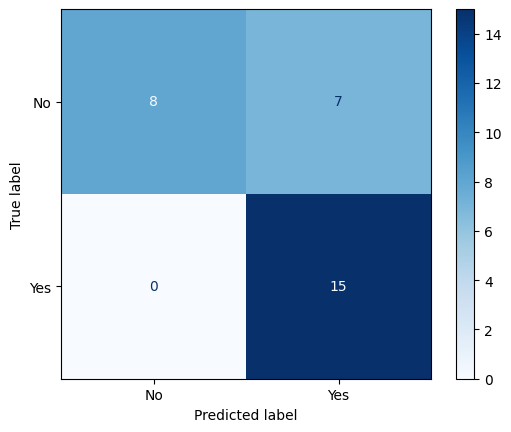

In [179]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Ensure the "Alzheimers" and "Predicted Alzheimers Status" columns are in binary format
# Calculate the confusion matrix
cm = confusion_matrix(test_results["Alzheimers"], test_results["Predicted Alzheimers"])

# Display the confusion matrix
print("Confusion Matrix:")
print(cm)

# Optional: Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No", "Yes"])
disp.plot(cmap="Blues")